# Charachterization of Protoboard Channels EEEMCal Prototype

## ADC and ToT Regions Config

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.ticker as ticker
import math

dead_channels = {0, 37, 38, 75, 76, 113, 114, 151}
calibration_channels = {19, 57, 95, 133}
notConnected_channels = {9, 18, 28, 47, 56, 66, 85, 94, 104, 123, 132, 142}

# ========= To make the plots =========
markers = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'h', 'X', '1', '2', '3', '4', '|']

color_list = [
    "#e6194b",  # Red
    "#3cb44b",  # Green
    "#ffe119",  # Yellow
    "#4363d8",  # Blue
    "#f58231",  # Orange
    "#911eb4",  # Purple
    "#46f0f0",  # Cyan
    "#f032e6",  # Magenta
    "#bcf60c",  # Lime
    "#008080",  # Teal
    "#9a6324",  # Brown
    "#800000",  # Maroon
    "#808000",  # Olive
    "#000075",  # Navy
    "#a9a9a9",  # Dark Gray
    "#ff4500",  # Orange Red
    "#228b22",  # Forest Green
    "#1e90ff",  # Dodger Blue
    "#8b008b",  # Dark Magenta
]

num_groups = 8
files_per_group = 19

# === Configuration for ADC===
injected_channels_per_asic = 3 # also for ToT
# injected_channels_per_asic = 76 # also for ToT

CONFIG = { 
    # "base_path": "/home/eic/Documents/internalinjection/PedestalStudies_InternalInjection_Oct2025/Linearity_Studies_Nov2025", 
    "base_path": "/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025", 
    "amplitudes": [100, 200, 300, 400], 
    "fpga_pb_pairs": [
        ("208", "06"),
        ("209", "008"),
        ("208", "008")
    ],
    "runs": 5
}

# === Configuration for ToT ===
CONFIG_TOT = { 
    # "base_path": "/home/eic/Documents/internalinjection/PedestalStudies_InternalInjection_Oct2025/Linearity_Studies_Nov2025", 
    "base_path": "/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025", 
    "amplitudes": [400, 450, 925, 1135, 1345, 1450, 1555, 1765, 1975], 
    "fpga_pb_pairs": [
        ("208", "06"),
        ("209", "008"),
        ("208", "008")
    ],
    "runs": 5
}

###############################################################
## Pedestal map function (with fallback) per (FPGA, PB) pair ##
###############################################################

# ========= Load pedestal CSV and build channel → pedestal map =========
PEDESTAL_CSV = "/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/pedestals/pedestals_HV_modified_FPGA208_209.csv"

# fallback pedestal if a channel has no entry in the CSV
fallback_pedestal = 80

# ========= Load pedestal CSV and build channel → pedestal map =========
ped_df = pd.read_csv(PEDESTAL_CSV)

pedestal_map_by_pair = {}  # (fpga_str, pb_str) -> {channel: pedestal}
# We can use all pairs that appear in CONFIG and CONFIG_TOT
all_pairs = set(CONFIG["fpga_pb_pairs"]) | set(CONFIG_TOT["fpga_pb_pairs"])

for fpga_str, pb_str in all_pairs:
    fpga_int = int(fpga_str)
    pb_int   = int(pb_str)

    ped_sub = ped_df[
        (ped_df["FPGA"] == fpga_int) &
        (ped_df["PB"] == pb_int)
    ]

    if ped_sub.empty:
        print(f"[WARNING] No pedestal entries for FPGA {fpga_int}, PB {pb_int}")
        pedestal_map_by_pair[(fpga_str, pb_str)] = {}
        continue

    ped_map = ped_sub.set_index("Channel")["HV"].to_dict()
    pedestal_map_by_pair[(fpga_str, pb_str)] = ped_map

    print(
        f"Loaded {len(ped_map)} pedestal values for pair "
        f"(FPGA {fpga_str}, PB {pb_str})"
    )

def get_pedestal_map_by_pair_id(pair_id):
    """
    Return the channel -> pedestal map for a given pair_id
    using CONFIG["fpga_pb_pairs"].
    """
    fpga_str, pb_str = CONFIG["fpga_pb_pairs"][pair_id]
    key = (fpga_str, pb_str)
    return pedestal_map_by_pair.get(key, {})


##########################
## For ADC FPGA per run ##
##########################

# ========= Choices ADC plot per run =========
pair_id = 1                 # 0 → (208,06), 1 → (209,008)
injected_amplitude = 400    # amplitude to plot
run_number = 4              # 1–5

# ========= Extract FPGA–PB pair from CONFIG =========
fpga_adc, pb_adc = CONFIG["fpga_pb_pairs"][pair_id]
run_idx = run_number - 1  # convert to index

pair_key = f"fpga{fpga_adc}_pb{pb_adc}"

# Get pedestal map via helper
pedestal_map = get_pedestal_map_by_pair_id(pair_id)

print(
    f"Loaded {len(pedestal_map)} pedestal values for pair "
    f"(FPGA {fpga_adc}, PB {pb_adc})"
)


#############################################################
## For mean ADC FPGA plot (also used in linearity analysis)##
#############################################################

# ========= User choices =========
pair_id_mean = 1              # 0 → (208,06), 1 → (209,008)
injected_amplitude_mean = 400  # amplitude to plot (must be in CONFIG["amplitudes"])

# ========= Get FPGA–PB pair from CONFIG =========
fpga_adc_mean, pb_adc_mean = CONFIG["fpga_pb_pairs"][pair_id_mean]

pair_key_mean = f"fpga{fpga_adc_mean}_pb{pb_adc_mean}"

# Get pedestal map via helper
pedestal_map_mean = get_pedestal_map_by_pair_id(pair_id_mean)

print(
    f"Loaded {len(pedestal_map_mean)} pedestal values for pair "
    f"(FPGA {fpga_adc_mean}, PB {pb_adc_mean})"
)


##################################################################
## Manually Discarded Channels (Unstable, Noisy, Unwanted, etc.)##
##################################################################
def add_discard(pair_id, *channels):
    """
    Add one or multiple channels to the manual_discarded_by_pair
    dictionary for the given FPGA–PB pair (selected by pair_id).

    Parameters
    ----------
    pair_id : int
        Index in CONFIG["fpga_pb_pairs"] that selects the FPGA–PB combination.

    *channels : int
        One or more channel numbers to add to the discarded list.
    """
    # Get (FPGA, PB) strings from CONFIG using pair_id
    fpga, pb = CONFIG["fpga_pb_pairs"][pair_id]
    key = (fpga, pb)

    # Create entry if it does not exist, then add all channels
    manual_discarded_by_pair.setdefault(key, set()).update(channels)

    print(f"Added channel(s) {channels} to pair {key}")

manual_discarded_by_pair = {}



Loaded 144 pedestal values for pair (FPGA 208, PB 06)
Loaded 144 pedestal values for pair (FPGA 208, PB 008)
Loaded 144 pedestal values for pair (FPGA 209, PB 008)
Loaded 144 pedestal values for pair (FPGA 209, PB 008)
Loaded 144 pedestal values for pair (FPGA 209, PB 008)


### ADC Directory Test

In [177]:
# === Directory Generator Function ===
def generate_all_dirs(config):
    all_dirs = {}
    
    for fpga, pb in config["fpga_pb_pairs"]:
        pair_key = f"fpga{fpga}_pb{pb}"
        all_dirs[pair_key] = {}
        
        for amp in config["amplitudes"]:
            all_dirs[pair_key][amp] = {
                i: f'{config["base_path"]}/{amp}dac/inj_adc_samples_{fpga}_pb{pb}_{injected_channels_per_asic}_{amp}_{i+1}.csv'
                for i in range(config["runs"])
            }
            
    return all_dirs

# === Initialize Directories ===
all_dirs = generate_all_dirs(CONFIG)

# === Utility Functions ===
def get_path(fpga, pb, amplitude, run, dirs_dict=all_dirs):
    pair_key = f"fpga{fpga}_pb{pb}"
    try:
        return dirs_dict[pair_key][amplitude][run]
    except KeyError:
        raise ValueError(f"No path found for pair ({fpga}, {pb}), amplitude {amplitude}, and run {run}")

def list_all_paths(dirs_dict=all_dirs):
    return [
        path 
        for pair_dirs in dirs_dict.values()
        for amp_dirs in pair_dirs.values()
        for path in amp_dirs.values()
    ]

# # === Example: Print All Paths ===
# for path in list_all_paths():
#     print(path)

# # Show dictionary structure
# all_dirs


### ToT Directory Test

In [178]:
# === Directory Generator Function for ToT ===
def generate_all_dirs_tot(config):
    all_dirs = {}
    
    for fpga, pb in config["fpga_pb_pairs"]:
        pair_key = f"fpga{fpga}_pb{pb}"
        all_dirs[pair_key] = {}
        
        for amp in config["amplitudes"]:
            all_dirs[pair_key][amp] = {
                i: f'{config["base_path"]}/{amp}dac/inj_adc_samples_{fpga}_pb{pb}_{injected_channels_per_asic}_{amp}_{i+1}.csv'
                for i in range(config["runs"])
            }
            
    return all_dirs

# === Initialize Directories ===
all_dirs_tot = generate_all_dirs_tot(CONFIG_TOT)

# === Utility Functions ===
def get_path_tot(fpga, pb, amplitude, run, dirs_dict=all_dirs_tot):
    pair_key = f"fpga{fpga}_pb{pb}"
    try:
        return dirs_dict[pair_key][amplitude][run]
    except KeyError:
        raise ValueError(f"No path found for pair ({fpga}, {pb}), amplitude {amplitude}, and run {run}")

def list_all_paths_tot(dirs_dict=all_dirs_tot):
    return [
        path 
        for pair_dirs in dirs_dict.values()
        for amp_dirs in pair_dirs.values()
        for path in amp_dirs.values()
    ]

# # === Example: Print All ToT Paths ===
# for path in list_all_paths_tot():
#     print(path)

# # Show dictionary structure
# all_dirs_tot


## Waveform Plot in All Connected Channels ADC Region

Using file:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/400dac/inj_adc_samples_209_pb008_3_400_4.csv


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


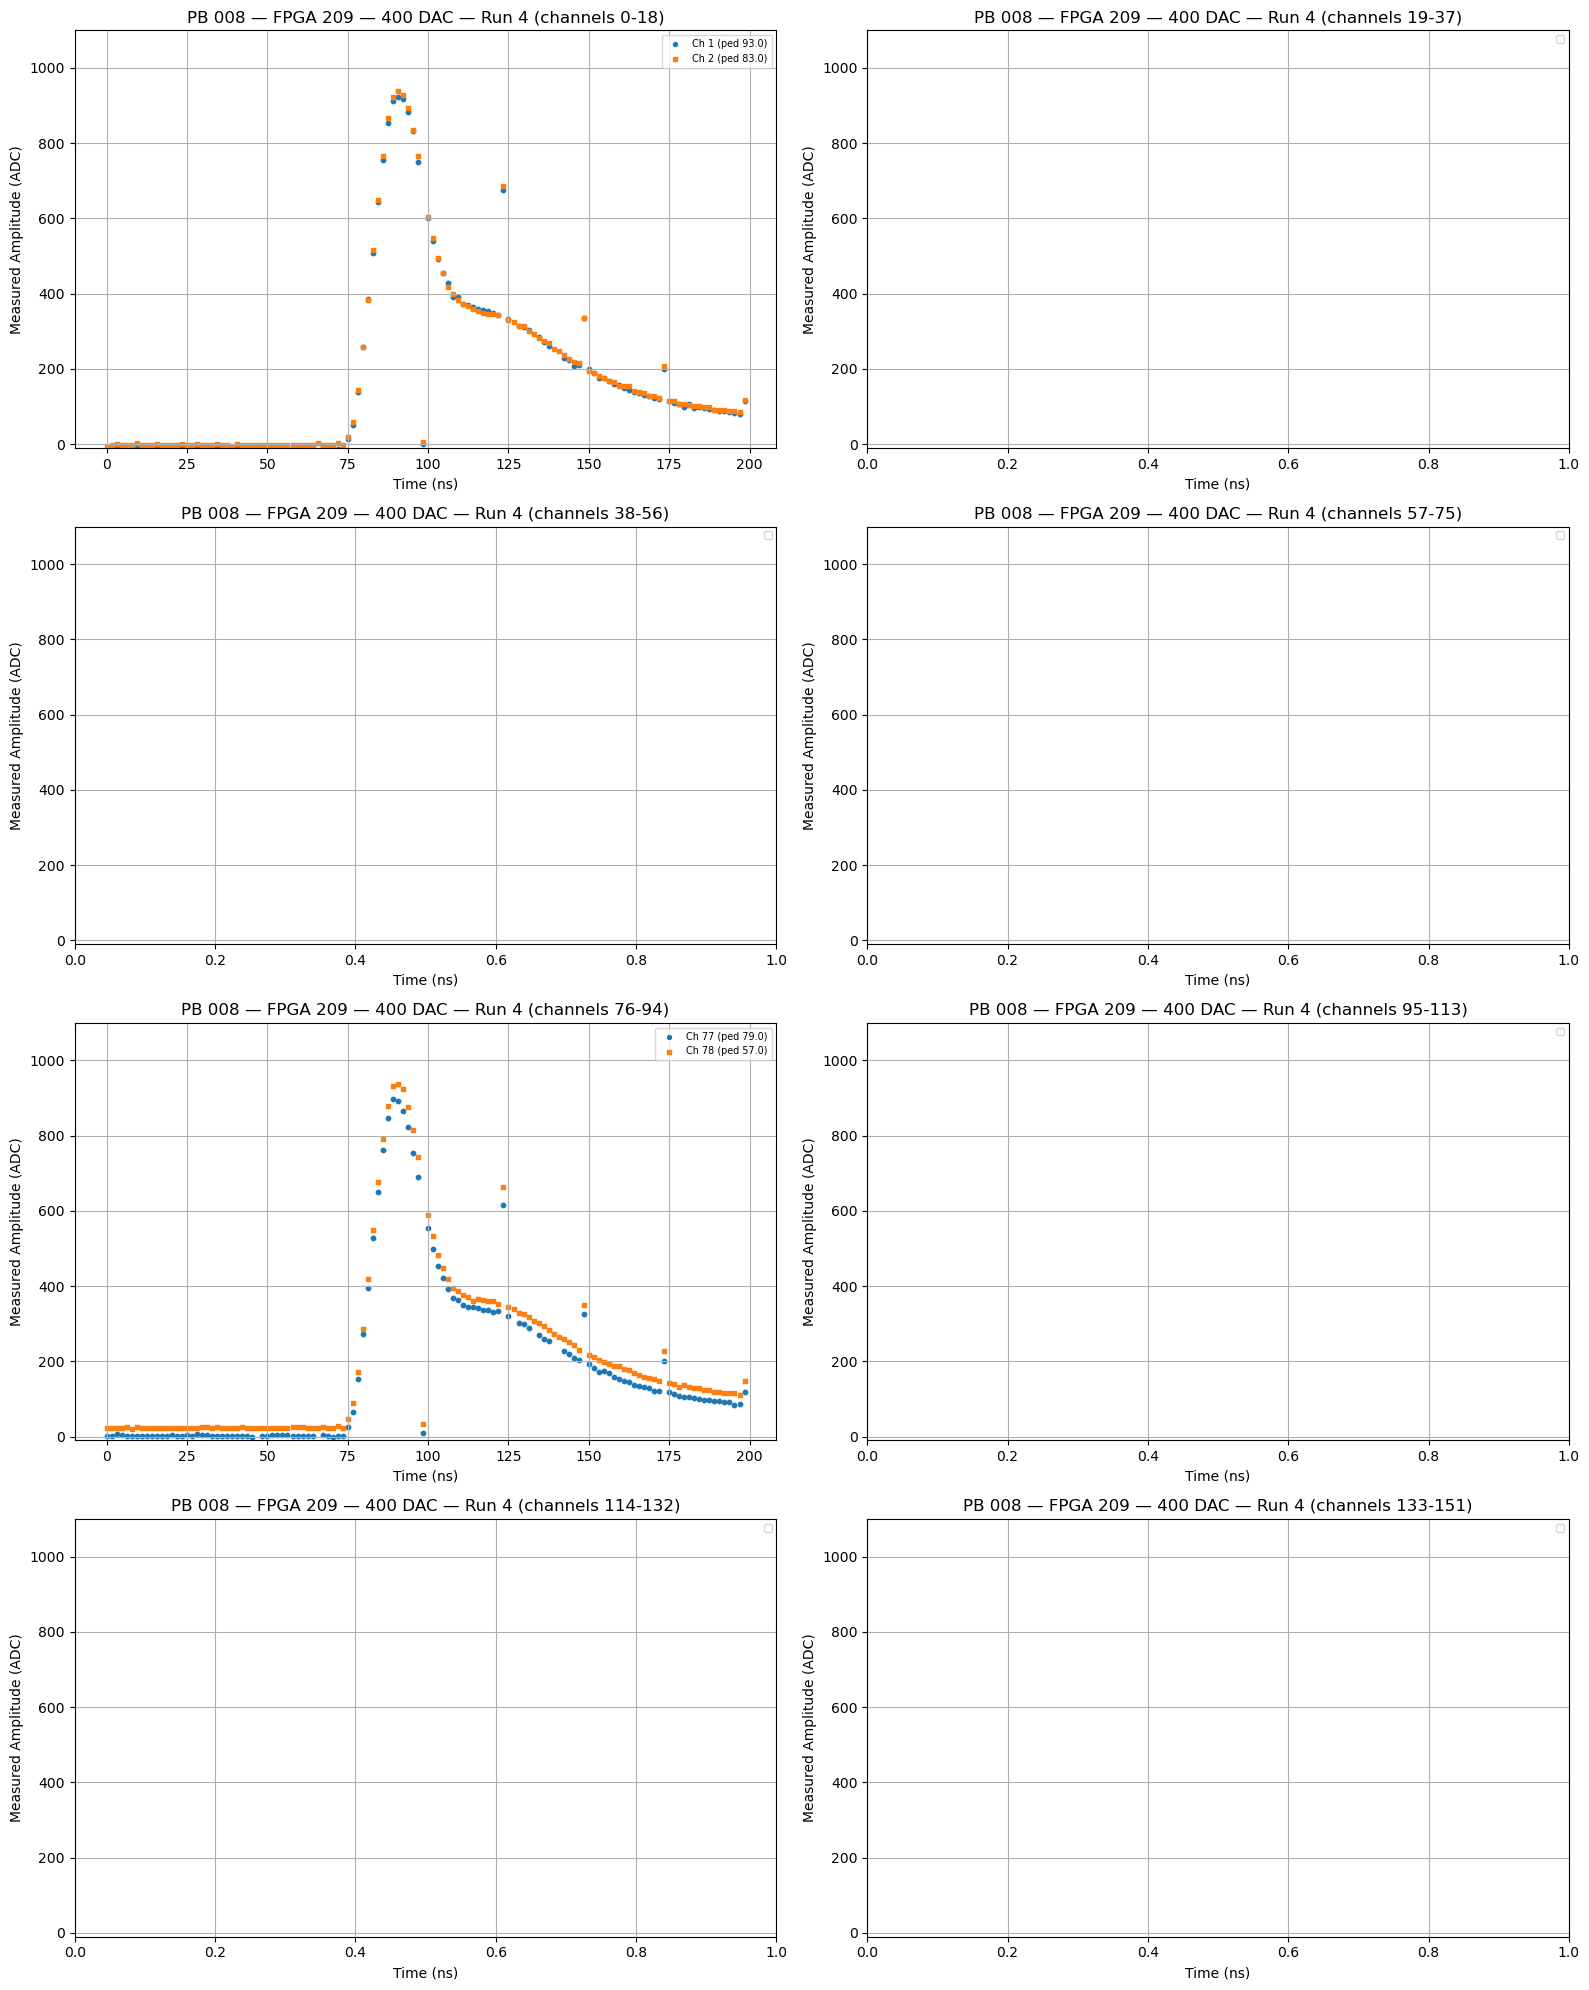

Figure saved to:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_209_pb008/phases_fpga209-pb008_amp400_run4.png


In [179]:
# ========= Retrieve file =========
try:
    data_file = all_dirs[pair_key][injected_amplitude][run_idx]
except KeyError:
    print(f"No entry in all_dirs for {pair_key}, amplitude {injected_amplitude}, run {run_number}")
    raise

if not os.path.exists(data_file):
    print(f"File not found:\n{data_file}")
    raise SystemExit

print(f"Using file:\n  {data_file}")

# ========= Plotting code =========

fig, axs = plt.subplots(4, 2, figsize=(16, 20))
axs = axs.flatten()

df = pd.read_csv(data_file)
df.columns = df.columns.str.strip()


for group_id in range(num_groups):
    ax = axs[group_id]
    first_channel = group_id * files_per_group
    last_channel = first_channel + files_per_group
    marker_index = 0

    for i in range(first_channel, last_channel):
        if i in dead_channels or i in calibration_channels or i in notConnected_channels:
            continue

        channel_data = df[df['Channel'] == i]
        if channel_data.empty:
            continue
        
        # Get pedestal for this channel
        ped_i = pedestal_map.get(i, fallback_pedestal)

        
        ax.scatter(
            channel_data['Time'],
            channel_data['ADC'] - ped_i,
            label=f'Ch {i} (ped {ped_i:.1f})',
            marker=markers[marker_index % len(markers)],
            s=10
        )
        marker_index += 1

    ax.set_title(
        f'PB {pb_adc} — FPGA {fpga_adc} — {injected_amplitude} DAC — Run {run_number} '
        f'(channels {first_channel}-{last_channel-1})'
    )
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Measured Amplitude (ADC)')
    ax.set_ylim(-10, 1100)
    ax.grid(True)
    ax.legend(fontsize='x-small', markerscale=0.9)

plt.tight_layout()
plt.show()

# ========= Save figure =========
output_dir = f'/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_{fpga_adc}_pb{pb_adc}'
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(
    output_dir,
    f'phases_fpga{fpga_adc}-pb{pb_adc}_amp{injected_amplitude}_run{run_number}.png'
)

fig.savefig(output_path, dpi=200)
print(f"Figure saved to:\n  {output_path}")


## Waveform Plot of All Channels (Mean Value of Runs) ADC Region

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


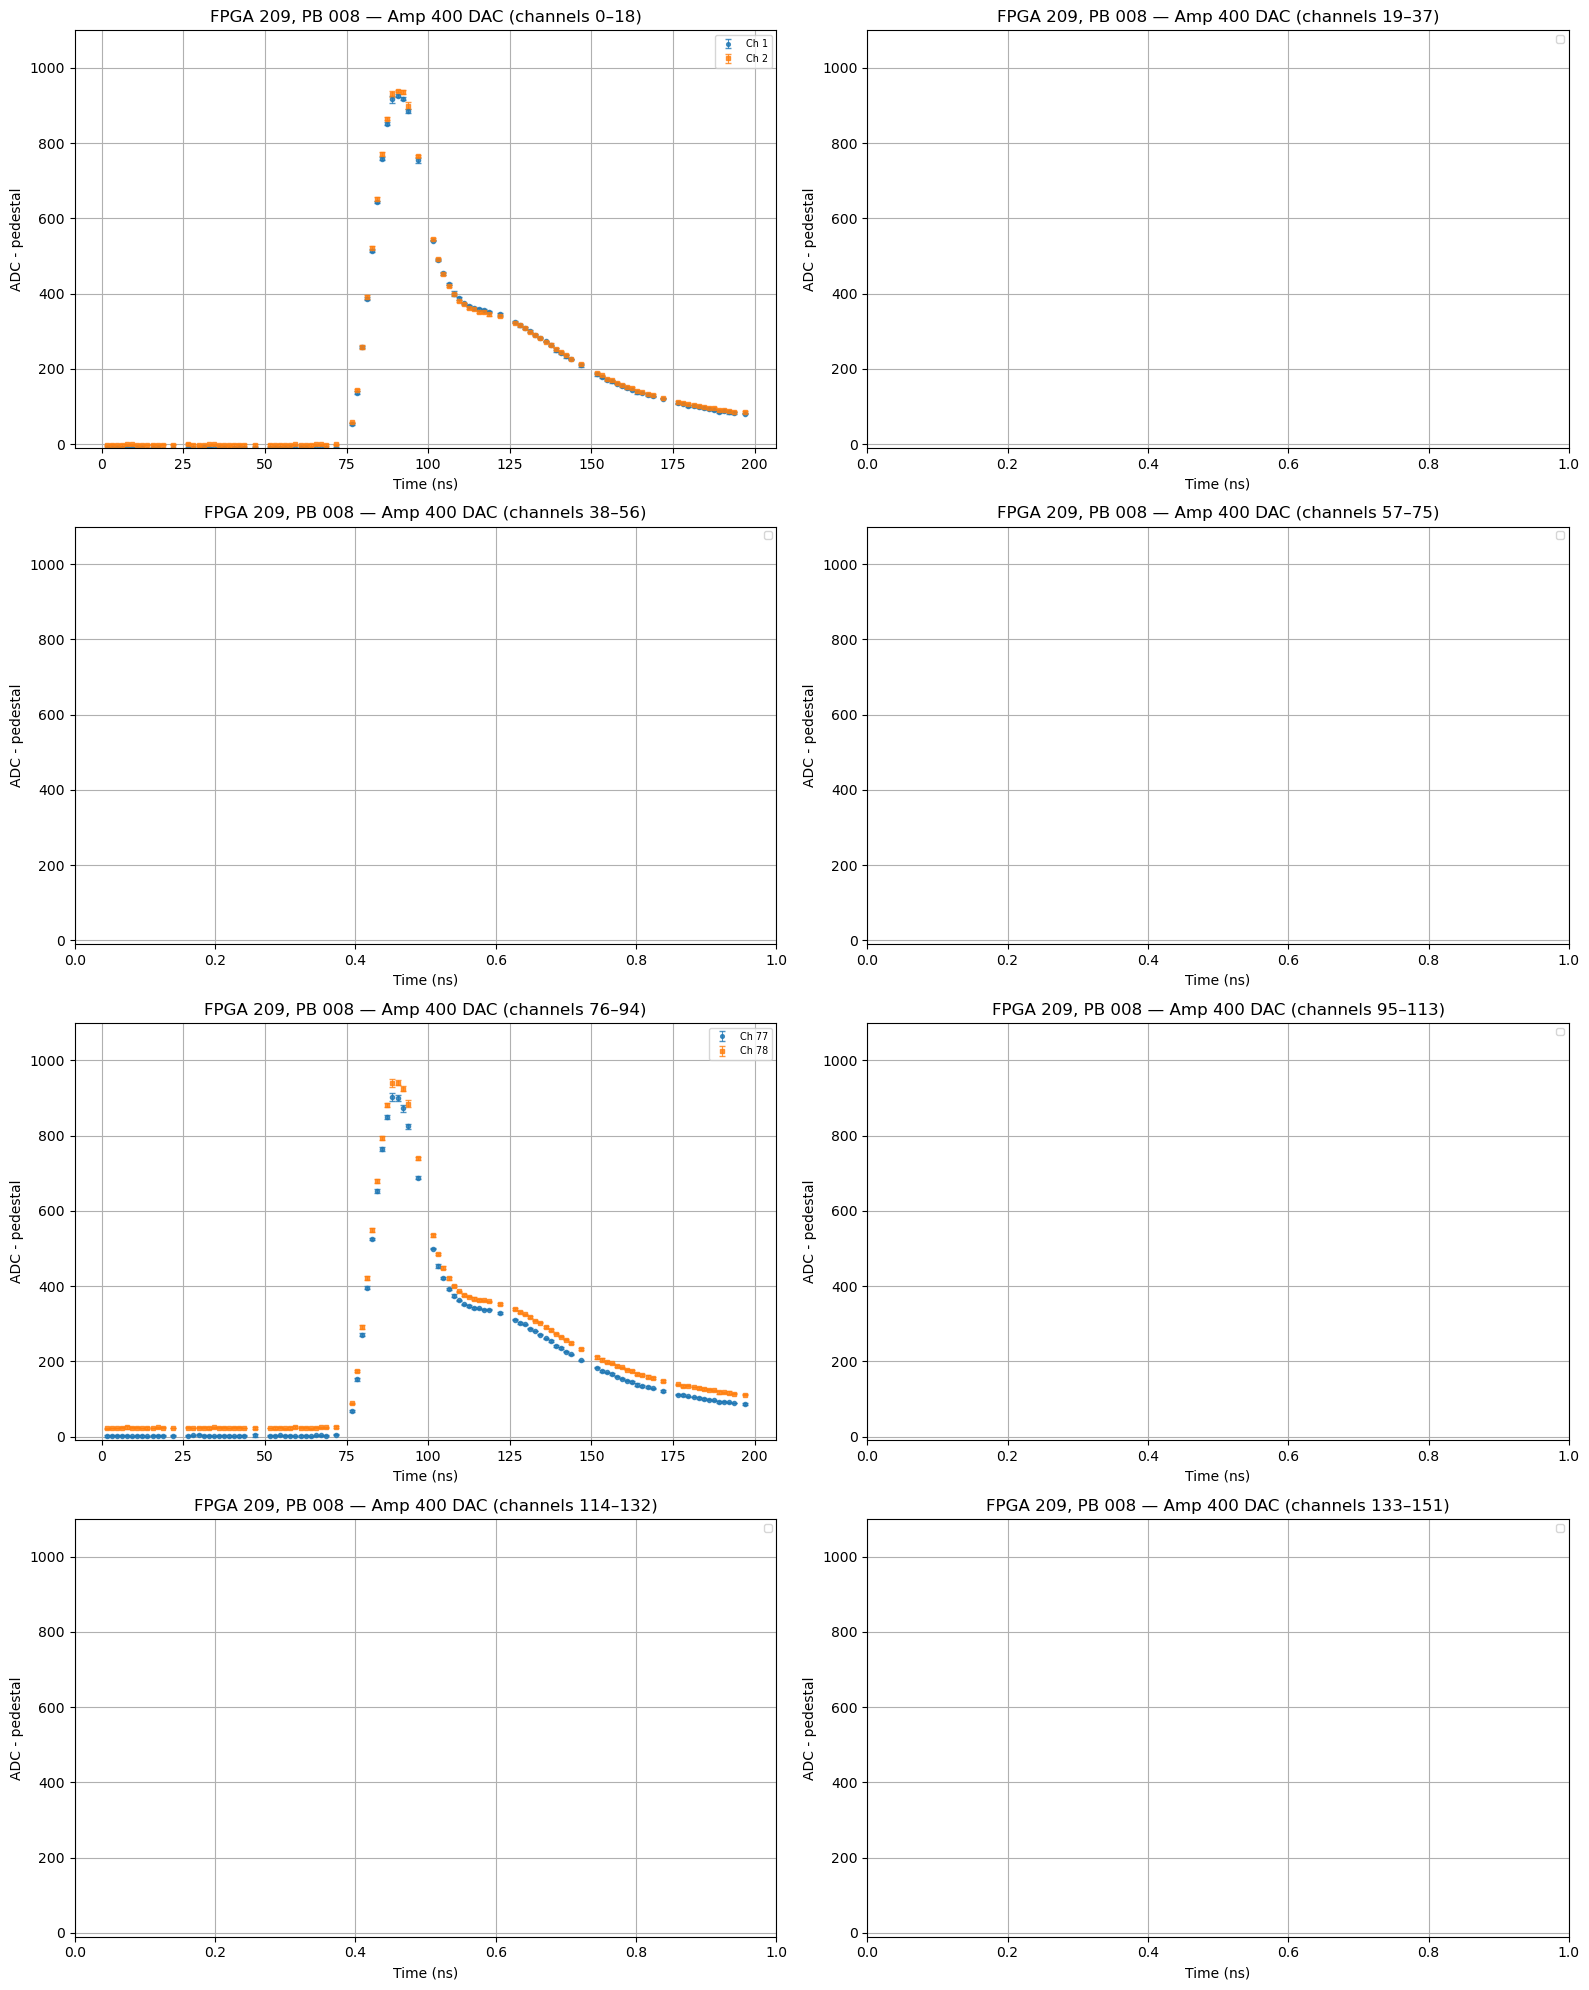

In [180]:
# ========= Extract the files for the specified amplitude and pair =========
try:
    run_files_mean = all_dirs[pair_key_mean][injected_amplitude_mean]   # dict: run_idx -> file_path
except KeyError:
    print(f"No files found for pair {pair_key_mean} and amplitude {injected_amplitude_mean}")
    raise

# ========= Figure =========
fig_mean, axs_mean = plt.subplots(4, 2, figsize=(16, 20))
axs_mean = axs_mean.flatten()

# ========= Loop over channel groups =========
for group_id in range(num_groups):
    ax = axs_mean[group_id]
    first_channel = group_id * files_per_group
    last_channel = first_channel + files_per_group
    marker_index = 0

    for channel in range(first_channel, last_channel):
        # Skip unwanted channels
        if (channel in dead_channels or
            channel in calibration_channels or
            channel in notConnected_channels):
            continue

        # Get pedestal for this channel
        ped_i = pedestal_map_mean.get(channel, fallback_pedestal)

        # Collect data across all runs
        all_runs_data_mean = []

        for run_idx, file_path in run_files_mean.items():
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                continue

            df = pd.read_csv(file_path)
            df.columns = df.columns.str.strip()

            # Filter by channel and remove unwanted phases
            channel_data = df[
                (df['Channel'] == channel) &
                (~df['Phase'].isin([4, 6, 7]))
            ]

            if channel_data.empty:
                continue

            # Work on a copy to avoid SettingWithCopy warnings
            channel_data = channel_data.copy()

            # Subtract per-channel pedestal
            channel_data['ADC'] = channel_data['ADC'] - ped_i

            all_runs_data_mean.append(channel_data[['Time', 'ADC']])

        # If we collected data from any run for this channel
        if all_runs_data_mean:
            combined_data = pd.concat(all_runs_data_mean)

            # Compute mean and std per Time bin
            stats = (
                combined_data
                .groupby('Time')['ADC']
                .agg(['mean', 'std'])
                .reset_index()
            )

            # Plot mean with error bars (std)
            ax.errorbar(
                stats['Time'],
                stats['mean'],
                yerr=stats['std'],
                fmt=markers[marker_index % len(markers)],
                markersize=3,
                capsize=2,
                elinewidth=0.8,
                label=f'Ch {channel}',
                alpha=0.8,
            )
            marker_index += 1

    ax.set_title(
        f'FPGA {fpga_adc_mean}, PB {pb_adc_mean} — Amp {injected_amplitude_mean} DAC '
        f'(channels {first_channel}–{last_channel - 1})'
    )
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('ADC - pedestal')
    ax.set_ylim(-10, 1100)
    ax.grid(True)
    ax.legend(fontsize='x-small', markerscale=0.9)

plt.tight_layout()
plt.show()

# Optional save:
output_dir_mean = f'/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_{fpga_adc_mean}_pb{pb_adc_mean}'
os.makedirs(output_dir_mean, exist_ok=True)
fig_mean.savefig(os.path.join(output_dir_mean, f'MeanChannelsWithError_fpga{fpga_adc_mean}-pb{pb_adc_mean}_{injected_amplitude_mean}DAC.png'))


### Manually Discarded Channels (Unstable, Noisy, Unwanted, etc.)

In [181]:
# add_discard(pair_id_mean, 36, 90, 96)

print(manual_discarded_by_pair)


{}


## Additional Config for ToT

In [184]:
##########################
## For ToT FPGA per run ##
##########################

# ========= Choices for ToT =========
pair_id_tot = 1                # 0 → (208,06), 1 → (209,008)
injected_amplitude_tot = 925   # must be in CONFIG_TOT["amplitudes"]
run_number_tot = 5             # 1–5

# ========= Extract FPGA–PB pair from CONFIG_TOT =========
fpga_tot, pb_tot = CONFIG_TOT["fpga_pb_pairs"][pair_id_tot]

pair_key_tot = f"fpga{fpga_tot}_pb{pb_tot}"
run_idx_tot = run_number_tot - 1   # convert to index (0–4)


##############################################################################
## For mean ToT FPGA plot (Used also for best phase and linearity analyisis)##
##############################################################################

# ========= User choices (ToT) =========
pair_id_tot_mean = 1              # 0 → (208,06), 1 → (209,008)
injected_amplitude_tot_mean = 400  # must exist in CONFIG_TOT["amplitudes"]

# ========= Get FPGA–PB pair from CONFIG_TOT =========
fpga_tot_mean, pb_tot_mean = CONFIG_TOT["fpga_pb_pairs"][pair_id_tot_mean]
pair_key_tot_mean = f"fpga{fpga_tot_mean}_pb{pb_tot_mean}"


### Plot ToT - 12b All Channels Per Run

In [185]:
# Pick the right manual-discard list for this FPGA–PB pair
manual_discarded_channels = manual_discarded_by_pair.get(
    (fpga_tot, pb_tot),
    set()  # default: no manual discards if pair not in dict
)
print("Manual discarded channels for this pair:", manual_discarded_channels)


Manual discarded channels for this pair: set()


Using ToT file:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/925dac/inj_adc_samples_209_pb008_3_925_5.csv


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


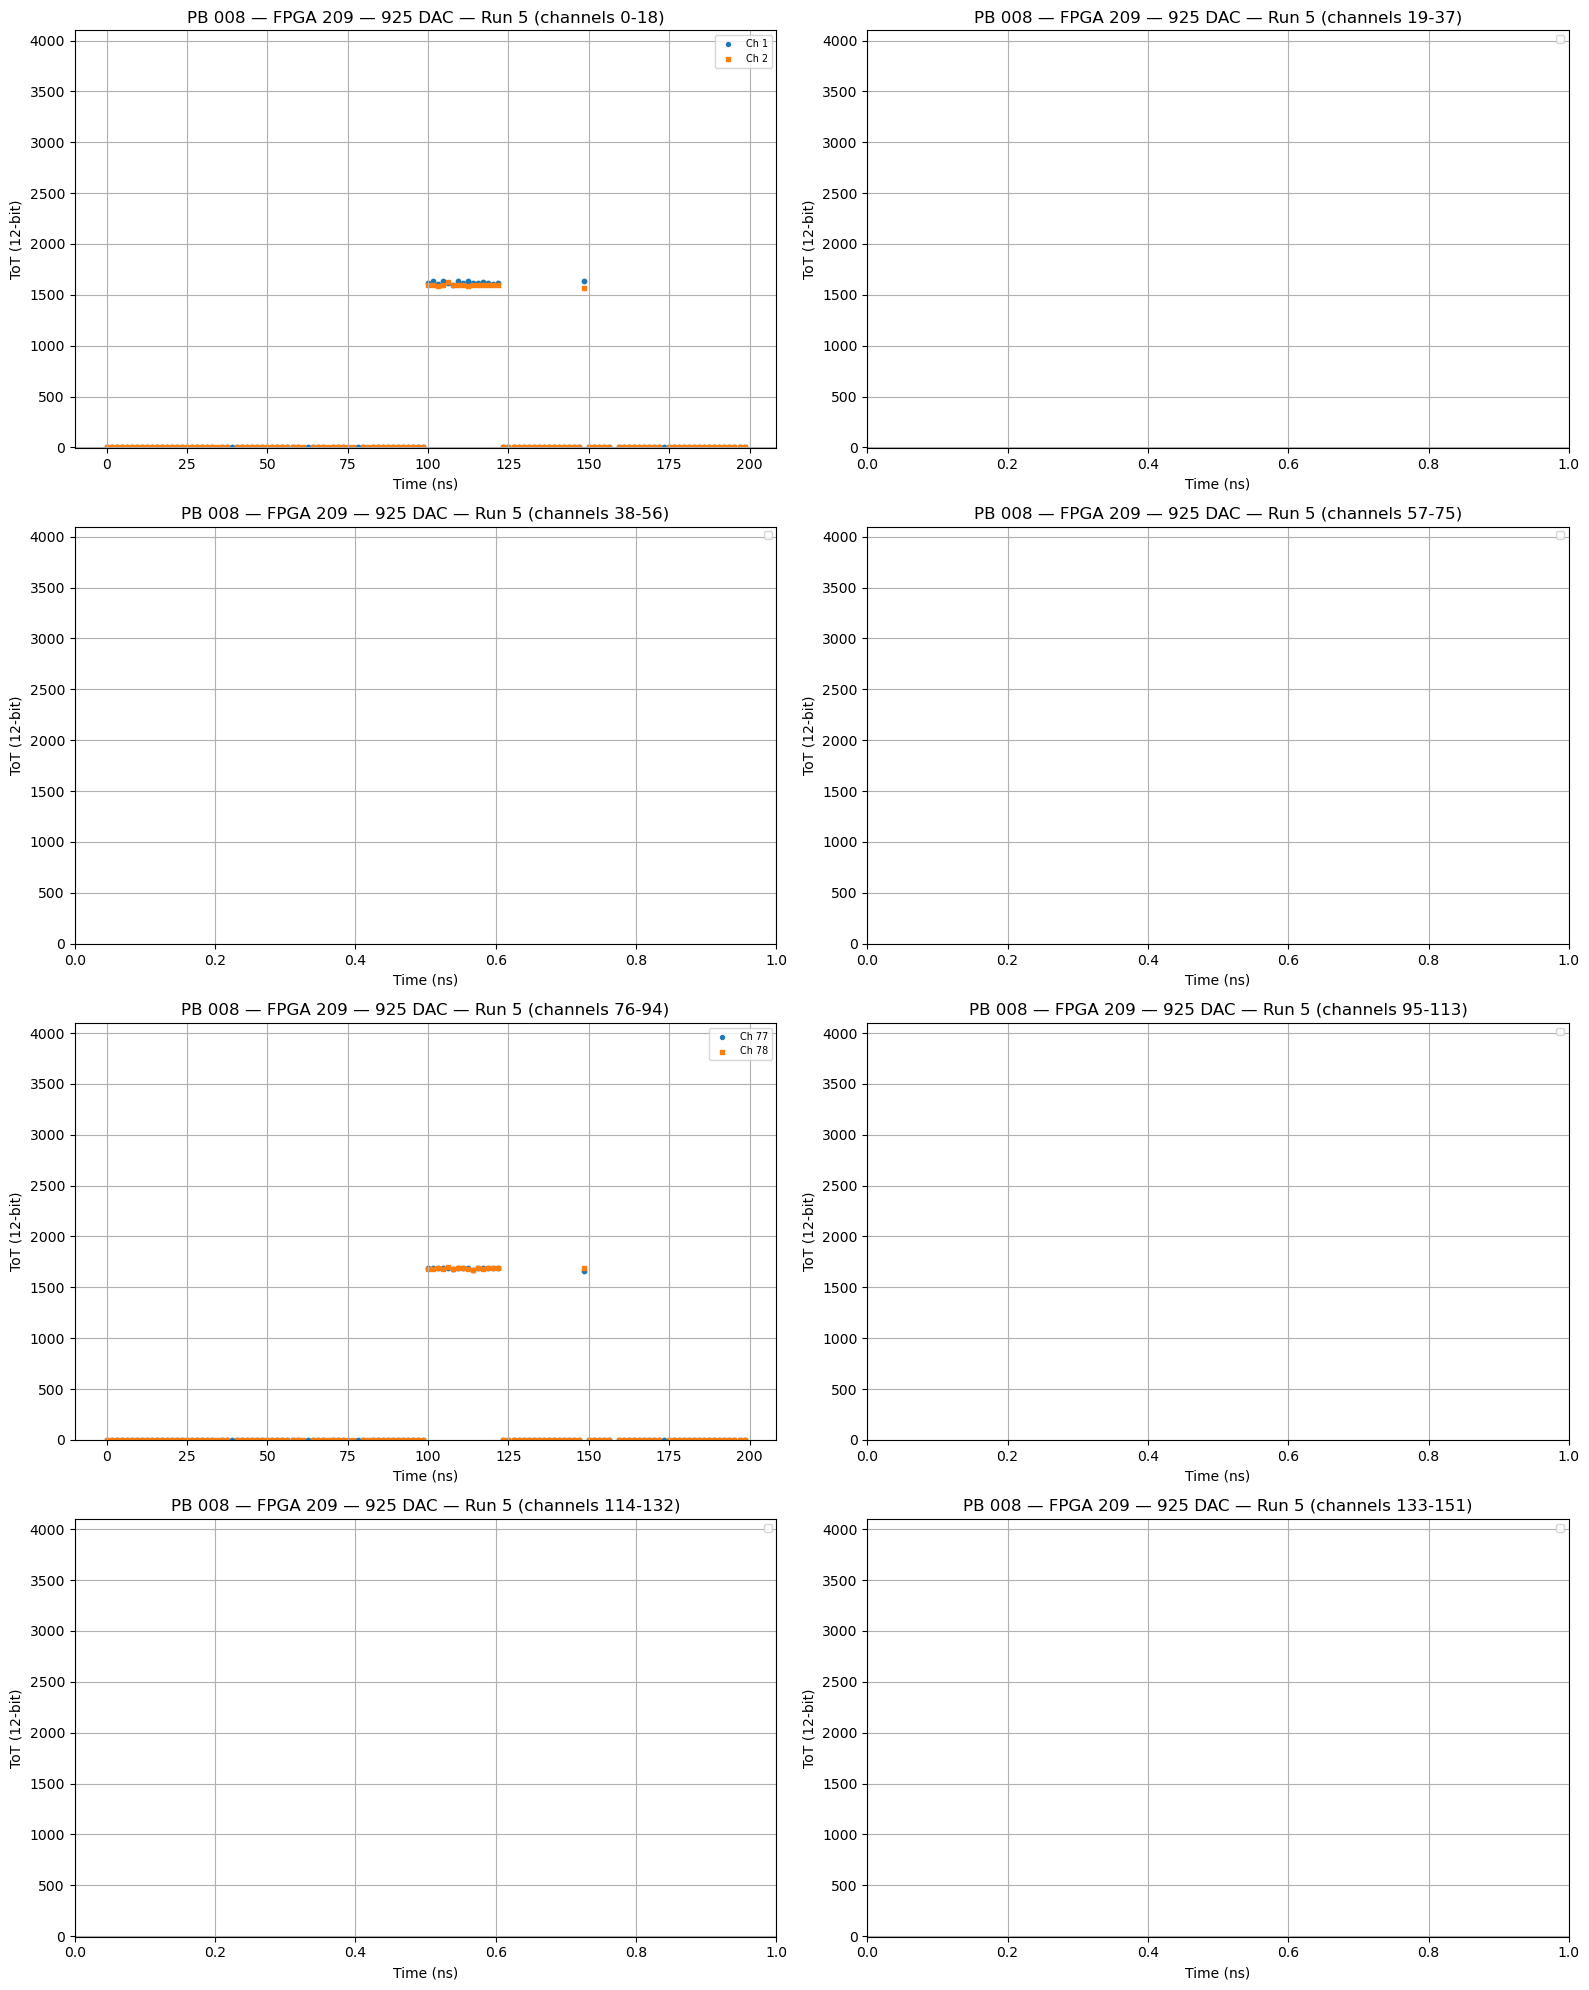

ToT figure saved to:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_209_pb008/phases_ToT_fpga209-pb008_amp925_run5.png


In [186]:
# ========= Retrieve ToT file =========
try:
    data_file_tot = all_dirs_tot[pair_key_tot][injected_amplitude_tot][run_idx_tot]
except KeyError:
    print(f"No entry in all_dirs_tot for {pair_key_tot}, amplitude {injected_amplitude_tot}, run {run_number_tot}")
    raise

if not os.path.exists(data_file_tot):
    print(f"ToT file not found:\n{data_file_tot}")
    raise SystemExit

print(f"Using ToT file:\n  {data_file_tot}")

# ========= Read CSV =========
df_tot = pd.read_csv(data_file_tot)
df_tot.columns = df_tot.columns.str.strip()

# ========= Plotting ToT for all channels =========
fig_tot, axs = plt.subplots(4, 2, figsize=(16, 20))
axs = axs.flatten()

for group_id in range(num_groups):
    ax = axs[group_id]
    first_channel = group_id * files_per_group
    last_channel = first_channel + files_per_group
    marker_index = 0

    for ch in range(first_channel, last_channel):
        # Skip unwanted channels
        if (ch in dead_channels or
            ch in calibration_channels or
            ch in notConnected_channels or
            ch in manual_discarded_channels):
            continue

        channel_data = df_tot[df_tot["Channel"] == ch]
        if channel_data.empty:
            continue

        # Scatter ToT vs Time (use TOT_12bit; change to TOT_10bit if you want)
        ax.scatter(
            channel_data["Time"],
            channel_data["TOT_12bit"],
            label=f"Ch {ch}",
            marker=markers[marker_index % len(markers)],
            s=10
        )
        marker_index += 1

    ax.set_title(
        f"PB {pb_tot} — FPGA {fpga_tot} — {injected_amplitude_tot} DAC — Run {run_number_tot} "
        f"(channels {first_channel}-{last_channel-1})"
    )
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("ToT (12-bit)")
    ax.set_ylim(-5, 4100)   # full 12-bit range
    ax.grid(True)
    ax.legend(fontsize="x-small", markerscale=0.9)

plt.tight_layout()
plt.show()

# ========= Save ToT figure =========
output_dir_tot = f"/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_{fpga_tot}_pb{pb_tot}"
os.makedirs(output_dir_tot, exist_ok=True)

output_path_tot = os.path.join(
    output_dir_tot,
    f"phases_ToT_fpga{fpga_tot}-pb{pb_tot}_amp{injected_amplitude_tot}_run{run_number_tot}.png"
)

fig_tot.savefig(output_path_tot, dpi=200)
print(f"ToT figure saved to:\n  {output_path_tot}")


### Plot the ToT - 12b All Channels (Mean Value of Runs)

In [187]:
threshold_good_channel = 200
minimum_tot_allowed = 100


Found 5 ToT files for FPGA 209, PB 008


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


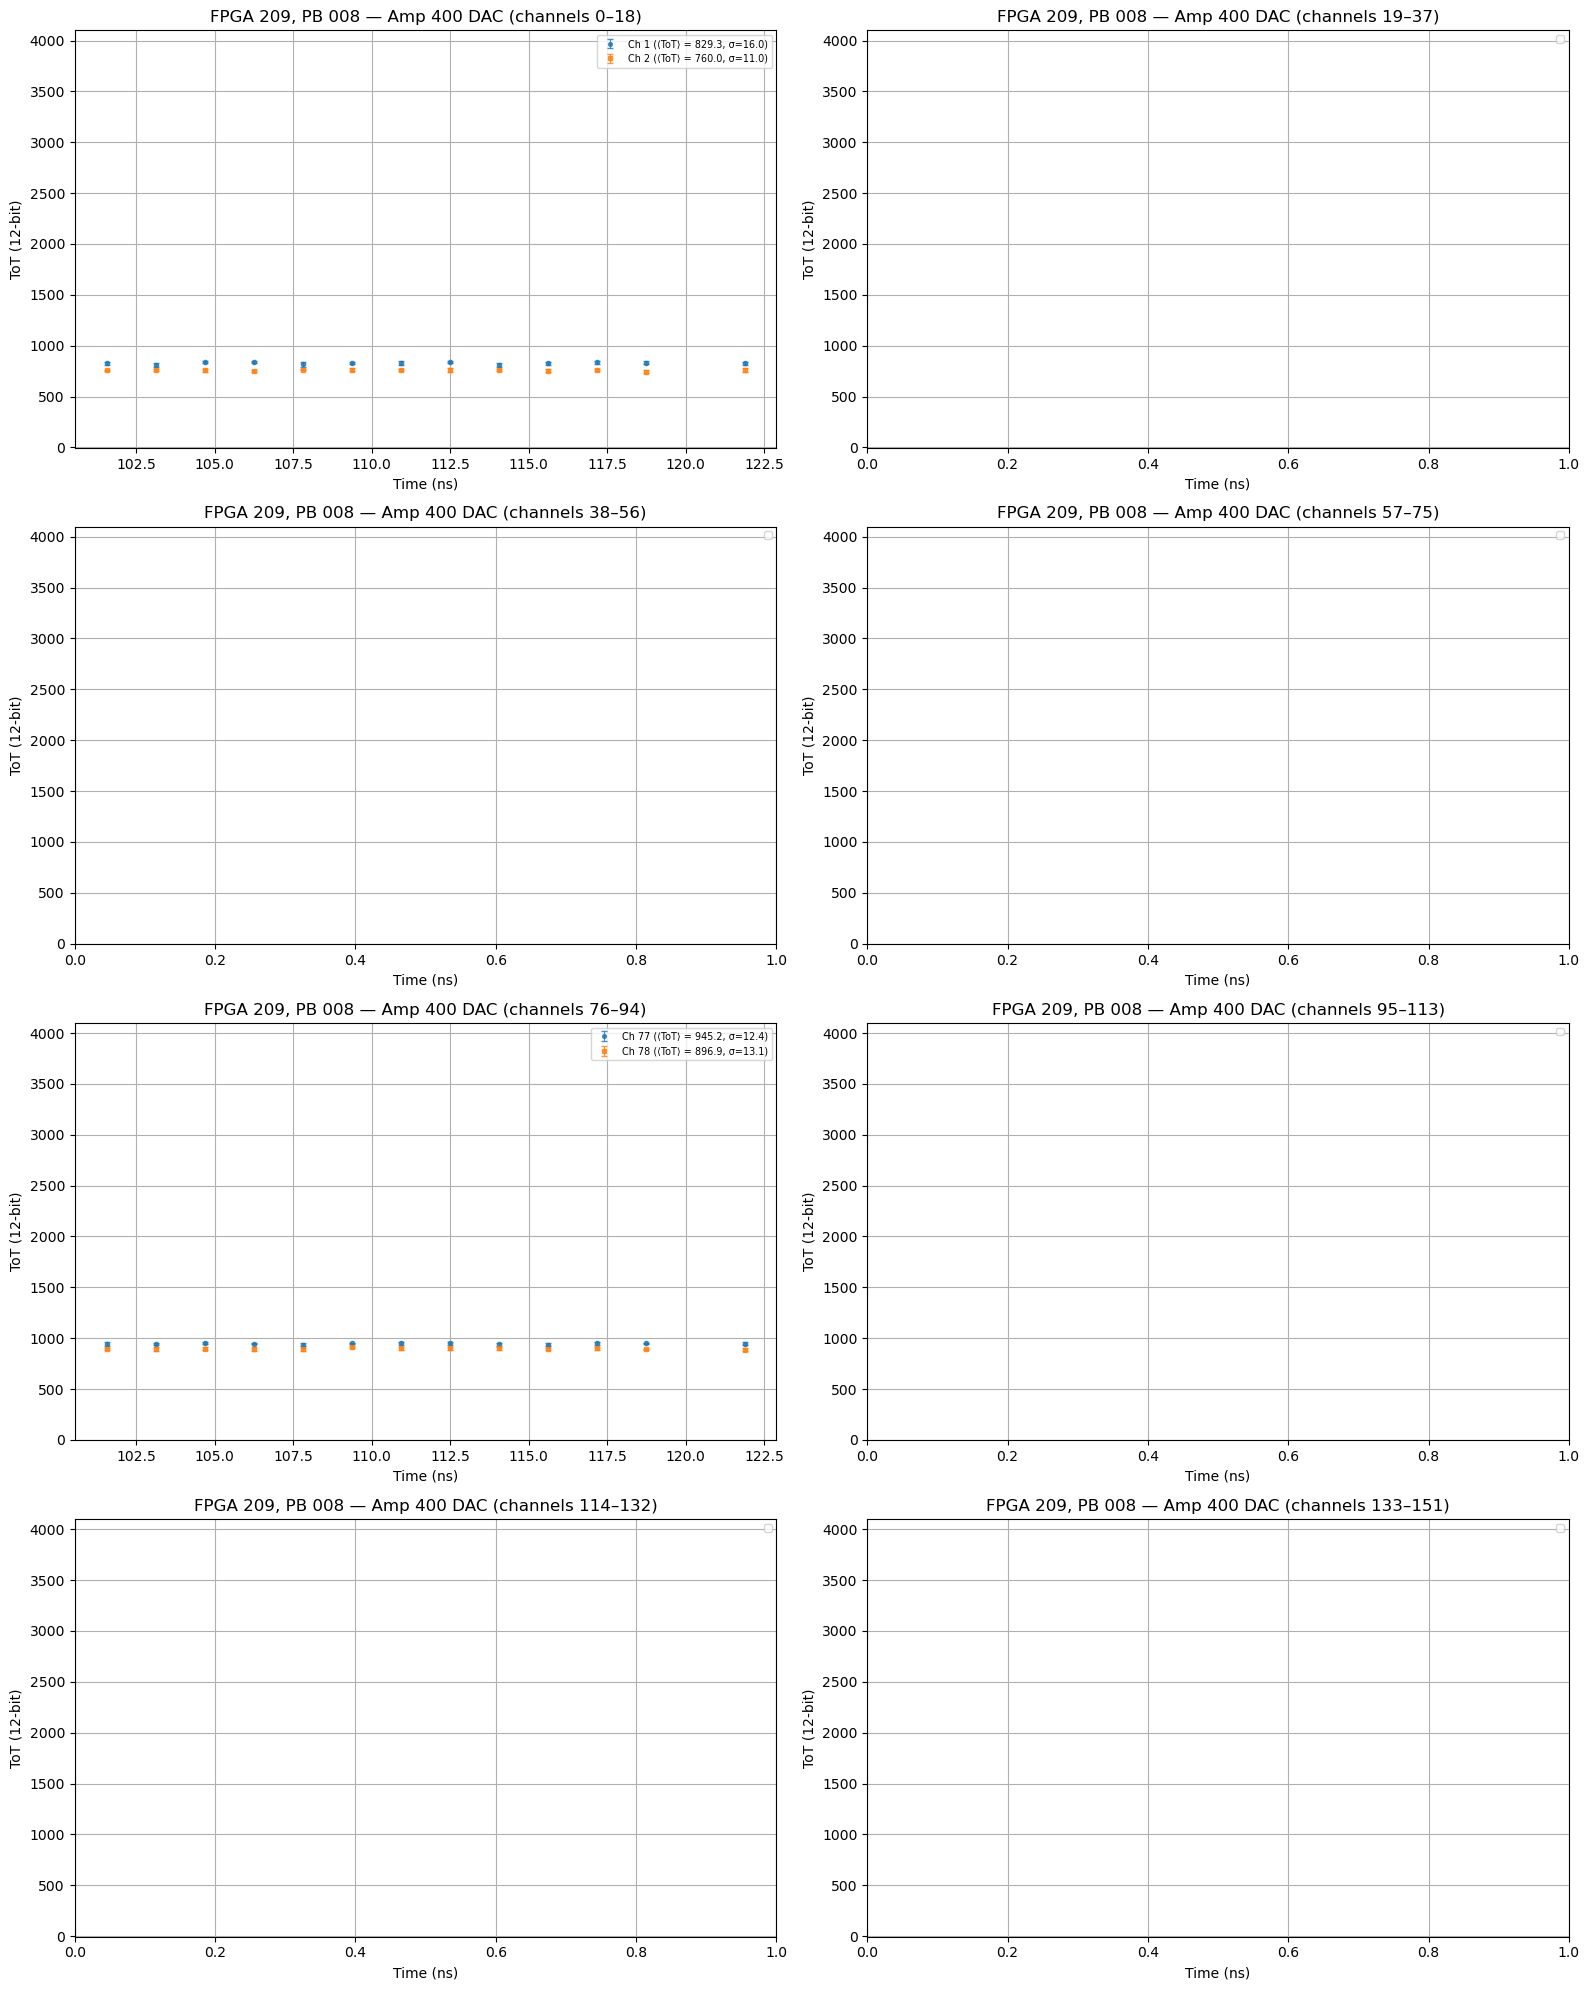

Saved ToT mean figure to:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_209_pb008/Mean_ToT_fpga209-pb008_400DAC.png

=== Channels with mean std(ToT) >= 200 (using only points with ToT ≥ 100) ===
None 🎉


In [188]:
# ========= Extract all run files for this ToT amplitude =========
try:
    run_files_tot_mean = all_dirs_tot[pair_key_tot_mean][injected_amplitude_tot_mean]
except KeyError:
    print(f"No ToT files found for pair {pair_key_tot_mean}, amplitude {injected_amplitude_tot_mean}")
    raise

print(f"Found {len(run_files_tot_mean)} ToT files for FPGA {fpga_tot_mean}, PB {pb_tot_mean}")

# ========= Figure for ToT mean plots =========
fig_tot_mean, axs_tot_mean = plt.subplots(4, 2, figsize=(16, 20))
axs_tot_mean = axs_tot_mean.flatten()

high_std_channels = []   # collect channels with mean std >= threshold_good_channel

# ========= Loop over channel groups =========
for group_id in range(num_groups):
    ax = axs_tot_mean[group_id]
    first_channel = group_id * files_per_group
    last_channel = first_channel + files_per_group
    marker_index = 0

    for channel in range(first_channel, last_channel):

        # Skip unwanted channels
        if (channel in dead_channels or
            channel in calibration_channels or
            channel in notConnected_channels):
            continue

        # Collect ToT data across runs
        all_runs_tot_mean = []

        for run_idx, file_path in run_files_tot_mean.items():
            if not os.path.exists(file_path):
                print(f"ToT file not found: {file_path}")
                continue

            df = pd.read_csv(file_path)
            df.columns = df.columns.str.strip()

            # Filter channel + remove unwanted phases
            ch_data = df[
                (df["Channel"] == channel) &
                (~df["Phase"].isin([4, 6, 7]))
            ]

            if ch_data.empty:
                continue

            # No pedestal subtraction for ToT
            all_runs_tot_mean.append(ch_data[["Time", "TOT_12bit"]])

        # If we collected any data for this channel:
        # If we collected any data for this channel:
        if all_runs_tot_mean:
            # 1) Full data (all ToT values) → for plotting
            combined_tot_full = pd.concat(all_runs_tot_mean)

            # ---- drop all points with ToT < minimum_tot_allowed ----
            combined_tot = combined_tot_full[combined_tot_full["TOT_12bit"] >= minimum_tot_allowed]

            if combined_tot.empty:
                # No significant ToT points for this channel
                continue

            # Compute mean and std per time bin (filtered data)
            stats_tot_mean_filtered = (
                combined_tot
                .groupby("Time")["TOT_12bit"]
                .agg(["mean", "std"])
                .reset_index()
            )

            # 🔹 Drop time bins where std is NaN (only 1 point in that bin)
            stats_tot_mean_filtered = stats_tot_mean_filtered.dropna(subset=["std"])

            if stats_tot_mean_filtered.empty:
                # After dropping NaNs, nothing to plot / analyze
                continue

            # Global mean and std from filtered bins
            mean_tot_overall = stats_tot_mean_filtered["mean"].mean()
            std_tot_overall  = stats_tot_mean_filtered["std"].mean()

            # Check threshold
            if std_tot_overall >= threshold_good_channel:
                high_std_channels.append((channel, std_tot_overall))
                
            # # --- Stats for plotting (full data, no ToT cut) ---
            # stats_tot_mean_full = (
            #     combined_tot_full
            #     .groupby("Time")["TOT_12bit"]
            #     .agg(["mean", "std"])
            #     .reset_index()
            # )
            
            # # Plot mean ToT ± error bars (you can choose if you want filtered or full;
            # # here we plot the filtered version, i.e. ToT >= 100 only)
            # # 🔹 Plot the FULL ToT curve (but label uses mean from filtered if you like)
            # ax.errorbar(
            #     stats_tot_mean_full["Time"],
            #     stats_tot_mean_full["mean"],
            #     yerr=stats_tot_mean_full["std"],
            #     fmt=markers[marker_index % len(markers)],
            #     markersize=3,
            #     capsize=2,
            #     elinewidth=0.8,
            #     label=f"Ch {channel} (⟨ToT⟩ = {mean_tot_overall:.1f})",
            #     alpha=0.8,
            # )
            
            # --- Plot ONLY the filtered ToT (ToT >= 100, finite std) ---
            ax.errorbar(
                stats_tot_mean_filtered["Time"],
                stats_tot_mean_filtered["mean"],
                yerr=stats_tot_mean_filtered["std"],
                fmt=markers[marker_index % len(markers)],
                markersize=3,
                capsize=2,
                elinewidth=0.8,
                label=f"Ch {channel} (⟨ToT⟩ = {mean_tot_overall:.1f}, σ={std_tot_overall:.1f})",
                alpha=0.8,
            )
            marker_index += 1

    ax.set_title(
        f"FPGA {fpga_tot_mean}, PB {pb_tot_mean} — Amp {injected_amplitude_tot_mean} DAC "
        f"(channels {first_channel}–{last_channel - 1})"
    )
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("ToT (12-bit)")
    ax.set_ylim(-5, 4100)
    ax.grid(True)
    ax.legend(fontsize="x-small", markerscale=0.9)

plt.tight_layout()
plt.show()

# ========= Save ToT figure =========
output_dir_tot_mean = (
    f"/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/"
    f"FPGA_{fpga_tot_mean}_pb{pb_tot_mean}"
)
os.makedirs(output_dir_tot_mean, exist_ok=True)

output_path_tot_mean = os.path.join(
    output_dir_tot_mean,
    f"Mean_ToT_fpga{fpga_tot_mean}-pb{pb_tot_mean}_{injected_amplitude_tot_mean}DAC.png"
)

fig_tot_mean.savefig(output_path_tot_mean, dpi=200)
print(f"Saved ToT mean figure to:\n  {output_path_tot_mean}")

# ========= Print channels exceeding threshold =========
print(
    f"\n=== Channels with mean std(ToT) >= {threshold_good_channel} "
    f"(using only points with ToT ≥ {minimum_tot_allowed}) ==="
)
if high_std_channels:
    for ch, stdv in sorted(high_std_channels, key=lambda x: x[0]):
        print(f"Channel {ch}: mean std = {stdv:.1f}")
else:
    print("None 🎉")


# ToA

Using ToA file:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/400dac/inj_adc_samples_209_pb008_3_400_2.csv


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


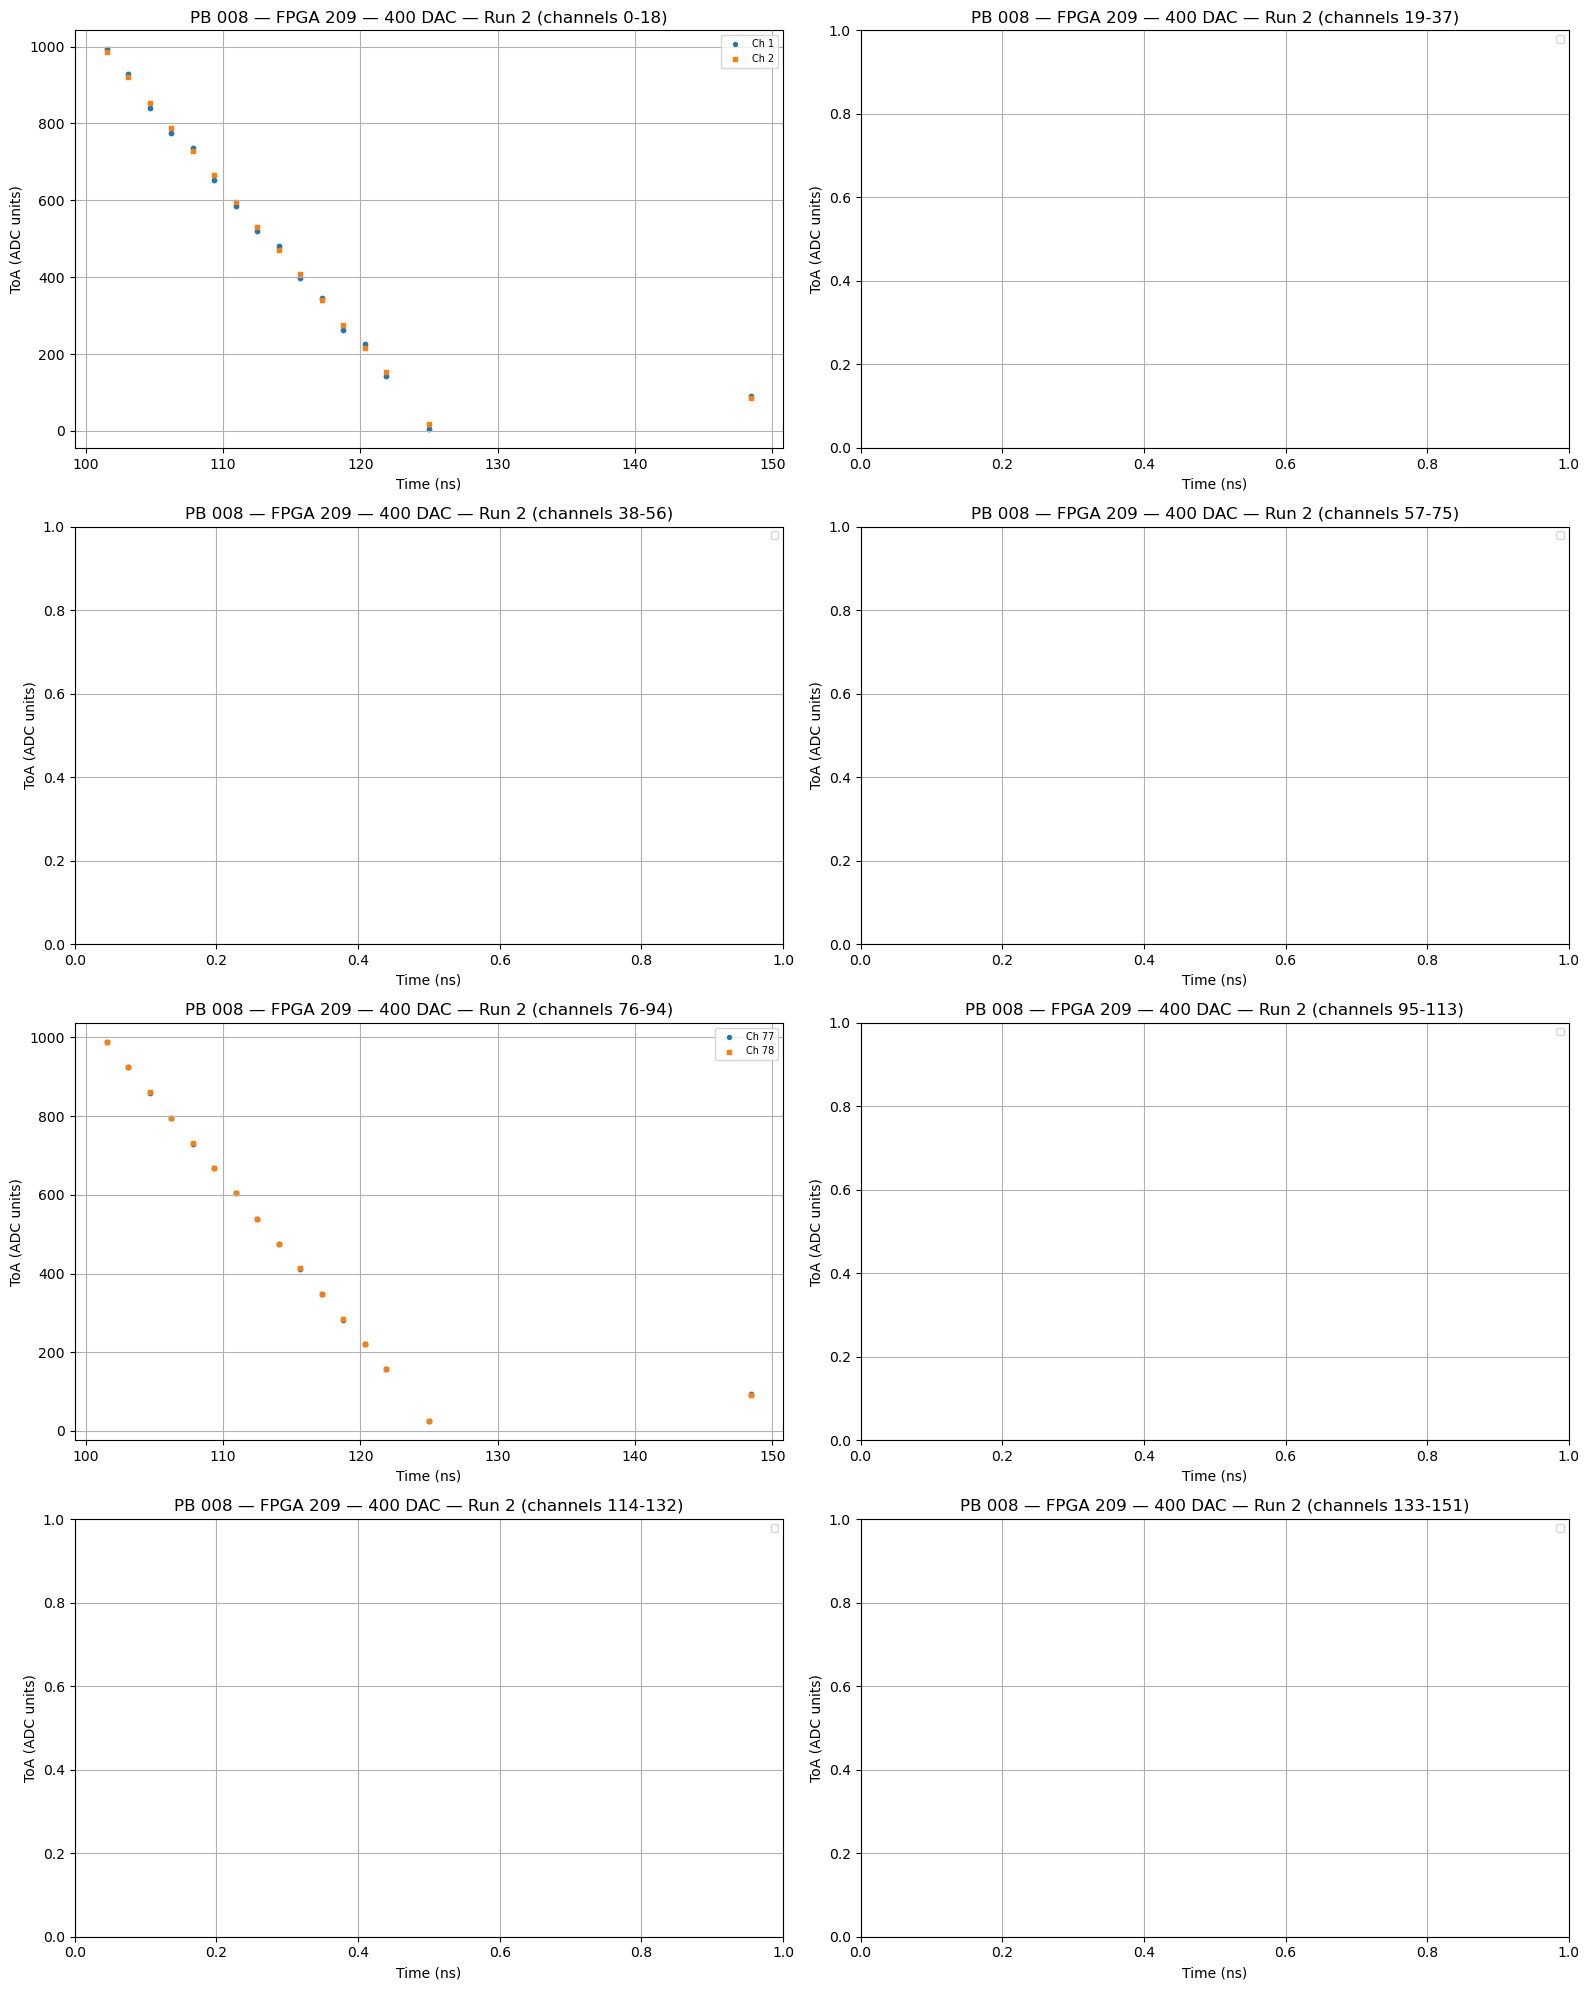

ToA figure saved to:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_209_pb008/ToA_fpga209-pb008_amp400_run2.png


In [189]:
##########################
## ToA per run (grid)   ##
##########################

# ---- Choices ----
pair_id_toa   = 1              # 0 → (208,06), 1 → (209,008), 2 → (208,008)
injected_amp_toa = 400         # must be in CONFIG["amplitudes"] or CONFIG_TOT["amplitudes"]
run_number_toa   = 2           # 1–5

# You can use either all_dirs (ADC scans) or all_dirs_tot (ToT scans) since both files have ToA.

fpga_toa, pb_toa = CONFIG["fpga_pb_pairs"][pair_id_toa]
# fpga_toa, pb_toa = CONFIG_TOT["fpga_pb_pairs"][pair_id_toa]
pair_key_toa     = f"fpga{fpga_toa}_pb{pb_toa}"
run_idx_toa      = run_number_toa - 1

# ---- Get file ----
try:
    data_file_toa = all_dirs[pair_key_toa][injected_amp_toa][run_idx_toa]
except KeyError:
    print(f"No entry in all_dirs for {pair_key_toa}, amplitude {injected_amp_toa}, run {run_number_toa}")
    raise

if not os.path.exists(data_file_toa):
    print(f"ToA file not found:\n{data_file_toa}")
    raise SystemExit

print(f"Using ToA file:\n  {data_file_toa}")

# ---- Read CSV ----
df_toa = pd.read_csv(data_file_toa)
df_toa.columns = df_toa.columns.str.strip()

# (optional) drop ToA = 0 if you only want real hits
df_toa = df_toa[df_toa["ToA"] > 0]

# ---- Plot grid: Time vs ToA ----
fig_toa, axs_toa = plt.subplots(4, 2, figsize=(16, 20))
axs_toa = axs_toa.flatten()

for group_id in range(num_groups):
    ax = axs_toa[group_id]
    first_channel = group_id * files_per_group
    last_channel  = first_channel + files_per_group
    marker_index  = 0

    for ch in range(first_channel, last_channel):
        # Skip unwanted channels
        if (ch in dead_channels or
            ch in calibration_channels or
            ch in notConnected_channels):
            continue

        ch_data = df_toa[df_toa["Channel"] == ch]
        if ch_data.empty:
            continue

        ax.scatter(
            ch_data["Time"],
            ch_data["ToA"],
            label=f"Ch {ch}",
            marker=markers[marker_index % len(markers)],
            s=10,
        )
        marker_index += 1

    ax.set_title(
        f"PB {pb_toa} — FPGA {fpga_toa} — {injected_amp_toa} DAC — Run {run_number_toa} "
        f"(channels {first_channel}-{last_channel-1})"
    )
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("ToA (ADC units)")
    ax.grid(True)
    ax.legend(fontsize="x-small", markerscale=0.9)

plt.tight_layout()
plt.show()

# ---- Save figure ----
output_dir_toa = os.path.join(
    CONFIG["base_path"],
    f"images/FPGA_{fpga_toa}_pb{pb_toa}"
)
os.makedirs(output_dir_toa, exist_ok=True)

output_path_toa = os.path.join(
    output_dir_toa,
    f"ToA_fpga{fpga_toa}-pb{pb_toa}_amp{injected_amp_toa}_run{run_number_toa}.png"
)
fig_toa.savefig(output_path_toa, dpi=200)
print(f"ToA figure saved to:\n  {output_path_toa}")


## Extract ADC Peak per Amplitude ADC Just for One Run

In [190]:
def extract_peaks(all_dirs_pair, channel, pedestal_value):
    """
    Extract peak ADC values per amplitude and per run for one channel.

    Parameters:
        all_dirs_pair : dict
            Dictionary for one FPGA-PB pair:
            { amplitude : { run_idx : file_path } }
        channel : int
            Channel number to extract peaks from.
        pedestal_value : float or int
            Pedestal to subtract from ADC values.

    Returns:
        amplitudes_list : list
            One entry per run (e.g. [100,100,100,200,200,200,...])
        peaks_list : list
            Peak ADC values per run after pedestal subtraction.
    """

    amplitudes_list = []
    peaks_list = []

    for amplitude, runs_dict in all_dirs_pair.items():
        for run_idx, run_file in runs_dict.items():

            if not os.path.exists(run_file):
                print(f"File not found: {run_file}")
                continue

            df = pd.read_csv(run_file)
            df.columns = df.columns.str.strip()

            # Check required columns
            if not set(["Channel", "ADC", "Phase"]).issubset(df.columns):
                print(f"Missing required columns in file {run_file}")
                continue

            # Filter channel & remove unwanted phases
            channel_data = df[
                (df["Channel"] == channel) &
                (~df["Phase"].isin([4, 6, 7]))
            ]

            if channel_data.empty:
                # No data for this channel in this run
                continue

            # Extract peak minus pedestal
            peak_val = channel_data["ADC"].max() - pedestal_value

            amplitudes_list.append(amplitude)
            peaks_list.append(peak_val)

    return amplitudes_list, peaks_list


## Extract adc peak per amplitude, per run, minus pedestal

In [191]:
def get_adc_max_per_channel(
    all_dirs_pair,
    pedestal_map,
    amplitudes=None,
    fallback_pedestal=80,
    exclude_phases=(4, 6, 7),
):
    """
    Compute the maximum ADC per channel and per run (pedestal-subtracted)
    for a given FPGA–PB pair.

    Parameters
    ----------
    all_dirs_pair : dict
        Dictionary for one FPGA-PB pair:
        { amplitude : { run_idx : file_path } }
        e.g. all_dirs["fpga208_pb06"]

    pedestal_map : dict
        Channel → pedestal value, e.g. {0: 81.2, 1: 79.8, ...}

    amplitudes : list or None
        List of amplitudes (DAC values) to use.
        If None, use all amplitudes present in all_dirs_pair.

    fallback_pedestal : float
        Value to use if a channel is not found in pedestal_map.

    exclude_phases : iterable
        Phases to exclude (as in your other code, typically [4, 6, 7]).

    Returns
    -------
    df_max : pandas.DataFrame
        Columns:
            - "Amplitude"  (DAC)
            - "Run"        (run index, 0–4)
            - "Channel"
            - "ADC_max_raw"
            - "Pedestal"
            - "ADC_max_minus_ped"
    """

    rows = []

    # Decide which amplitudes to loop over
    if amplitudes is None:
        amplitudes_to_use = sorted(all_dirs_pair.keys())
    else:
        amplitudes_to_use = amplitudes

    for amplitude in amplitudes_to_use:
        runs_dict = all_dirs_pair.get(amplitude, {})
        if not runs_dict:
            print(f"[WARNING] No runs found for amplitude {amplitude}")
            continue

        for run_idx, run_file in runs_dict.items():
            if not os.path.exists(run_file):
                print(f"[WARNING] File not found: {run_file}")
                continue

            df = pd.read_csv(run_file)
            df.columns = df.columns.str.strip()

            # Check required columns
            required_cols = {"Channel", "ADC", "Phase"}
            if not required_cols.issubset(df.columns):
                print(f"[WARNING] Missing required columns in {run_file}")
                continue

            # Remove unwanted phases
            df_use = df[~df["Phase"].isin(exclude_phases)].copy()
            if df_use.empty:
                continue

            # Group by channel and get max ADC
            grouped = df_use.groupby("Channel")["ADC"].max().reset_index()
            grouped = grouped.rename(columns={"ADC": "ADC_max_raw"})

            # Attach pedestal and pedestal-subtracted max
            for _, row in grouped.iterrows():
                ch = int(row["Channel"])
                adc_max_raw = float(row["ADC_max_raw"])
                ped = pedestal_map.get(ch, fallback_pedestal)
                adc_corr = adc_max_raw - ped

                rows.append({
                    "Amplitude": amplitude,
                    "Run": run_idx,
                    "Channel": ch,
                    "ADC_max_raw": adc_max_raw,
                    "Pedestal": ped,
                    "ADC_max_minus_ped": adc_corr,
                })

    df_max = pd.DataFrame(rows)
    return df_max


### Get Mean Peak vs Amplitude per Channel and Save it

In [192]:
all_dirs_pair = all_dirs[pair_key_mean]         # dict: amp -> runs
amplitudes_cfg = CONFIG["amplitudes"]           # [100, 200, 300, 400]

df_max_adc = get_adc_max_per_channel(
    all_dirs_pair=all_dirs_pair,
    pedestal_map=pedestal_map_mean,
    amplitudes=amplitudes_cfg,
    fallback_pedestal=fallback_pedestal
)

print(df_max_adc.head())


peaks_summary = (
    df_max_adc
    .groupby(["Channel", "Amplitude"])["ADC_max_minus_ped"]
    .agg(["mean", "std"])
    .reset_index()
)

print(peaks_summary.tail())


   Amplitude  Run  Channel  ADC_max_raw  Pedestal  ADC_max_minus_ped
0        100    0        1        249.0      93.0              156.0
1        100    0        2        246.0      83.0              163.0
2        100    0       77        235.0      79.0              156.0
3        100    0       78        241.0      57.0              184.0
4        100    1        1        250.0      93.0              157.0
    Channel  Amplitude   mean       std
11       77        400  904.2  8.526429
12       78        100  182.8  1.643168
13       78        200  408.8  4.207137
14       78        300  671.8  4.549725
15       78        400  942.0  8.514693


In [193]:
output_dir_peaks = (
    "/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/ADC_Peaks"
)
# === Create folder if it does not exist ===
os.makedirs(output_dir_peaks, exist_ok=True)

output_csv_peaks_path = os.path.join(
    output_dir_peaks,
    f"adc_peaks_summary_fpga{fpga_adc_mean}_pb{pb_adc_mean}.csv"
)

# === Save the DataFrame ===
peaks_summary.to_csv(output_csv_peaks_path, index=False)

print(f"CSV saved to:\n  {output_csv_peaks_path}")


CSV saved to:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/ADC_Peaks/adc_peaks_summary_fpga209_pb008.csv


## Find Best Phase in ToT

In [141]:
# # ================================
# # Find best phase (current setup)
# # ================================

# # --- Phase timing constants ---
# sample_time_interval = 25.0                # ns, one full sampling period
# phase_time_interval = sample_time_interval / 16.0
# phase_offset = 7                           # as in Shihai's code

# # --- Accumulator for phase quality over all amplitudes ---
# phase_score = {i: 0.0 for i in range(16)}

# print(f"Using FPGA {fpga_tot_mean}, PB {pb_tot_mean}, pair_key = {pair_key_tot_mean}")

# # Figure for the std vs phase curves per amplitude
# fig_phase, ax_phase = plt.subplots(figsize=(10, 6))

# # Loop over all ToT amplitudes for this FPGA–PB pair
# for injected_amplitude, run_files in all_dirs_tot[pair_key_tot_mean].items():
#     # Reset ToT storage per phase for this amplitude
#     tot_by_phase = {i: [] for i in range(16)}

#     # Loop over all channel groups
#     for group_id in range(num_groups):
#         first_channel = group_id * files_per_group
#         last_channel = first_channel + files_per_group

#         for channel in range(first_channel, last_channel):
#             # Skip unwanted channels
#             if (channel in dead_channels or
#                 channel in calibration_channels or
#                 channel in notConnected_channels):
#                 continue

#             # Loop over runs for this amplitude
#             for run_idx, file_path in run_files.items():
#                 if not os.path.exists(file_path):
#                     continue

#                 df = pd.read_csv(file_path)
#                 df.columns = df.columns.str.strip()

#                 # Exclude unwanted phases in the Phase column
#                 channel_data = df[
#                     (df["Channel"] == channel) &
#                     (~df["Phase"].isin([4, 6, 7]))
#                 ]

#                 if channel_data.empty:
#                     continue

#                 # Loop over entries for this channel, run, and amplitude
#                 for _, row in channel_data.iterrows():
#                     t = row["Time"]
#                     tot = row["TOT_12bit"]

#                     # Ignore empty ToT
#                     if tot == 0:
#                         continue

#                     # Compute "phase index" from time
#                     phase = int(
#                         ((t % sample_time_interval) / phase_time_interval)
#                         + phase_offset
#                     ) % 16

#                     tot_by_phase[phase].append(tot)

#     # Compute std per phase for this amplitude
#     std_per_phase = {
#         p: np.std(tots) for p, tots in tot_by_phase.items() if len(tots) > 1
#     }

#     if not std_per_phase:
#         print(f"No valid ToT entries for amplitude {injected_amplitude} DAC")
#         continue

#     phases = sorted(std_per_phase.keys())
#     std_vals = [std_per_phase[p] for p in phases]

#     # Accumulate phase scores over amplitudes
#     for phase, std_val in std_per_phase.items():
#         phase_score[phase] += std_val

#     # Plot std vs phase for this amplitude
#     ax_phase.plot(phases, std_vals, marker="o", label=f"{injected_amplitude} DAC")

# # === Final plot formatting ===
# ax_phase.set_title(
#     f"Standard Deviation of ToT vs Phase Index (All Amplitudes)\n"
#     f"FPGA {fpga_tot_mean}, PB {pb_tot_mean}"
# )
# ax_phase.set_xlabel("Phase Index")
# ax_phase.set_ylabel("Standard Deviation of ToT")
# ax_phase.set_xticks(range(16))
# ax_phase.grid(True)
# ax_phase.legend(title="Amplitude")
# plt.tight_layout()
# plt.show()

# # === Save plot ===
# output_dir_phase = os.path.join(
#     CONFIG_TOT["base_path"],
#     f"images/FPGA_{fpga_tot_mean}_pb{pb_tot_mean}"
# )
# os.makedirs(output_dir_phase, exist_ok=True)

# output_path_phase = os.path.join(
#     output_dir_phase,
#     f"best_phase_tot_fpga{fpga_tot_mean}_pb{pb_tot_mean}.png"
# )
# fig_phase.savefig(output_path_phase, dpi=200)
# print(f"Best-phase plot saved to:\n  {output_path_phase}")

# # === Determine best phase (excluding 4, 6, 7) ===
# filtered_phase_score = {
#     i: score for i, score in phase_score.items() if i not in [4, 6, 7]
# }

# # Remove phases that never got any score (if all zeros we still get one)
# filtered_phase_score = {
#     i: s for i, s in filtered_phase_score.items() if s > 0.0
# } or filtered_phase_score

# best_phase = min(filtered_phase_score, key=filtered_phase_score.get)
# sorted_phases = sorted(filtered_phase_score, key=filtered_phase_score.get)
# second_best_phase = sorted_phases[1] if len(sorted_phases) > 1 else None

# print(
#     f"The best phase across all channels and amplitudes is: "
#     f"Phase {best_phase} with score {filtered_phase_score[best_phase]:.2f}"
# )
# if second_best_phase is not None:
#     print(
#         f"The second best phase is: Phase {second_best_phase} "
#         f"with score {filtered_phase_score[second_best_phase]:.2f}"
#     )

# print("Best phases in order of score (lower = better):")
# for phase in sorted_phases:
#     print(f"  Phase {phase}: {filtered_phase_score[phase]:.2f}")


### Converting Last Code into a Function

In [194]:
def get_best_phase_tot(pair_id, make_plot=True, save_plot=True):
    """
    Compute the best ToT phase for a given FPGA–PB pair over:
      - all configured ToT amplitudes
      - all runs per amplitude
      - all channels (except masked ones)

    Parameters
    ----------
    pair_id : int
        Index into CONFIG_TOT["fpga_pb_pairs"], e.g. 0 → (208, "06"), 1 → (209, "008").
    make_plot : bool
        If True, produces a matplotlib figure with std(ToT) vs phase for each amplitude.
    save_plot : bool
        If True and make_plot is True, saves the figure to the images/ folder.

    Returns
    -------
    best_phase : int
        Phase index with lowest accumulated std score.
    second_best_phase : int or None
        Second-best phase index, or None if not available.
    filtered_phase_score : dict
        Dictionary {phase_index: score}, lower score = better phase.
    """
    # --- Phase timing constants ---
    sample_time_interval = 25.0
    phase_time_interval = sample_time_interval / 16.0
    phase_offset = 7

    # --- Get FPGA–PB pair from CONFIG_TOT ---
    fpga_str, pb_str = CONFIG_TOT["fpga_pb_pairs"][pair_id]
    fpga_int = int(fpga_str)
    pb_int = int(pb_str)
    pair_key = f"fpga{fpga_str}_pb{pb_str}"

    if pair_key not in all_dirs_tot:
        raise KeyError(f"Pair key {pair_key} not found in all_dirs_tot")

    print(f"Computing best phase for FPGA {fpga_int}, PB {pb_int} (pair_id = {pair_id})")

    # --- Accumulator for phase quality over all amplitudes ---
    phase_score = {i: 0.0 for i in range(16)}

    # --- Prepare figure if requested ---
    fig_phase, ax_phase = (None, None)
    if make_plot:
        fig_phase, ax_phase = plt.subplots(figsize=(10, 6))

    # --- Loop over all ToT amplitudes for this FPGA–PB pair ---
    for injected_amplitude, run_files in all_dirs_tot[pair_key].items():
        # Reset ToT storage per phase for this amplitude
        tot_by_phase = {i: [] for i in range(16)}

        # Loop over all channel groups
        for group_id in range(num_groups):
            first_channel = group_id * files_per_group
            last_channel = first_channel + files_per_group

            for channel in range(first_channel, last_channel):
                # Skip unwanted channels
                if (channel in dead_channels or
                    channel in calibration_channels or
                    channel in notConnected_channels):
                    continue

                # Loop over runs for this amplitude
                for run_idx, file_path in run_files.items():
                    if not os.path.exists(file_path):
                        continue

                    df = pd.read_csv(file_path)
                    df.columns = df.columns.str.strip()

                    # Exclude unwanted phases in the Phase column
                    channel_data = df[
                        (df["Channel"] == channel) &
                        (~df["Phase"].isin([4, 6, 7]))
                    ]

                    if channel_data.empty:
                        continue

                    # Loop over entries for this channel, run, and amplitude
                    for _, row in channel_data.iterrows():
                        t = row["Time"]
                        tot = row["TOT_12bit"]

                        # Ignore empty ToT
                        # if tot == 0:
                        #     continue
                        
                        # Ignore ToT too small (noise-dominated)
                        if tot < minimum_tot_allowed:
                            continue

                        # Compute "phase index" from time
                        phase = int(
                            ((t % sample_time_interval) / phase_time_interval)
                            + phase_offset
                        ) % 16

                        tot_by_phase[phase].append(tot)

        # Compute std per phase for this amplitude
        std_per_phase = {
            p: np.std(tots) for p, tots in tot_by_phase.items() if len(tots) > 1
        }

        if not std_per_phase:
            print(f"No valid ToT entries for amplitude {injected_amplitude} DAC")
            continue

        phases = sorted(std_per_phase.keys())
        std_vals = [std_per_phase[p] for p in phases]

        # Accumulate phase scores over amplitudes
        for phase, std_val in std_per_phase.items():
            phase_score[phase] += std_val

        # Plot std vs phase for this amplitude
        if make_plot:
            ax_phase.plot(
                phases,
                std_vals,
                marker="o",
                label=f"{injected_amplitude} DAC"
            )

    # === Finalize plot ===
    if make_plot:
        ax_phase.set_title(
            f"Standard Deviation of ToT vs Phase Index (All Amplitudes)\n"
            f"FPGA {fpga_int}, PB {pb_int}"
        )
        ax_phase.set_xlabel("Phase Index")
        ax_phase.set_ylabel("Standard Deviation of ToT")
        ax_phase.set_xticks(range(16))
        ax_phase.grid(True)
        ax_phase.legend(title="Amplitude")
        plt.tight_layout()
        plt.show()

        if save_plot:
            output_dir_phase = os.path.join(
                CONFIG_TOT["base_path"],
                f"images/FPGA_{fpga_str}_pb{pb_str}"
            )
            os.makedirs(output_dir_phase, exist_ok=True)

            output_path_phase = os.path.join(
                output_dir_phase,
                f"best_phase_tot_fpga{fpga_str}_pb{pb_str}.png"
            )
            fig_phase.savefig(output_path_phase, dpi=200)
            print(f"Best-phase plot saved to:\n  {output_path_phase}")

    # === Determine best phase (excluding 4, 6, 7) ===
    filtered_phase_score = {
        i: score for i, score in phase_score.items() if i not in [4, 6, 7]
    }

    # Remove phases that never got any score (if all zeros, keep them)
    filtered_phase_score = {
        i: s for i, s in filtered_phase_score.items() if s > 0.0
    } or filtered_phase_score

    best_phase = min(filtered_phase_score, key=filtered_phase_score.get)
    sorted_phases = sorted(filtered_phase_score, key=filtered_phase_score.get)
    second_best_phase = sorted_phases[1] if len(sorted_phases) > 1 else None

    print(
        f"The best phase across all channels and amplitudes is: "
        f"Phase {best_phase} with score {filtered_phase_score[best_phase]:.2f}"
    )
    if second_best_phase is not None:
        print(
            f"The second best phase is: Phase {second_best_phase} "
            f"with score {filtered_phase_score[second_best_phase]:.2f}"
        )

    print("Best phases in order of score (lower = better):")
    for phase in sorted_phases:
        print(f"  Phase {phase}: {filtered_phase_score[phase]:.2f}")

    return best_phase, second_best_phase, filtered_phase_score


In [55]:
# best_phase_0, second_0, scores_0 = get_best_phase_tot(pair_id=0)


In [56]:
# best_phase_1, second_1, scores_1 = get_best_phase_tot(pair_id=1)


## Linearity in ADC All Channels

In [195]:
# -------- Linearity config --------
acceptance_value = 0.98  # R² threshold This is also user by ToT analysis
linearity_target = 10.0  # [%] Target DAC value for linearity analysis also for ToT
good_linearity_channels = []
bad_linearity_channels = []
channel_r2_dict = {}
channel_linperc_dict = {}

pb_key = pb_adc_mean  # e.g. "06" or "008"


# Pick the right manual-discard list for this FPGA–PB pair
manual_discarded_channels = manual_discarded_by_pair.get(
    (fpga_adc_mean, pb_adc_mean),
    set()  # default: no manual discards if pair not in dict
)
print("Manual discarded channels for this pair:", manual_discarded_channels)


Manual discarded channels for this pair: set()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


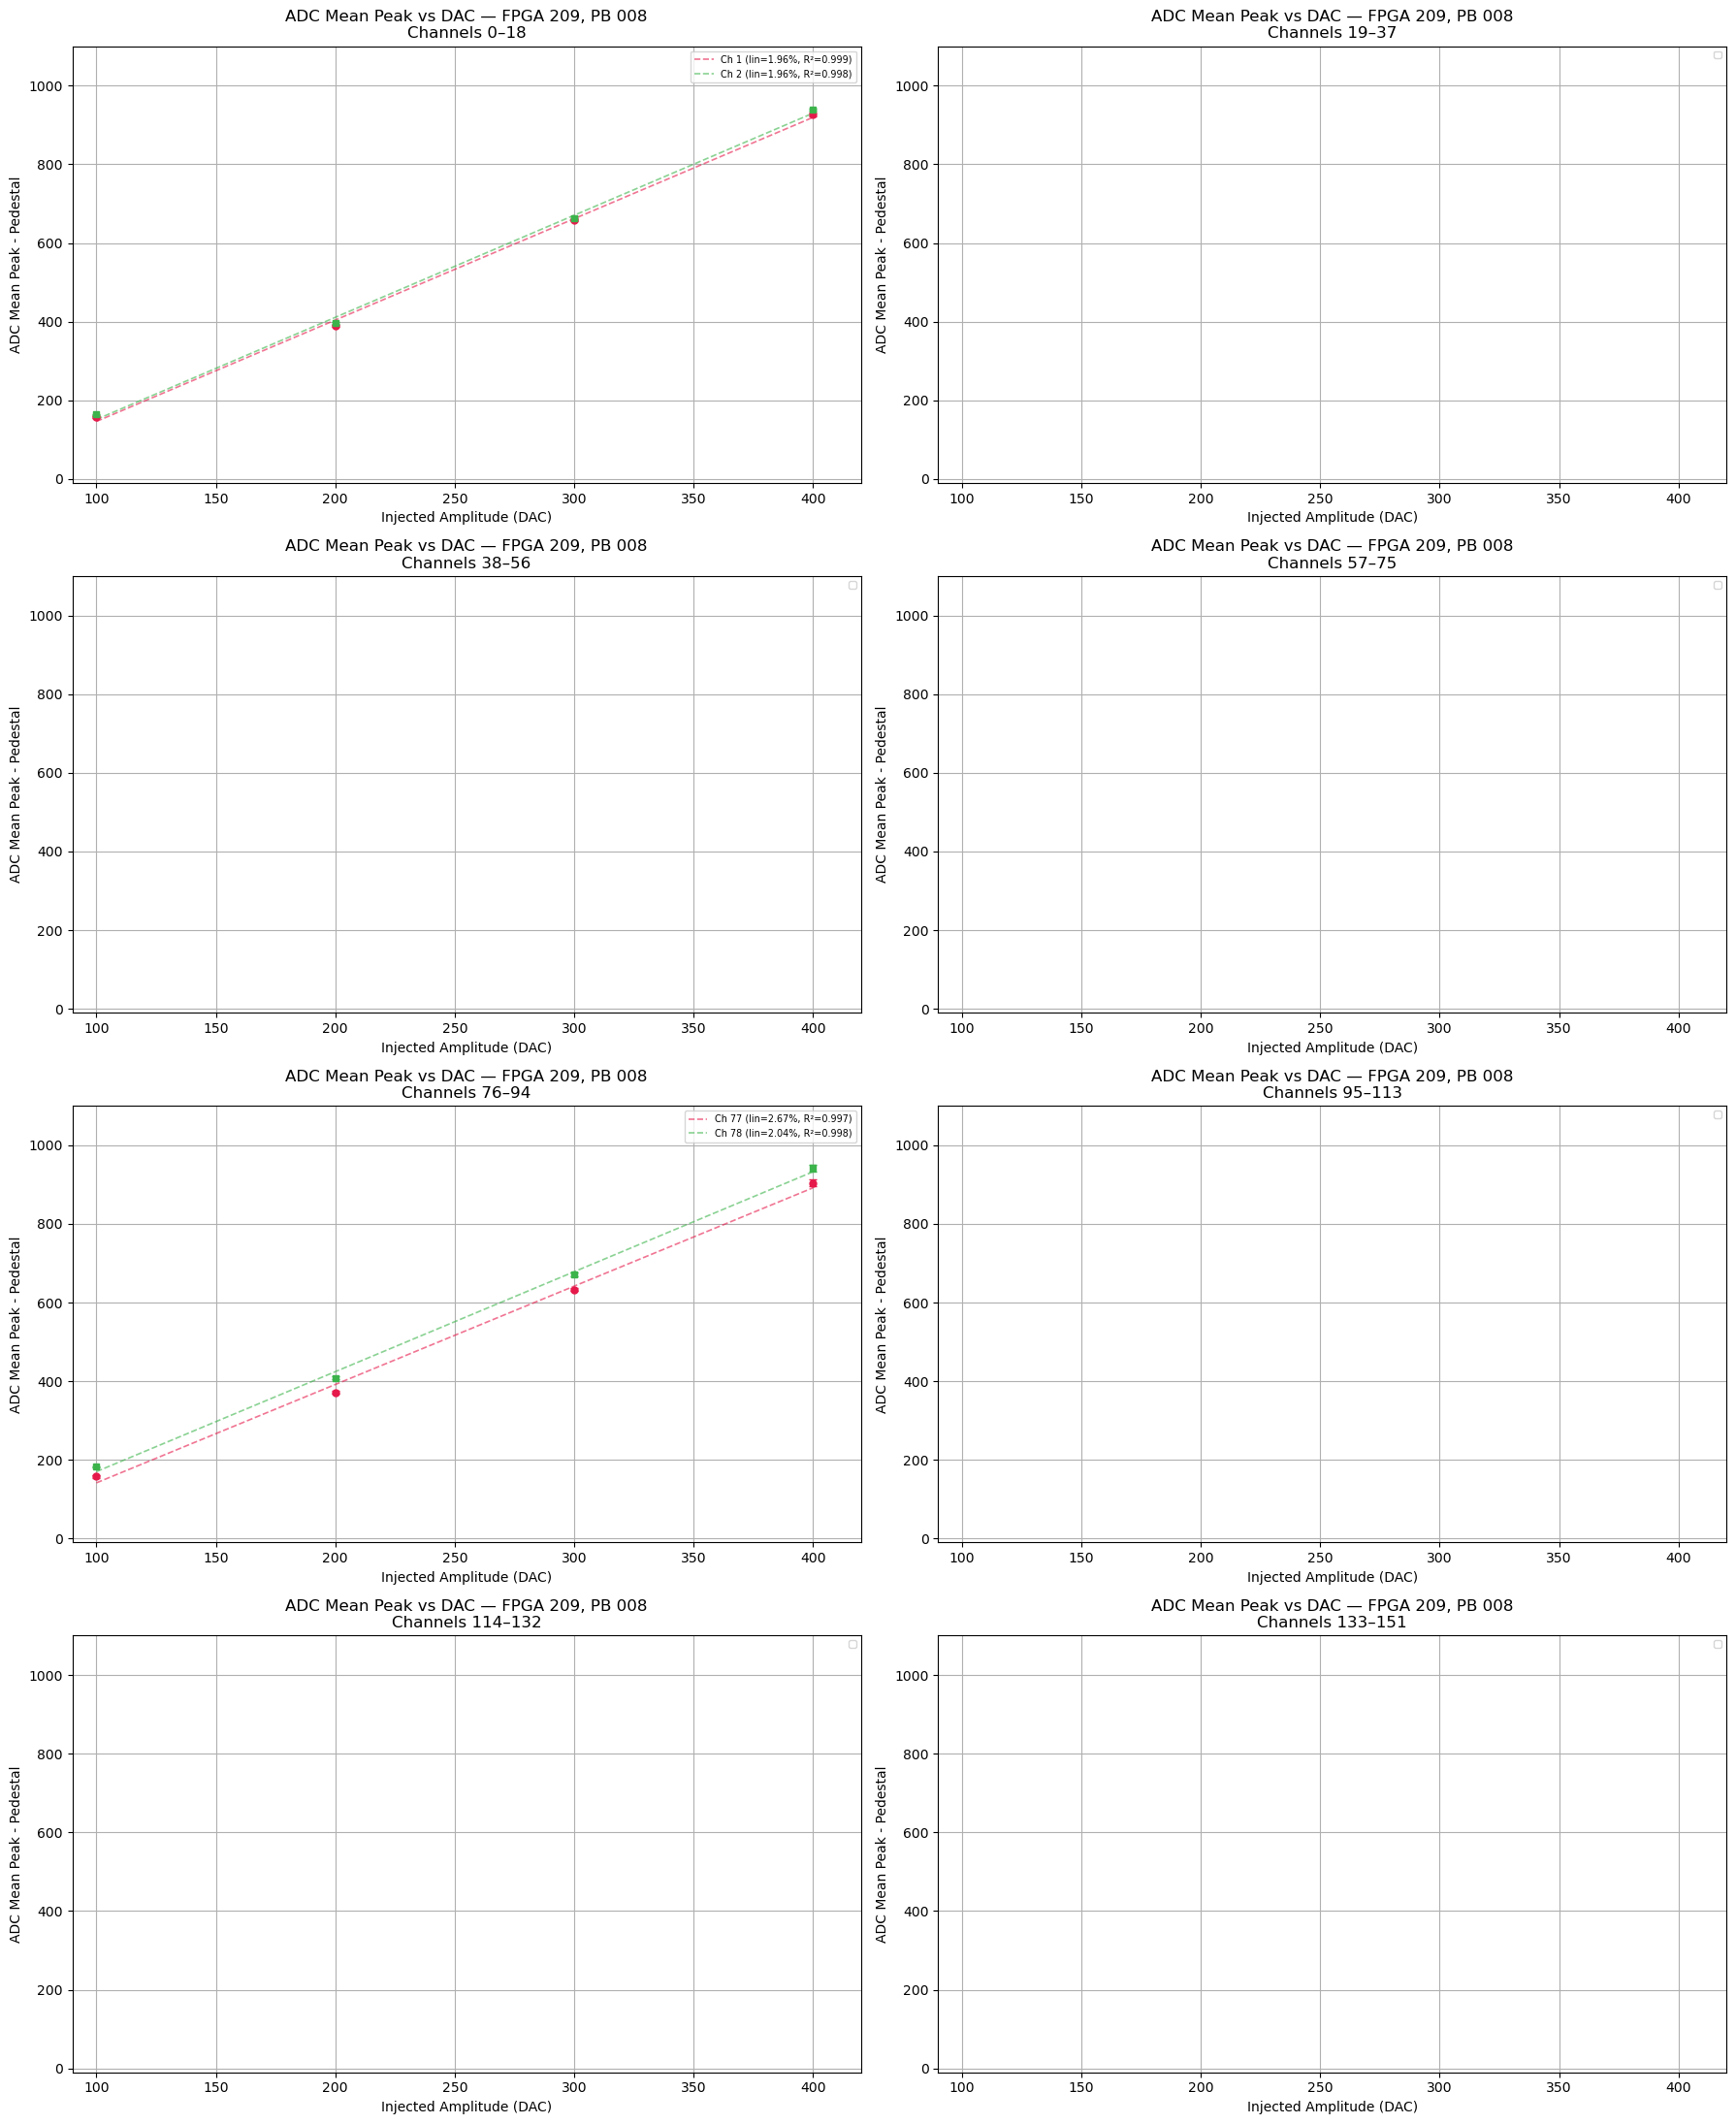


🟢 Good Linearity Channels (4 channels):
1, 2, 77, 78

🔴 Bad Linearity Channels (0 channels):


Percentage of Good Linearity Channels: 100.00%

Channel R² and linearity%:
Channel 1: R² = 0.999, linearity = 1.96%
Channel 2: R² = 0.998, linearity = 1.96%
Channel 77: R² = 0.997, linearity = 2.67%
Channel 78: R² = 0.998, linearity = 2.04%

🟢 Channels with linearity ≤ 10.0% (deviation-based) (4 channels):
1, 2, 77, 78

🔴 Channels with linearity  > 10.0% (0 channels):


Percentage of Good Linearity Channels (based ONLY on deviation < 10.0%): 100.00%

Saved ADC linearity plot to:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_209_pb008/ADC_Linearity_fpga209_pb008.png


In [196]:
fig, axs = plt.subplots(4, 2, figsize=(18, 22))
axs = axs.flatten()

for group_id in range(num_groups):
    ax = axs[group_id]
    first_channel = group_id * files_per_group
    last_channel = first_channel + files_per_group

    marker_index = 0  # will index both color_list and markers

    for ch in range(first_channel, last_channel):

        # Skip unwanted channels
        if (ch in dead_channels or
            ch in calibration_channels or
            ch in notConnected_channels or
            ch in manual_discarded_channels):
            continue

        # Select this channel's summary (mean & std over runs)
        df_ch = peaks_summary[peaks_summary["Channel"] == ch]
        if df_ch.empty:
            continue

        # Sort by amplitude
        df_ch = df_ch.sort_values("Amplitude")
        amps  = df_ch["Amplitude"].values
        means = df_ch["mean"].values
        stds  = df_ch["std"].values

        if len(amps) < 2:
            # not enough points to fit a line
            continue

        # Pick color & marker for THIS channel
        color  = color_list[marker_index % len(color_list)]
        marker = markers[marker_index % len(markers)]

        # --- Scatter + error bars: one per channel ---
        ax.errorbar(
            amps, means,
            yerr=stds,
            fmt=marker,
            markersize=5,
            capsize=3,
            color=color,
            ecolor=color,
            linestyle="none",  # no connecting line here
        )

        # --- Linear regression for THIS channel ---
        slope, intercept, r_value, p_value, std_err = linregress(amps, means)
        r2 = r_value ** 2
        
        # --- Deviation-based linearity  ---
        fit_vals = slope * amps + intercept
        deviations = means - fit_vals
        max_deviation = np.max(np.abs(deviations))
        full_scale = np.max(means) - np.min(means)
        
        if full_scale > 0:
            linearity_percentage = max_deviation / full_scale * 100
        else:
            linearity_percentage = 0.0
            
        # Store in dicts
        channel_r2_dict[ch] = r2
        channel_linperc_dict[ch] = linearity_percentage
        
        # --- Classify good / bad linearity ---
        if r2 >= acceptance_value:
            good_linearity_channels.append(ch)
        else:
            bad_linearity_channels.append(ch)

        x_line = np.linspace(amps.min(), amps.max(), 200)
        y_line = slope * x_line + intercept

        # Regression line: same color, dashed, slightly transparent
        ax.plot(
            x_line, y_line,
            linestyle="--",
            linewidth=1.2,
            alpha=0.6,
            color=color,
            label=f"Ch {ch} (lin={linearity_percentage:.2f}%, R²={r2:.3f})"
        )

        marker_index += 1

    ax.set_title(
        f"ADC Mean Peak vs DAC — FPGA {fpga_adc_mean}, PB {pb_adc_mean}\n"
        f"Channels {first_channel}–{last_channel - 1}"
    )
    ax.set_xlabel("Injected Amplitude (DAC)")
    ax.set_ylabel("ADC Mean Peak - Pedestal")
    ax.set_ylim(-10, 1100)
    ax.set_xlim(min(CONFIG['amplitudes']) - 10,
                max(CONFIG['amplitudes']) + 20)
    ax.grid(True)
    ax.legend(fontsize="x-small", markerscale=1)

plt.tight_layout()
plt.show()

# -------- Summary printouts --------
def print_channel_list(label, channels):
    chs = sorted(set(channels))
    print(f"\n{label} ({len(chs)} channels):")
    print(", ".join(str(int(c)) for c in chs))

print_channel_list(f"🟢 Good Linearity Channels", good_linearity_channels)
print_channel_list("🔴 Bad Linearity Channels", bad_linearity_channels)

# Percentage (using actually evaluated channels)
all_evaluated = (
    set(good_linearity_channels)
    | set(bad_linearity_channels)
    | set(manual_discarded_channels)
)

total_channels_eval = len(all_evaluated)

percentage_good = (
    len(set(good_linearity_channels)) / total_channels_eval * 100
    if total_channels_eval > 0 else 0
)
print(f"\nPercentage of Good Linearity Channels: {percentage_good:.2f}%")

print("\nChannel R² and linearity%:")
for channel in sorted(all_evaluated):
    r2 = channel_r2_dict.get(channel, float("nan"))
    linp = channel_linperc_dict.get(channel, float("nan"))
    print(f"Channel {channel}: R² = {r2:.3f}, linearity = {linp:.2f}%")
    
# ==============================
# Linearity-based criteria
# ==============================

# Channels for which we actually computed a linearity percentage
evaluated_for_lin = set(channel_linperc_dict.keys())

good_linearity_by_lin  = []
bad_linearity_by_lin   = []

for ch in evaluated_for_lin:
    linp = channel_linperc_dict.get(ch, float("nan"))
    if np.isnan(linp):
        continue
    if linp < linearity_target:
        good_linearity_by_lin.append(ch)
    else:
        bad_linearity_by_lin.append(ch)

print_channel_list(
    f"🟢 Channels with linearity ≤ {linearity_target:.1f}% (deviation-based)",
    good_linearity_by_lin,
)
print_channel_list(
    f"🔴 Channels with linearity  > {linearity_target:.1f}%",
    bad_linearity_by_lin,
)

total_lin_eval = len(good_linearity_by_lin) + len(bad_linearity_by_lin) + len(manual_discarded_channels)
percentage_good_lin = (
    len(good_linearity_by_lin) / total_lin_eval * 100
    if total_lin_eval > 0 else 0
)
print(
    f"\nPercentage of Good Linearity Channels "
    f"(based ONLY on deviation < {linearity_target:.1f}%): "
    f"{percentage_good_lin:.2f}%"
)

    
# ========= Save ADC linearity plot =========
output_dir_adc_lin = os.path.join(
    CONFIG["base_path"],
    f"images/FPGA_{fpga_adc_mean}_pb{pb_adc_mean}"
)
os.makedirs(output_dir_adc_lin, exist_ok=True)

output_path_adc_lin = os.path.join(
    output_dir_adc_lin,
    f"ADC_Linearity_fpga{fpga_adc_mean}_pb{pb_adc_mean}.png"
)

fig.savefig(output_path_adc_lin, dpi=200)
print(f"\nSaved ADC linearity plot to:\n  {output_path_adc_lin}")


### Manually Discarded Channels (Unstable, Noisy, Unwanted, etc.)

In [197]:
# add_discard(pair_id_mean, 34, 39, 40, 41, 103)

print(manual_discarded_by_pair)


{}


### Saving the linearity and $R^2$ Values

In [198]:
# --- Folder where ADC peaks are saved ---
output_csv_peaks_path = os.path.join(
    "/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025",
    "ADC_Peaks"
)

# Create folder if missing
os.makedirs(output_csv_peaks_path, exist_ok=True)

# --- Build dataframe from channel → (r2, linearity%) ---
summary_data = []

for ch in sorted(channel_r2_dict.keys()):
    r2 = channel_r2_dict.get(ch, float("nan"))
    linp = channel_linperc_dict.get(ch, float("nan"))
    summary_data.append({
        "Channel": ch,
        "R2": r2,
        "Linearity_percent": linp,
        "GoodLinearity": ch in good_linearity_channels,
    })

summary_df = pd.DataFrame(summary_data)

# --- Build a filename ---
csv_filename = f"ADC_LinearitySummary_fpga{fpga_adc_mean}_pb{pb_adc_mean}.csv"

# --- Full path ---
csv_path = os.path.join(output_csv_peaks_path, csv_filename)

# --- Save CSV ---
summary_df.to_csv(csv_path, index=False)

print("\nSaved ADC linearity summary to:")
print(csv_path)



Saved ADC linearity summary to:
/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/ADC_Peaks/ADC_LinearitySummary_fpga209_pb008.csv


## Linearity ToT All Channels

### Get the best phase for this FPGA–PB pair

Computing best phase for FPGA 209, PB 8 (pair_id = 1)


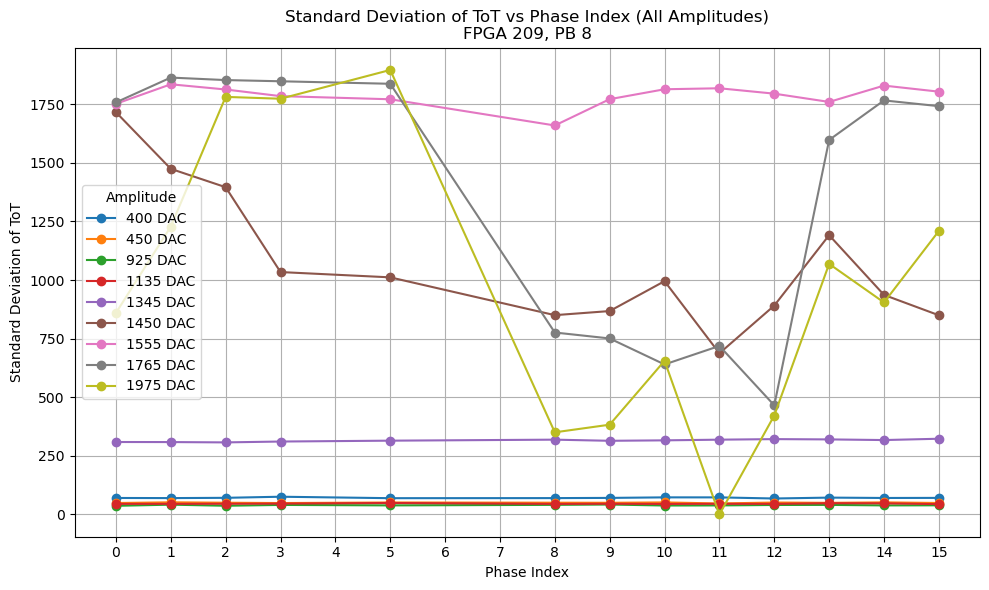

Best-phase plot saved to:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_209_pb008/best_phase_tot_fpga209_pb008.png
The best phase across all channels and amplitudes is: Phase 11 with score 3747.40
The second best phase is: Phase 12 with score 4099.91
Best phases in order of score (lower = better):
  Phase 11: 3747.40
  Phase 12: 4099.91
  Phase 8: 4161.40
  Phase 9: 4296.01
  Phase 10: 4627.88
  Phase 14: 5961.78
  Phase 15: 6129.72
  Phase 13: 6147.60
  Phase 0: 6594.96
  Phase 1: 6917.93
  Phase 3: 6961.64
  Phase 5: 7038.34
  Phase 2: 7353.64
Best phase for this pair: 11


In [199]:
# Compute best phase for this pair 
best_phase_tot, second_best_tot, phase_scores_tot = get_best_phase_tot(
    pair_id=pair_id_tot_mean,
    make_plot=True,
    save_plot=True,
)
print("Best phase for this pair:", best_phase_tot)


### Build a summary of ToT vs amplitude at best phase

In [200]:
# Pick the right manual-discard list for this FPGA–PB pair
manual_discarded_channels = manual_discarded_by_pair.get(
    (fpga_tot_mean, pb_tot_mean),
    set()  # default: no manual discards if pair not in dict
)
print("Manual discarded channels for this pair:", manual_discarded_channels)


Manual discarded channels for this pair: set()


In [201]:
# ===============================
# Build ToT summary at best phase
# ===============================

# Timing constants (must match best-phase computation!)
sample_time_interval = 25.0
phase_time_interval = sample_time_interval / 16.0
phase_offset = 7

# Pair info
fpga_tot_mean, pb_tot_mean = CONFIG_TOT["fpga_pb_pairs"][pair_id_tot_mean]
pair_key_tot_mean = f"fpga{fpga_tot_mean}_pb{pb_tot_mean}"

print(f"Building ToT best-phase summary for FPGA {fpga_tot_mean}, PB {pb_tot_mean}")
print("Best phase used:", best_phase_tot)

rows_tot = []  # will store dicts: Channel, Amplitude, mean, std

# Loop over all channels, grouped like in ADC plots
for group_id in range(num_groups):
    first_channel = group_id * files_per_group
    last_channel = first_channel + files_per_group

    for ch in range(first_channel, last_channel):

        # Skip unwanted channels
        if (ch in dead_channels or
            ch in calibration_channels or
            ch in notConnected_channels or
            ch in manual_discarded_channels):
            continue

        # For this channel, collect (per amplitude) the mean ToT over runs
        for amp in CONFIG_TOT["amplitudes"]:
            # Get all run files for this amplitude
            try:
                run_files = all_dirs_tot[pair_key_tot_mean][amp]
            except KeyError:
                print(f"No ToT files for pair {pair_key_tot_mean}, amp {amp}")
                continue

            per_run_means = []

            for run_idx, file_path in run_files.items():
                if not os.path.exists(file_path):
                    print(f"Missing ToT file: {file_path}")
                    continue

                df = pd.read_csv(file_path)
                df.columns = df.columns.str.strip()

                # First filter on channel and exclude bad Phase values
                ch_data = df[
                    (df["Channel"] == ch) &
                    (~df["Phase"].isin([4, 6, 7]))
                ]
                if ch_data.empty:
                    continue

                # Compute derived phase index from time
                t_vals = ch_data["Time"].values
                tot_vals = ch_data["TOT_12bit"].values

                # Drop ToT=0
                mask_nonzero = (tot_vals != 0)
                t_vals = t_vals[mask_nonzero]
                tot_vals = tot_vals[mask_nonzero]

                if len(t_vals) == 0:
                    continue

                # Compute phase index from time
                phase_indices = (
                    ((t_vals % sample_time_interval) / phase_time_interval)
                    + phase_offset
                ).astype(int) % 16

                # Keep only entries at the best phase
                mask_best = (phase_indices == best_phase_tot)
                if not np.any(mask_best):
                    continue

                tot_best_phase = tot_vals[mask_best]

                if len(tot_best_phase) == 0:
                    continue

                # Mean ToT for this run, channel, amplitude at best phase
                run_mean = np.mean(tot_best_phase)
                per_run_means.append(run_mean)

            # After looping all runs for this channel & amplitude
            if len(per_run_means) == 0:
                continue

            amp_mean = float(np.mean(per_run_means))
            amp_std  = float(np.std(per_run_means, ddof=1)) if len(per_run_means) > 1 else 0.0

            rows_tot.append({
                "Channel": ch,
                "Amplitude": amp,
                "mean": amp_mean,
                "std": amp_std,
            })

# Build the summary DataFrame
tot_summary = pd.DataFrame(rows_tot)
print("ToT summary (first rows):")
display(tot_summary.head())


Building ToT best-phase summary for FPGA 209, PB 008
Best phase used: 11
ToT summary (first rows):


,Channel,Amplitude,mean,std
0,1,400,841.6,10.430724
1,1,450,1006.4,6.693280
2,1,925,1622.4,6.693280
3,1,1135,1769.6,6.693280
4,1,1345,1363.2,7.155418


#### Saving Best Phase in ToT Region

In [202]:
# ===========================
# Save ToT best-phase summary
# ===========================

# Define output directory (one per FPGA–PB pair)
output_dir_bestphase = os.path.join(
    CONFIG_TOT["base_path"],
    f"ToT_BestPhases/FPGA_{fpga_tot_mean}_pb{pb_tot_mean}"
)

# Create directory if it doesn't exist
os.makedirs(output_dir_bestphase, exist_ok=True)

# Construct filename
output_csv_path = os.path.join(
    output_dir_bestphase,
    f"ToT_BestPhase_summary_fpga{fpga_tot_mean}_pb{pb_tot_mean}.csv"
)

# Save CSV
tot_summary.to_csv(output_csv_path, index=False)

print(f"\nSaved ToT best-phase summary CSV to:\n  {output_csv_path}")



Saved ToT best-phase summary CSV to:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/ToT_BestPhases/FPGA_209_pb008/ToT_BestPhase_summary_fpga209_pb008.csv


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Manual discarded channels for this pair: set()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


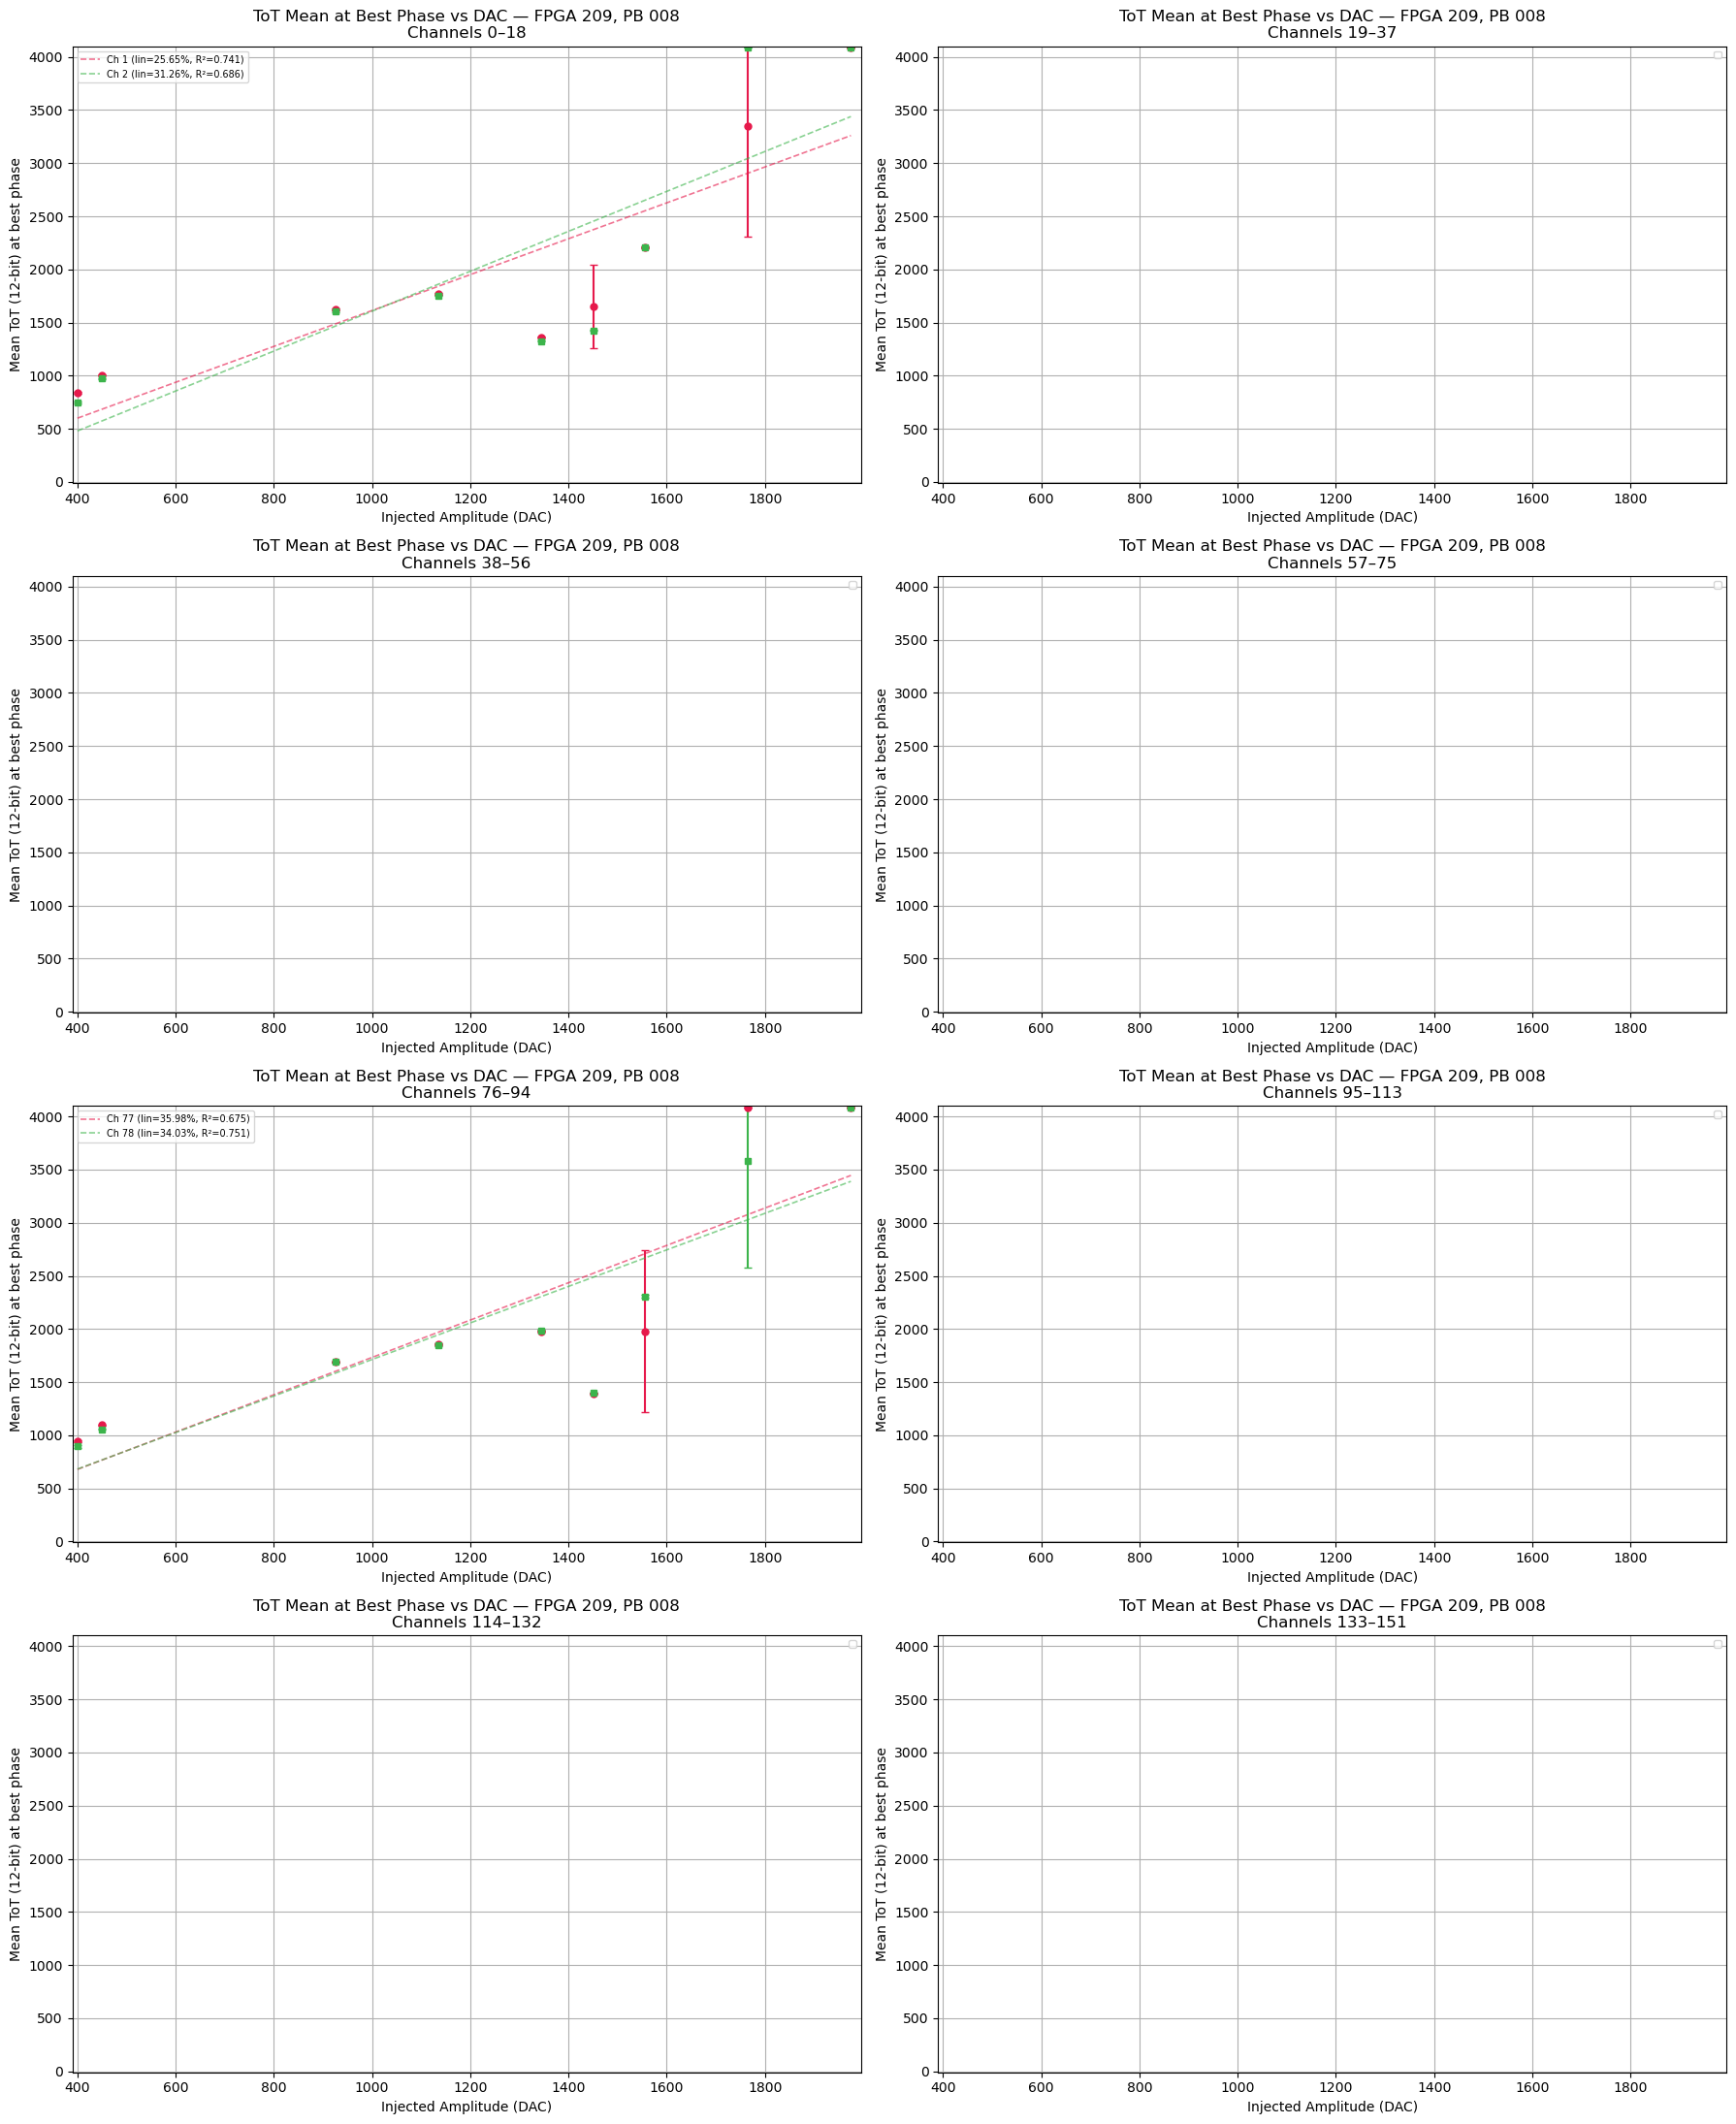


🟢 Good ToT Linearity Channels  (by R²) (0 channels):


🔴 Bad ToT Linearity Channels  (by R²) (4 channels):
1, 2, 77, 78

Percentage of Good ToT Linearity Channels: 0.00%

ToT Channel R² and linearity%:
Channel 1: R² = 0.741, linearity = 25.65%
Channel 2: R² = 0.686, linearity = 31.26%
Channel 77: R² = 0.675, linearity = 35.98%
Channel 78: R² = 0.751, linearity = 34.03%

🟢 ToT channels with linearity ≤ 10.0% (deviation-based) (0 channels):


🔴 ToT channels with linearity  > 10.0% (4 channels):
1, 2, 77, 78

Percentage of Good ToT Linearity Channels (based ONLY on deviation < 10.0%): 0.00%

Saved ToT linearity plot to:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_209_pb008/ToT_Linearity_fpga209_pb008.png


In [203]:
# ==========================
# ToT linearity at best phase
# ==========================

fig, axs = plt.subplots(4, 2, figsize=(18, 22))
axs = axs.flatten()

# Pick the right manual-discard list for this FPGA–PB pair (optional)
manual_discarded_channels = manual_discarded_by_pair.get(
    (fpga_tot_mean, pb_tot_mean),
    set()
)
print("Manual discarded channels for this pair:", manual_discarded_channels)

# Dicts to store per-channel metrics
tot_channel_r2_dict = {}
tot_channel_linperc_dict = {}
tot_good_linearity_channels = []  # by R² criterion
tot_bad_linearity_channels = []

# You can reuse your ADC acceptance_value, or define one here
# acceptance_value = 0.99  # for example

for group_id in range(num_groups):
    ax = axs[group_id]
    first_channel = group_id * files_per_group
    last_channel = first_channel + files_per_group

    marker_index = 0  # will index both color_list and markers

    for ch in range(first_channel, last_channel):

        # Skip unwanted channels
        if (ch in dead_channels or
            ch in calibration_channels or
            ch in notConnected_channels or
            ch in manual_discarded_channels):
            continue

        # Select this channel's summary (mean & std over amplitudes)
        df_ch = tot_summary[tot_summary["Channel"] == ch]
        if df_ch.empty:
            continue

        # Sort by amplitude
        df_ch = df_ch.sort_values("Amplitude")
        amps  = df_ch["Amplitude"].values
        means = df_ch["mean"].values
        stds  = df_ch["std"].values

        if len(amps) < 2:
            # not enough points to fit a line
            continue

        # Pick color & marker for THIS channel
        color  = color_list[marker_index % len(color_list)]
        marker = markers[marker_index % len(markers)]

        # --- Scatter + error bars: one per channel ---
        ax.errorbar(
            amps, means,
            yerr=stds,
            fmt=marker,
            markersize=5,
            capsize=3,
            color=color,
            ecolor=color,
            linestyle="none",
        )

        # --- Linear regression for THIS channel ---
        slope, intercept, r_value, p_value, std_err = linregress(amps, means)
        r2 = r_value ** 2

        # --- Deviation-based linearity  ---
        fit_vals = slope * amps + intercept
        deviations = means - fit_vals
        max_deviation = np.max(np.abs(deviations))
        full_scale = np.max(means) - np.min(means)

        if full_scale > 0:
            linearity_percentage = max_deviation / full_scale * 100
        else:
            linearity_percentage = 0.0

        # Store in dicts
        tot_channel_r2_dict[ch] = r2
        tot_channel_linperc_dict[ch] = linearity_percentage

        # --- Classify good / bad linearity ---
        if r2 >= acceptance_value:
            tot_good_linearity_channels.append(ch)
        else:
            tot_bad_linearity_channels.append(ch)

        x_line = np.linspace(amps.min(), amps.max(), 200)
        y_line = slope * x_line + intercept

        # Regression line: same color, dashed, slightly transparent
        ax.plot(
            x_line, y_line,
            linestyle="--",
            linewidth=1.2,
            alpha=0.6,
            color=color,
            label=f"Ch {ch} (lin={linearity_percentage:.2f}%, R²={r2:.3f})"
        )

        marker_index += 1

    ax.set_title(
        f"ToT Mean at Best Phase vs DAC — FPGA {fpga_tot_mean}, PB {pb_tot_mean}\n"
        f"Channels {first_channel}–{last_channel - 1}"
    )
    ax.set_xlabel("Injected Amplitude (DAC)")
    ax.set_ylabel("Mean ToT (12-bit) at best phase")
    ax.set_ylim(-10, 4100)
    ax.set_xlim(min(CONFIG_TOT["amplitudes"]) - 10,
                max(CONFIG_TOT["amplitudes"]) + 20)
    ax.grid(True)
    ax.legend(fontsize="x-small", markerscale=1)

plt.tight_layout()
plt.show()

# -------- Summary printouts --------
def print_channel_list(label, channels):
    chs = sorted(set(channels))
    print(f"\n{label} ({len(chs)} channels):")
    print(", ".join(str(int(c)) for c in chs))

print_channel_list("🟢 Good ToT Linearity Channels  (by R²)", tot_good_linearity_channels)
print_channel_list("🔴 Bad ToT Linearity Channels  (by R²)", tot_bad_linearity_channels)

# Percentage (using actually evaluated channels)
all_evaluated_tot = set(tot_good_linearity_channels) | set(tot_bad_linearity_channels)
total_channels_eval_tot = len(all_evaluated_tot)
percentage_good_tot = (
    len(set(tot_good_linearity_channels)) / total_channels_eval_tot * 100
    if total_channels_eval_tot > 0 else 0
)
print(f"\nPercentage of Good ToT Linearity Channels: {percentage_good_tot:.2f}%")

print("\nToT Channel R² and linearity%:")
for channel in sorted(all_evaluated_tot):
    r2 = tot_channel_r2_dict.get(channel, float("nan"))
    linp = tot_channel_linperc_dict.get(channel, float("nan"))
    print(f"Channel {channel}: R² = {r2:.3f}, linearity = {linp:.2f}%")

# ==============================
# Linearity-based criteria (ToT)
# ==============================

evaluated_for_lin_tot = set(tot_channel_linperc_dict.keys())

tot_good_linearity_by_lin = []
tot_bad_linearity_by_lin  = []

for ch in evaluated_for_lin_tot:
    linp = tot_channel_linperc_dict.get(ch, float("nan"))
    if np.isnan(linp):
        continue
    if linp <= linearity_target:
        tot_good_linearity_by_lin.append(ch)
    else:
        tot_bad_linearity_by_lin.append(ch)

print_channel_list(
    f"🟢 ToT channels with linearity ≤ {linearity_target:.1f}% (deviation-based)",
    tot_good_linearity_by_lin,
)
print_channel_list(
    f"🔴 ToT channels with linearity  > {linearity_target:.1f}%",
    tot_bad_linearity_by_lin,
)

total_lin_eval_tot = (
    len(tot_good_linearity_by_lin)
    + len(tot_bad_linearity_by_lin)
    + len(manual_discarded_channels)
)
percentage_good_lin_tot = (
    len(tot_good_linearity_by_lin) / total_lin_eval_tot * 100
    if total_lin_eval_tot > 0 else 0
)
print(
    f"\nPercentage of Good ToT Linearity Channels "
    f"(based ONLY on deviation < {linearity_target:.1f}%): "
    f"{percentage_good_lin_tot:.2f}%"
)

# ========= Save ToT linearity figure =========
output_dir_tot_lin = os.path.join(
    CONFIG_TOT["base_path"],
    f"images/FPGA_{fpga_tot_mean}_pb{pb_tot_mean}"
)
os.makedirs(output_dir_tot_lin, exist_ok=True)

output_path_tot_lin = os.path.join(
    output_dir_tot_lin,
    f"ToT_Linearity_fpga{fpga_tot_mean}_pb{pb_tot_mean}.png"
)

fig.savefig(output_path_tot_lin, dpi=200)
print(f"\nSaved ToT linearity plot to:\n  {output_path_tot_lin}")


### Manually Discarded Channels (Unstable, Noisy, Unwanted, etc.)

In [66]:
# add_discard(pair_id_tot_mean, 21, 39, 90, 96)

print(manual_discarded_by_pair)


{}


### Saving Linearity ToT and $R^2$

In [164]:
# === Save plot ===
tot_output_dir_linearity = os.path.join(
    CONFIG_TOT["base_path"],
    f"ToT_BestPhases/FPGA_{fpga_tot_mean}_pb{pb_tot_mean}"
)
os.makedirs(tot_output_dir_linearity, exist_ok=True)

# --- Build dataframe from channel → (r2, linearity%) ---
tot_summary_data = []

for ch in sorted(tot_channel_r2_dict.keys()):
    r2 = tot_channel_r2_dict.get(ch, float("nan"))
    linp = tot_channel_linperc_dict.get(ch, float("nan"))
    tot_summary_data.append({
        "Channel": ch,
        "R2": r2,
        "Linearity_percent": linp,
        "GoodLinearity": ch in good_linearity_channels,
    })

tot_summary_df = pd.DataFrame(tot_summary_data)

# --- Build a filename ---
tot_csv_filename = f"ToT_LinearitySummary_fpga{fpga_tot_mean}_pb{pb_tot_mean}.csv"

# --- Full path ---
tot_csv_path = os.path.join(
    tot_output_dir_linearity,
    tot_csv_filename
)

# --- Save CSV ---
tot_summary_df.to_csv(tot_csv_path, index=False)

print("\nSaved ADC linearity summary to:")
print(tot_csv_path)



Saved ADC linearity summary to:
/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/ToT_BestPhases/FPGA_208_pb008/ToT_LinearitySummary_fpga208_pb008.csv


## Comparing ADC and ToT Regions for One Channel

### Extract ToT Mean at Best Phase (per run)

In [204]:
def extract_tot_bestphase_per_run(
    all_dirs_pair_tot,
    channel,
    best_phase,
    sample_time_interval=25.0,
    phase_offset=7,
    exclude_phases=(4, 6, 7),
):
    """
    For one channel, compute the mean ToT at the best phase
    for each amplitude and each run.

    Parameters
    ----------
    all_dirs_pair_tot : dict
        Dictionary for one FPGA–PB pair (ToT):
        { amplitude : { run_idx : file_path } }

    channel : int
        Channel to analyse.

    best_phase : int
        Best phase index (0–15) to select.

    Returns
    -------
    df_tot_runs : pandas.DataFrame
        Columns:
            - "Amplitude"
            - "Run"
            - "ToT_bestphase_mean"
    """
    phase_time_interval = sample_time_interval / 16.0
    rows = []

    for amplitude, runs_dict in all_dirs_pair_tot.items():
        for run_idx, run_file in runs_dict.items():
            if not os.path.exists(run_file):
                print(f"[ToT] File not found: {run_file}")
                continue

            df = pd.read_csv(run_file)
            df.columns = df.columns.str.strip()

            if not {"Channel", "Phase", "Time", "TOT_12bit"}.issubset(df.columns):
                print(f"[ToT] Missing required columns in {run_file}")
                continue

            # Filter channel & remove unwanted phases from the Phase column
            ch_data = df[
                (df["Channel"] == channel) &
                (~df["Phase"].isin(exclude_phases))
            ]

            if ch_data.empty:
                continue

            # Drop ToT = 0
            ch_data = ch_data[ch_data["TOT_12bit"] != 0]
            if ch_data.empty:
                continue

            # Compute derived phase index from Time
            t_vals = ch_data["Time"].values
            phase_indices = (
                ((t_vals % sample_time_interval) / phase_time_interval)
                + phase_offset
            ).astype(int) % 16

            # Keep only entries at the best phase
            mask_best = (phase_indices == best_phase)
            if not mask_best.any():
                continue

            tot_best = ch_data["TOT_12bit"].values[mask_best]
            if len(tot_best) == 0:
                continue

            run_mean = float(np.mean(tot_best))

            rows.append({
                "Amplitude": amplitude,
                "Run": run_idx,
                "ToT_bestphase_mean": run_mean,
            })

    df_tot_runs = pd.DataFrame(rows)
    return df_tot_runs


### Build ToT and ADC Summaries for One Channel and One Pair

In [205]:
# ========= User choices =========
channel_to_plot = 2          # choose your channel
pair_id_plot   = pair_id_tot_mean   # use same pair as your ToT mean config


In [206]:
# --- Get pair info (ADC & ToT share the same mapping) ---
# --- Get FPGA–PB from both configs ---
fpga_adc_plot, pb_adc_plot = CONFIG["fpga_pb_pairs"][pair_id_plot]
fpga_tot_plot, pb_tot_plot = CONFIG_TOT["fpga_pb_pairs"][pair_id_plot]

# --- Safety check: PB must match (FPGA can differ) ---
if pb_adc_plot != pb_tot_plot:
    raise ValueError(
        f"[ERROR] PB mismatch between ADC and ToT for pair_id={pair_id_plot}:\n"
        f"  ADC config    → FPGA {fpga_adc_plot}, PB {pb_adc_plot}\n"
        f"  ToT config    → FPGA {fpga_tot_plot}, PB {pb_tot_plot}\n"
        f"PB must be the SAME for the combined ToT+ADC plot."
    )

print(f"Using PB {pb_adc_plot} (ADC FPGA {fpga_adc_plot}, ToT FPGA {fpga_tot_plot})")

pair_key_adc_plot = f"fpga{fpga_adc_plot}_pb{pb_adc_plot}"
pair_key_tot_plot = f"fpga{fpga_tot_plot}_pb{pb_tot_plot}"

print(f"Plotting channel {channel_to_plot} for FPGA {fpga_adc_plot}, PB {pb_adc_plot}")

# --- 1) Best phase from ToT ---
best_phase_tot, second_best_tot, phase_scores_tot = get_best_phase_tot(
    pair_id=pair_id_plot,
    make_plot=False,
    save_plot=False,
)
print("Best phase used:", best_phase_tot)

# --- 2) ToT per run at best phase ---
all_dirs_pair_tot = all_dirs_tot[pair_key_tot_plot]
df_tot_runs = extract_tot_bestphase_per_run(
    all_dirs_pair_tot=all_dirs_pair_tot,
    channel=channel_to_plot,
    best_phase=best_phase_tot,
)

if df_tot_runs.empty:
    print("[ToT] No ToT data at best phase for this channel.")
else:
    # Group by amplitude to get mean±std over runs
    tot_summary_ch = (
        df_tot_runs
        .groupby("Amplitude")["ToT_bestphase_mean"]
        .agg(["mean", "std"])
        .reset_index()
        .rename(columns={"mean": "ToT_mean", "std": "ToT_std"})
    )
    print("ToT summary for this channel:")
    display(tot_summary_ch)

# --- 3) ADC per run (pedestal-subtracted) ---

# Build pedestal_map for this FPGA–PB pair using pedestal CSV
# Pedestal map for this pair (using CONFIG / pair_id_plot)
pedestal_map_plot = get_pedestal_map_by_pair_id(pair_id_plot)

print(
    f"Loaded {len(pedestal_map_plot)} pedestal values for pair "
    f"(FPGA {fpga_adc_plot}, PB {pb_adc_plot})"
)

# Combine ADC info from both ADC scans and ToT scans (for high amplitudes)
combined_adc_dirs = {}

# ADC-only runs (low DAC, e.g. 100–400)
if 'all_dirs' in globals():
    adc_pair_dict = all_dirs.get(pair_key_adc_plot, {})
    for amp, runs_dict in adc_pair_dict.items():
        combined_adc_dirs.setdefault(amp, {}).update(runs_dict)

# ToT runs also contain ADC column; use them for high DAC (e.g. 450+)
for amp, runs_dict in all_dirs_pair_tot.items():
    combined_adc_dirs.setdefault(amp, {}).update(runs_dict)

# Get ADC max per channel & run (pedestal-subtracted)
df_adc_max = get_adc_max_per_channel(
    all_dirs_pair=combined_adc_dirs,
    pedestal_map=pedestal_map_plot,
    amplitudes=None,             # use all available amplitudes
    fallback_pedestal=fallback_pedestal,
    exclude_phases=(4, 6, 7),
)

if df_adc_max.empty:
    print("[ADC] No ADC data found.")
else:
    # Filter to this channel and build mean±std per amplitude
    adc_ch = df_adc_max[df_adc_max["Channel"] == channel_to_plot]
    if adc_ch.empty:
        print(f"[ADC] No ADC data for channel {channel_to_plot}")
    else:
        adc_summary_ch = (
            adc_ch
            .groupby("Amplitude")["ADC_max_minus_ped"]
            .agg(["mean", "std"])
            .reset_index()
            .rename(columns={"mean": "ADC_mean", "std": "ADC_std"})
        )
        print("ADC summary for this channel:")
        display(adc_summary_ch)


Using PB 008 (ADC FPGA 209, ToT FPGA 209)
Plotting channel 2 for FPGA 209, PB 008
Computing best phase for FPGA 209, PB 8 (pair_id = 1)
The best phase across all channels and amplitudes is: Phase 11 with score 3747.40
The second best phase is: Phase 12 with score 4099.91
Best phases in order of score (lower = better):
  Phase 11: 3747.40
  Phase 12: 4099.91
  Phase 8: 4161.40
  Phase 9: 4296.01
  Phase 10: 4627.88
  Phase 14: 5961.78
  Phase 15: 6129.72
  Phase 13: 6147.60
  Phase 0: 6594.96
  Phase 1: 6917.93
  Phase 3: 6961.64
  Phase 5: 7038.34
  Phase 2: 7353.64
Best phase used: 11
ToT summary for this channel:


,Amplitude,ToT_mean,ToT_std
0,400,748.8,9.121403
1,450,972.8,4.381780
2,925,1604.8,12.132601
3,1135,1755.2,7.155418
4,1345,1326.4,3.577709
5,1450,1426.0,4.000000
6,1555,2211.2,5.019960
7,1765,4088.0,0.000000
8,1975,4088.0,0.000000


Loaded 144 pedestal values for pair (FPGA 209, PB 008)
ADC summary for this channel:


,Amplitude,ADC_mean,ADC_std
0,100,163.8,1.303840
1,200,395.8,2.683282
2,300,664.0,2.738613
3,400,939.2,1.788854
4,450,940.0,0.000000
5,925,940.0,0.000000
6,1135,940.0,0.000000
7,1345,940.0,0.000000
8,1450,940.0,0.000000
9,1555,940.0,0.000000


## Make the Combined ADC - ToT Plot

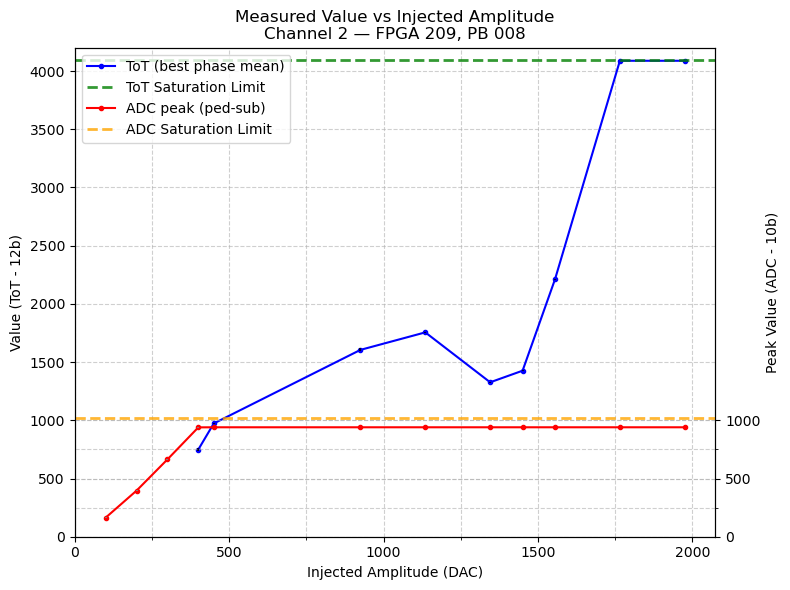

Saved combined ToT+ADC plot to:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_209_pb008/MeasuredValue_vs_Amplitude_Channel_2_fpga209_pb008.png


In [207]:
# ===========================
# Combined ToT + ADC plot
# ===========================

if df_tot_runs.empty or df_adc_max.empty:
    print("Cannot make combined plot: missing ToT or ADC data.")
else:
    # Align amplitudes (we allow different sets for ToT and ADC)
    amps_tot = tot_summary_ch["Amplitude"].values
    vals_tot = tot_summary_ch["ToT_mean"].values
    errs_tot = tot_summary_ch["ToT_std"].values

    amps_adc = adc_summary_ch["Amplitude"].values
    vals_adc = adc_summary_ch["ADC_mean"].values
    errs_adc = adc_summary_ch["ADC_std"].values

    fig, ax1 = plt.subplots(figsize=(8, 6))

    # --- Left axis: ToT ---
    line1 = ax1.plot(
        amps_tot,
        vals_tot,
        c="blue",
        marker=".",
        label="ToT (best phase mean)",
    )[0]

    ax1.errorbar(
        amps_tot,
        vals_tot,
        yerr=errs_tot,
        fmt="",
        linestyle="None",
        c="black",
        alpha=0.8,
    )

    ax1.set_xlabel("Injected Amplitude (DAC)")
    ax1.set_ylabel("Value (ToT - 12b)")
    ax1.set_ylim(0, 4200)
    ax1.set_xlim(0, max(max(amps_tot), max(amps_adc)) * 1.05)

    ax1.xaxis.set_major_locator(ticker.MultipleLocator(500))
    ax1.xaxis.set_minor_locator(ticker.MultipleLocator(250))
    ax1.grid(True, which="both", axis="both", linestyle="--", alpha=0.6)

    # ToT saturation line (optional)
    hline1 = ax1.axhline(
        y=4096,
        color="green",
        linestyle="--",
        linewidth=2,
        alpha=0.8,
        label="ToT Saturation Limit",
    )

    # --- Right axis: ADC ---
    ax2 = ax1.twinx()

    line2 = ax2.plot(
        amps_adc,
        vals_adc,
        c="red",
        marker=".",
        label="ADC peak (ped-sub)",
    )[0]

    # ADC error bars:
    ax2.errorbar(
        amps_adc,
        vals_adc,
        yerr=errs_adc,
        fmt="",
        linestyle="None",
        c="gray",
    )

    ax2.set_ylabel("Peak Value (ADC - 10b)")
    ax2.set_ylim(0, 4200)

    minor_ticks = list(range(0, 1024, 250))
    major_ticks = list(range(0, 1024, 500))
    ax2.set_yticks(major_ticks)
    ax2.set_yticks(minor_ticks, minor=True)
    ax2.yaxis.grid(True, which="both", linestyle="--", alpha=0.6)

    hline2 = ax2.axhline(
        y=1024,
        color="orange",
        linestyle="--",
        linewidth=2,
        alpha=0.8,
        label="ADC Saturation Limit",
    )

    # --- Title & legend ---
    plt.title(
        f"Measured Value vs Injected Amplitude\n"
        f"Channel {channel_to_plot} — FPGA {fpga_tot_plot}, PB {pb_tot_plot}"
    )

    lines = [line1, hline1, line2, hline2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc="upper left")

    plt.tight_layout()
    plt.show()

    # Optional: save figure
    output_dir_plot = os.path.join(
        CONFIG_TOT["base_path"],
        f"images/FPGA_{fpga_tot_plot}_pb{pb_tot_plot}"
    )
    os.makedirs(output_dir_plot, exist_ok=True)

    fig_path = os.path.join(
        output_dir_plot,
        f"MeasuredValue_vs_Amplitude_Channel_{channel_to_plot}_fpga{fpga_tot_plot}_pb{pb_tot_plot}.png"
    )
    fig.savefig(fig_path, dpi=200)
    print(f"Saved combined ToT+ADC plot to:\n  {fig_path}")


### Plot combined ToT(best-phase mean) + ADC(ped-subtracted peaks) for Different Channels

In [169]:
# Pick the right manual-discard list for this FPGA–PB pair (optional)
manual_discarded_channels = manual_discarded_by_pair.get(
    (fpga_tot_mean, pb_tot_mean),
    set()
)
print("Manual discarded channels for this pair:", manual_discarded_channels)


Manual discarded channels for this pair: set()


In [ ]:
def plot_tot_adc_for_channels(
    channels,
    pair_id,
    exclude_phases=(4, 6, 7),
    tot_ylim=(0, 4200),
    adc_ylim=(0, 4200),
    save_fig=False,
):
    """
    Plot combined ToT(best-phase mean) + ADC(ped-subtracted peaks)
    vs injected amplitude for several channels, arranged in a grid
    of 2 columns.

    Parameters
    ----------
    channels : list[int]
        List of channel numbers to plot. Can be [6], list(range(40,43)), etc.

    pair_id : int
        0 → (208,06), 1 → (209,008) according to CONFIG / CONFIG_TOT.

    exclude_phases : iterable
        Phases to exclude (default: [4,6,7]).

    tot_ylim : tuple
        (ymin, ymax) for ToT axis.

    adc_ylim : tuple
        (ymin, ymax) for ADC axis.

    save_fig : bool
        If True, saves the figure in the images/ folder for this FPGA–PB pair.
    """

    # --- FPGA–PB info ---
    fpga_adc, pb_adc = CONFIG["fpga_pb_pairs"][pair_id]
    fpga_tot, pb_tot = CONFIG_TOT["fpga_pb_pairs"][pair_id]

    # --- Safety check: PB must match (FPGA can differ) ---
    if pb_adc != pb_tot:
        raise ValueError(
            f"[ERROR] PB mismatch for pair_id={pair_id}:\n"
            f"  ADC config → FPGA {fpga_adc}, PB {pb_adc}\n"
            f"  ToT config → FPGA {fpga_tot}, PB {pb_tot}\n"
            f"PB must be the SAME to combine ToT and ADC."
        )

    pair_key_adc = f"fpga{fpga_adc}_pb{pb_adc}"
    pair_key_tot = f"fpga{fpga_tot}_pb{pb_tot}"

    print(
        f"Combined ToT+ADC for PB {pb_adc} "
        f"(ADC FPGA {fpga_adc}, ToT FPGA {fpga_tot})"
    )

    print(f"Plotting channels {channels} for FPGA {fpga_adc}, PB {pb_adc}")

    # --- Best phase for this pair (ToT) ---
    best_phase_tot, second_best, phase_scores = get_best_phase_tot(
        pair_id=pair_id,
        make_plot=False,
        save_plot=False,
    )
    print("Best phase (ToT) used:", best_phase_tot)

    # --- ToT directories for this pair ---
    all_dirs_pair_tot = all_dirs_tot[pair_key_tot]

    # --- Pedestals for this FPGA–PB pair (ADC) ---
    fpga_int = int(fpga_adc)
    pb_int   = int(pb_adc)
    ped_sub_plot = ped_df[(ped_df["FPGA"] == fpga_int) & (ped_df["PB"] == pb_int)]
    pedestal_map_plot = ped_sub_plot.set_index("Channel")["HV"].to_dict()
    print(f"Loaded {len(pedestal_map_plot)} pedestal values for FPGA {fpga_int}, PB {pb_int}")

    # --- Build combined ADC dirs: low-DAC ADC scan + high-DAC ToT scan ---
    combined_adc_dirs = {}

    # ADC scan (CONFIG amplitudes, e.g. 100–400)
    if "all_dirs" in globals():
        adc_pair_dict = all_dirs.get(pair_key_adc, {})
        for amp, runs_dict in adc_pair_dict.items():
            combined_adc_dirs.setdefault(amp, {}).update(runs_dict)

    # ToT scan (CONFIG_TOT amplitudes, e.g. 400, 450, 925, 1450, 1975)
    for amp, runs_dict in all_dirs_pair_tot.items():
        combined_adc_dirs.setdefault(amp, {}).update(runs_dict)

    # --- ADC max per channel & run (ped-sub) for this pair ---
    df_adc_max = get_adc_max_per_channel(
        all_dirs_pair=combined_adc_dirs,
        pedestal_map=pedestal_map_plot,
        amplitudes=None,
        fallback_pedestal=fallback_pedestal,
        exclude_phases=exclude_phases,
    )

    if df_adc_max.empty:
        print("[ADC] No ADC data found for this pair. Nothing to plot.")
        return

    # --- Prepare figure with N channels, 2 columns ---
    channels = list(channels)
    n_ch = len(channels)
    if n_ch == 0:
        print("No channels provided.")
        return

    ncols = 2
    nrows = math.ceil(n_ch / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4 * nrows), sharex=False)
    axes = np.array(axes).reshape(nrows, ncols)

    # --- Loop over channels and draw each subplot ---
    for idx, ch in enumerate(channels):
        row = idx // ncols
        col = idx % ncols
        ax1 = axes[row, col]

        # Skip dead/calibration/notConnected channels (you can comment this out if you want to force-plot them)
        if (ch in dead_channels or
            ch in calibration_channels or
            ch in notConnected_channels or 
            ch in manual_discarded_channels):
            ax1.set_title(f"Channel {ch} (discarded)")
            ax1.axis("off")
            continue

        # -------- ToT: best phase mean per amplitude for this channel --------
        df_tot_runs = extract_tot_bestphase_per_run(
            all_dirs_pair_tot=all_dirs_pair_tot,
            channel=ch,
            best_phase=best_phase_tot,
            exclude_phases=exclude_phases,
        )

        if df_tot_runs.empty:
            ax1.set_title(
                f"Ch {ch} — No ToT data\nFPGA {fpga_tot}, PB {pb_tot}"
            )
            ax1.axis("off")
            continue

        tot_summary_ch = (
            df_tot_runs
            .groupby("Amplitude")["ToT_bestphase_mean"]
            .agg(["mean", "std"])
            .reset_index()
            .rename(columns={"mean": "ToT_mean", "std": "ToT_std"})
            .sort_values("Amplitude")
        )

        amps_tot = tot_summary_ch["Amplitude"].values
        vals_tot = tot_summary_ch["ToT_mean"].values
        errs_tot = tot_summary_ch["ToT_std"].values

        # -------- ADC: ped-subtracted peak per amplitude for this channel --------
        adc_ch = df_adc_max[df_adc_max["Channel"] == ch]
        if adc_ch.empty:
            ax1.set_title(
                f"Ch {ch} — No ADC data\nFPGA {fpga_tot}, PB {pb_tot}"
            )
            ax1.axis("off")
            continue

        adc_summary_ch = (
            adc_ch
            .groupby("Amplitude")["ADC_max_minus_ped"]
            .agg(["mean", "std"])
            .reset_index()
            .rename(columns={"mean": "ADC_mean", "std": "ADC_std"})
            .sort_values("Amplitude")
        )

        amps_adc = adc_summary_ch["Amplitude"].values
        vals_adc = adc_summary_ch["ADC_mean"].values
        errs_adc = adc_summary_ch["ADC_std"].values

        # --- Left axis: ToT ---
        line1 = ax1.plot(
            amps_tot,
            vals_tot,
            c="blue",
            marker=".",
            label="ToT (best phase mean)",
        )[0]

        ax1.errorbar(
            amps_tot,
            vals_tot,
            yerr=errs_tot,
            fmt="",
            linestyle="None",
            c="black",
            alpha=0.8,
        )

        ax1.set_xlabel("Injected Amplitude (DAC)")
        ax1.set_ylabel("ToT (12-bit)")
        ax1.set_ylim(*tot_ylim)

        # X-limits based on both ToT & ADC amplitudes
        all_amps = np.concatenate([amps_tot, amps_adc])
        ax1.set_xlim(0, max(all_amps) * 1.05)

        ax1.xaxis.set_major_locator(ticker.MultipleLocator(500))
        ax1.xaxis.set_minor_locator(ticker.MultipleLocator(250))
        ax1.grid(True, which="both", axis="both", linestyle="--", alpha=0.6)

        # ToT saturation line
        hline1 = ax1.axhline(
            y=4096,
            color="green",
            linestyle="--",
            linewidth=1.5,
            alpha=0.8,
        )

        # --- Right axis: ADC ---
        ax2 = ax1.twinx()

        line2 = ax2.plot(
            amps_adc,
            vals_adc,
            c="red",
            marker=".",
            label="ADC peak (ped-sub)",
        )[0]

        ax2.errorbar(
            amps_adc,
            vals_adc,
            yerr=errs_adc,
            fmt="",
            linestyle="None",
            c="gray",
            alpha=0.8,
        )

        ax2.set_ylabel("ADC (10-bit, ped-sub)")
        ax2.set_ylim(*adc_ylim)

        minor_ticks = list(range(0, 1024, 250))
        major_ticks = list(range(0, 1024, 500))
        ax2.set_yticks(major_ticks)
        ax2.set_yticks(minor_ticks, minor=True)
        ax2.yaxis.grid(True, which="both", linestyle="--", alpha=0.4)

        hline2 = ax2.axhline(
            y=1024,
            color="orange",
            linestyle="--",
            linewidth=1.5,
            alpha=0.8,
        )

        ax1.set_title(
            f"Ch {ch} — FPGA {fpga_tot}, PB {pb_tot}"
        )

        # Small combined legend (per subplot)
        lines = [line1, line2, hline1, hline2]
        labels = [
            "ToT (best phase mean)",
            "ADC peak (ped-sub)",
            "ToT saturation (4096)",
            "ADC saturation (1024)",
        ]
        ax1.legend(lines, labels, fontsize="x-small", loc="upper left")

    # Turn off unused axes if channels < nrows*ncols
    for idx in range(n_ch, nrows * ncols):
        row = idx // ncols
        col = idx % ncols
        axes[row, col].axis("off")

    plt.tight_layout()

    # Save the whole grid figure if requested
    if save_fig:
        output_dir_plot = os.path.join(
            CONFIG_TOT["base_path"],
            f"images/FPGA_{fpga_tot}_pb{pb_tot}"
        )
        os.makedirs(output_dir_plot, exist_ok=True)

        n_ch = len(channels)
        # Build a SHORT tag for the filename
        if n_ch == 1:
            channels_tag = f"ch{channels[0]}"
        elif n_ch <= 10:
            # ok to list them explicitly if there are few
            channels_tag = "chs_" + "_".join(str(c) for c in channels)
        else:
            # too many channels → keep it compact
            channels_tag = f"{n_ch}channels"

        fig_path = os.path.join(
            output_dir_plot,
            f"Combined_ToT_ADC_{channels_tag}_fpga{fpga_tot}_pb{pb_tot}.png"
        )

        fig.savefig(fig_path, dpi=200)
        print(f"Saved combined grid plot to:\n  {fig_path}")

    plt.show()


### For Saving the TOT-ADC Multiple Channels

In [209]:
def save_tot_adc_for_channels_paged(
    channels,
    pair_id,
    channels_per_fig=6,
    exclude_phases=(4, 6, 7),
    tot_ylim=(0, 4200),
    adc_ylim=(0, 4200),
):
    """
    Save combined ToT+ADC plots in 'pages' of at most `channels_per_fig` channels.
    Each page uses plot_tot_adc_for_channels(...) with save_fig=True.

    This does NOT change how things are displayed when you call
    plot_tot_adc_for_channels directly. It is only a convenience
    wrapper for saving multiple smaller figures.

    Parameters
    ----------
    channels : iterable[int]
        Channels you want to plot.

    pair_id : int
        0 → (208,06), 1 → (209,008).

    channels_per_fig : int
        Maximum number of channels per saved figure (default: 6 → 3 rows × 2 cols).

    Other kwargs are forwarded to plot_tot_adc_for_channels.
    """
    channels = list(channels)
    n_ch = len(channels)
    if n_ch == 0:
        print("No channels provided to save.")
        return

    print(f"Saving {n_ch} channels in pages of {channels_per_fig} channels per figure...")

    page = 1
    for start in range(0, n_ch, channels_per_fig):
        batch = channels[start:start + channels_per_fig]
        print(f"\n=== Page {page}: channels {batch} ===")

        # Here we reuse your existing function; it will:
        #  - create a new figure
        #  - show it
        #  - save it (because save_fig=True)
        plot_tot_adc_for_channels(
            batch,
            pair_id=pair_id,
            exclude_phases=exclude_phases,
            tot_ylim=tot_ylim,
            adc_ylim=adc_ylim,
            save_fig=True,
        )
        page += 1


Saving 4 channels in pages of 2 channels per figure...

=== Page 1: channels [1, 2] ===
Combined ToT+ADC for PB 008 (ADC FPGA 209, ToT FPGA 209)
Plotting channels [1, 2] for FPGA 209, PB 008
Computing best phase for FPGA 209, PB 8 (pair_id = 1)
The best phase across all channels and amplitudes is: Phase 11 with score 3747.40
The second best phase is: Phase 12 with score 4099.91
Best phases in order of score (lower = better):
  Phase 11: 3747.40
  Phase 12: 4099.91
  Phase 8: 4161.40
  Phase 9: 4296.01
  Phase 10: 4627.88
  Phase 14: 5961.78
  Phase 15: 6129.72
  Phase 13: 6147.60
  Phase 0: 6594.96
  Phase 1: 6917.93
  Phase 3: 6961.64
  Phase 5: 7038.34
  Phase 2: 7353.64
Best phase (ToT) used: 11
Loaded 144 pedestal values for FPGA 209, PB 8
Saved combined grid plot to:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_209_pb008/Combined_ToT_ADC_chs_1_2_fpga209_pb008.png


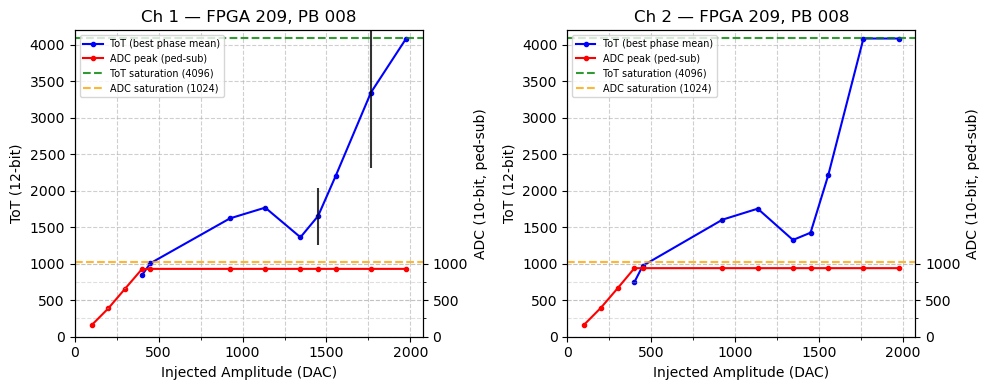


=== Page 2: channels [77, 78] ===
Combined ToT+ADC for PB 008 (ADC FPGA 209, ToT FPGA 209)
Plotting channels [77, 78] for FPGA 209, PB 008
Computing best phase for FPGA 209, PB 8 (pair_id = 1)
The best phase across all channels and amplitudes is: Phase 11 with score 3747.40
The second best phase is: Phase 12 with score 4099.91
Best phases in order of score (lower = better):
  Phase 11: 3747.40
  Phase 12: 4099.91
  Phase 8: 4161.40
  Phase 9: 4296.01
  Phase 10: 4627.88
  Phase 14: 5961.78
  Phase 15: 6129.72
  Phase 13: 6147.60
  Phase 0: 6594.96
  Phase 1: 6917.93
  Phase 3: 6961.64
  Phase 5: 7038.34
  Phase 2: 7353.64
Best phase (ToT) used: 11
Loaded 144 pedestal values for FPGA 209, PB 8
Saved combined grid plot to:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_209_pb008/Combined_ToT_ADC_chs_77_78_fpga209_pb008.png


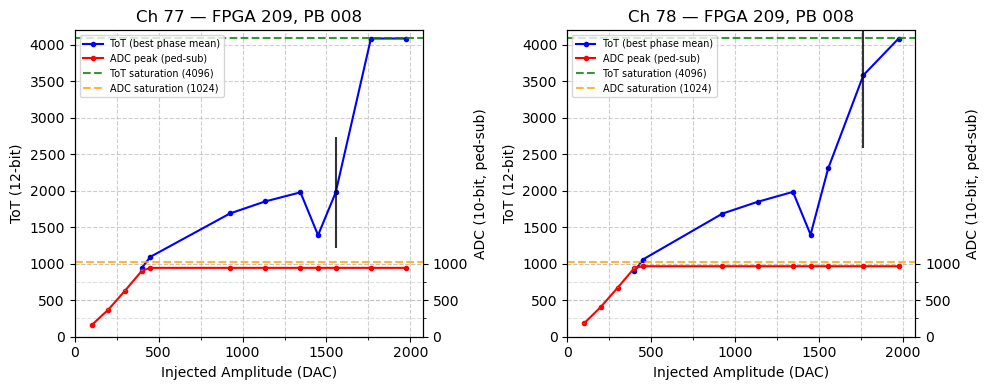

In [ ]:
# plot_tot_adc_for_channels([6], pair_id=0)

## Plot for all valid channels

all_valid_channels = [
    # ch for ch in range(num_groups * files_per_group)
    # if ch not in dead_channels
    # and ch not in calibration_channels
    # and ch not in notConnected_channels
    1, 2, 77, 78
]

# For interactive exploration (one big figure, no saving)
# plot_tot_adc_for_channels(all_valid_channels, pair_id=0 or 1, save_fig=False)

# If we want to save it
save_tot_adc_for_channels_paged(all_valid_channels, pair_id=pair_id_tot_mean, channels_per_fig=2)


# Compare ADC, TOT and TOA per channel

## Summary of TOA

In [249]:
def summarize_toa_vs_amp_for_channel(
    all_dirs_pair,
    channel,
    chosen_phase=None,          # <-- NEW: phase you want (0,1,2,3,5,8,...,15)
    exclude_phases=(4, 6, 7),
    toa_col="ToA"
):
    """
    For one channel, build a summary of ToA vs DAC Amplitude.

    If chosen_phase is not None:
        - keep only rows with Phase == chosen_phase.
    Else:
        - drop rows with Phase in exclude_phases.

    For each amplitude:
      - loop over runs
      - keep rows with Channel == channel
      - apply phase selection
      - drop ToA == 0
      - group by Time → mean/std(ToA)

    Returns
    -------
    df_toa : DataFrame with columns:
        ["Amplitude", "Time", "ToA_mean", "ToA_std"]
    """

    rows = []

    for amplitude, runs_dict in all_dirs_pair.items():
        all_runs = []

        for run_idx, file_path in runs_dict.items():
            if not os.path.exists(file_path):
                continue

            df = pd.read_csv(file_path)
            df.columns = df.columns.str.strip()

            required_cols = {"Channel", "Phase", "Time", toa_col}
            if not required_cols.issubset(df.columns):
                # wrong file format
                continue

            # --- Select channel first ---
            ch_data = df[df["Channel"] == channel]

            # --- Phase selection ---
            if chosen_phase is not None:
                # keep ONLY this phase
                ch_data = ch_data[ch_data["Phase"] == chosen_phase]
            else:
                # default behaviour: just exclude 4, 6, 7
                ch_data = ch_data[~ch_data["Phase"].isin(exclude_phases)]

            # keep only non-zero ToA
            ch_data = ch_data[ch_data[toa_col] != 0]
            if ch_data.empty:
                continue

            all_runs.append(ch_data[["Time", toa_col]])

        if not all_runs:
            continue

        combined = pd.concat(all_runs, ignore_index=True)

        # For a fixed phase, you expect one Time per amplitude, but grouping is safe
        stats = (
            combined
            .groupby("Time")[toa_col]
            .agg(["mean", "std"])
            .reset_index()
        )
        stats["Amplitude"] = amplitude
        rows.append(stats)

    if not rows:
        return pd.DataFrame(
            columns=["Amplitude", "Time", "ToA_mean", "ToA_std"]
        )

    df_toa = pd.concat(rows, ignore_index=True)
    df_toa = df_toa.rename(columns={"mean": "ToA_mean", "std": "ToA_std"})
    return df_toa


In [ ]:
# df_toa_test = summarize_toa_vs_amp_for_channel(
#     combined_adc_dirs,
#     channel=1,
#     chosen_phase=11,            # ← pick the phase
#     exclude_phases=(4, 6, 7),  # ignored when chosen_phase is used
#     toa_col="ToA",
# )
# print(df_toa_test)


# output_dir = os.path.join(
#     CONFIG_TOT["base_path"],
#     f"TOA_results/FPGA_{fpga_tot_mean}_pb{pb_tot_mean}"
# )

# os.makedirs(output_dir, exist_ok=True)

# output_csv = os.path.join(output_dir, f"ToA_summary_channel{channel_to_plot}.csv")

# df_toa_test.to_csv(output_csv, index=False)

# print("Saved ToA summary CSV to:\n", output_csv)


      Time  ToA_mean     ToA_std  Amplitude
0   106.25    784.80  138.577415        100
1   106.25    820.00    1.870829        200
2   106.25    790.20    1.303840        300
3   106.25    722.20  115.272286        400
4   106.25    769.80    0.836660        450
5   106.25    757.20    0.447214        925
6   106.25    483.80    4.381780       1135
7   106.25    480.60    3.577709       1345
8   106.25    500.50  296.181814       1450
9   181.25    733.00         NaN       1450
10  106.25    487.00    0.000000       1555
11  181.25    715.20    9.121403       1555
12  106.25    495.00    0.000000       1765
13  106.25    258.75    0.500000       1975


### Combined ADC - TOT and TOA

In [293]:
def plot_tot_adc_toa_for_channels(
    channels,
    pair_id,
    exclude_phases=(4, 6, 7),
    tot_ylim=(0, 4200),
    adc_ylim=(0, 4200),
    toa_phase=None,
    save_fig=False,
):
    """
    Plot combined ToT(best-phase mean) + ADC(ped-subtracted peaks) + TOA (every timestamp where TOA appears)
    vs injected amplitude for several channels, arranged in a grid
    of 2 columns.

    Parameters
    ----------
    channels : list[int]
        List of channel numbers to plot. Can be [6], list(range(40,43)), etc.

    pair_id : int
        0 → (208,06), 1 → (209,008), 2 → (208,008) according to CONFIG / CONFIG_TOT.

    exclude_phases : iterable
        Phases to exclude (default: [4,6,7]).

    tot_ylim : tuple
        (ymin, ymax) for ToT axis.

    adc_ylim : tuple
        (ymin, ymax) for ADC axis.

    save_fig : bool
        If True, saves the figure in the images/ folder for this FPGA–PB pair.
    """

    # --- FPGA–PB info ---
    fpga_adc, pb_adc = CONFIG["fpga_pb_pairs"][pair_id]
    fpga_tot, pb_tot = CONFIG_TOT["fpga_pb_pairs"][pair_id]

    # --- Safety check: PB must match (FPGA can differ) ---
    if pb_adc != pb_tot:
        raise ValueError(
            f"[ERROR] PB mismatch for pair_id={pair_id}:\n"
            f"  ADC config → FPGA {fpga_adc}, PB {pb_adc}\n"
            f"  ToT config → FPGA {fpga_tot}, PB {pb_tot}\n"
            f"PB must be the SAME to combine ToT and ADC."
        )

    pair_key_adc = f"fpga{fpga_adc}_pb{pb_adc}"
    pair_key_tot = f"fpga{fpga_tot}_pb{pb_tot}"

    print(
        f"Combined ToT+ADC for PB {pb_adc} "
        f"(ADC FPGA {fpga_adc}, ToT FPGA {fpga_tot})"
    )

    print(f"Plotting channels {channels} for FPGA {fpga_adc}, PB {pb_adc}")

    # --- Best phase for this pair (ToT) ---
    best_phase_tot, second_best, phase_scores = get_best_phase_tot(
        pair_id=pair_id,
        make_plot=False,
        save_plot=False,
    )
    print("Best phase (ToT) used:", best_phase_tot)

    # --- ToT directories for this pair ---
    all_dirs_pair_tot = all_dirs_tot[pair_key_tot]

    # --- Pedestals for this FPGA–PB pair (ADC) ---
    fpga_int = int(fpga_adc)
    pb_int   = int(pb_adc)
    ped_sub_plot = ped_df[(ped_df["FPGA"] == fpga_int) & (ped_df["PB"] == pb_int)]
    pedestal_map_plot = ped_sub_plot.set_index("Channel")["HV"].to_dict()
    print(f"Loaded {len(pedestal_map_plot)} pedestal values for FPGA {fpga_int}, PB {pb_int}")

    # --- Build combined ADC dirs: low-DAC ADC scan + high-DAC ToT scan ---
    combined_adc_dirs = {}

    # ADC scan (CONFIG amplitudes, e.g. 100–400)
    if "all_dirs" in globals():
        adc_pair_dict = all_dirs.get(pair_key_adc, {})
        for amp, runs_dict in adc_pair_dict.items():
            combined_adc_dirs.setdefault(amp, {}).update(runs_dict)

    # ToT scan (CONFIG_TOT amplitudes, e.g. 400, 450, 925, 1450, 1975)
    for amp, runs_dict in all_dirs_pair_tot.items():
        combined_adc_dirs.setdefault(amp, {}).update(runs_dict)

    # --- ADC max per channel & run (ped-sub) for this pair ---
    df_adc_max = get_adc_max_per_channel(
        all_dirs_pair=combined_adc_dirs,
        pedestal_map=pedestal_map_plot,
        amplitudes=None,
        fallback_pedestal=fallback_pedestal,
        exclude_phases=exclude_phases,
    )

    if df_adc_max.empty:
        print("[ADC] No ADC data found for this pair. Nothing to plot.")
        return

    # --- Prepare figure with N channels, 2 columns ---
    channels = list(channels)
    n_ch = len(channels)
    if n_ch == 0:
        print("No channels provided.")
        return

    ncols = 2
    nrows = math.ceil(n_ch / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4 * nrows), sharex=False)
    axes = np.array(axes).reshape(nrows, ncols)

    # --- Loop over channels and draw each subplot ---
    for idx, ch in enumerate(channels):
        row = idx // ncols
        col = idx % ncols
        ax1 = axes[row, col]

        # Skip dead/calibration/notConnected channels (you can comment this out if you want to force-plot them)
        if (ch in dead_channels or
            ch in calibration_channels or
            ch in notConnected_channels or 
            ch in manual_discarded_channels):
            ax1.set_title(f"Channel {ch} (discarded)")
            ax1.axis("off")
            continue

        # -------- ToT: best phase mean per amplitude for this channel --------
        df_tot_runs = extract_tot_bestphase_per_run(
            all_dirs_pair_tot=all_dirs_pair_tot,
            channel=ch,
            best_phase=best_phase_tot,
            exclude_phases=exclude_phases,
        )

        if df_tot_runs.empty:
            ax1.set_title(
                f"Ch {ch} — No ToT data\nFPGA {fpga_tot}, PB {pb_tot}"
            )
            ax1.axis("off")
            continue

        tot_summary_ch = (
            df_tot_runs
            .groupby("Amplitude")["ToT_bestphase_mean"]
            .agg(["mean", "std"])
            .reset_index()
            .rename(columns={"mean": "ToT_mean", "std": "ToT_std"})
            .sort_values("Amplitude")
        )

        amps_tot = tot_summary_ch["Amplitude"].values
        vals_tot = tot_summary_ch["ToT_mean"].values
        errs_tot = tot_summary_ch["ToT_std"].values

        # -------- ADC: ped-subtracted peak per amplitude for this channel --------
        adc_ch = df_adc_max[df_adc_max["Channel"] == ch]
        if adc_ch.empty:
            ax1.set_title(
                f"Ch {ch} — No ADC data\nFPGA {fpga_tot}, PB {pb_tot}"
            )
            ax1.axis("off")
            continue

        adc_summary_ch = (
            adc_ch
            .groupby("Amplitude")["ADC_max_minus_ped"]
            .agg(["mean", "std"])
            .reset_index()
            .rename(columns={"mean": "ADC_mean", "std": "ADC_std"})
            .sort_values("Amplitude")
        )

        amps_adc = adc_summary_ch["Amplitude"].values
        vals_adc = adc_summary_ch["ADC_mean"].values
        errs_adc = adc_summary_ch["ADC_std"].values

        # --- Left axis: ToT ---
        line1 = ax1.plot(
            amps_tot,
            vals_tot,
            c="blue",
            marker=".",
            label=f"ToT (best phase [{best_phase_tot}] mean)",
        )[0]

        ax1.errorbar(
            amps_tot,
            vals_tot,
            yerr=errs_tot,
            fmt="",
            linestyle="None",
            c="black",
            alpha=0.8,
        )

        ax1.set_xlabel("Injected Amplitude (DAC)")
        ax1.set_ylabel("ToT (12-bit)")
        ax1.set_ylim(*tot_ylim)

        # X-limits based on both ToT & ADC amplitudes
        all_amps = np.concatenate([amps_tot, amps_adc])
        ax1.set_xlim(0, max(all_amps) * 1.05)

        ax1.xaxis.set_major_locator(ticker.MultipleLocator(500))
        ax1.xaxis.set_minor_locator(ticker.MultipleLocator(250))
        ax1.grid(True, which="both", axis="both", linestyle="--", alpha=0.6)

        # ToT saturation line
        hline1 = ax1.axhline(
            y=4096,
            color="green",
            linestyle="--",
            linewidth=1.5,
            alpha=0.8,
            label="ToT saturation (4096)", 
        )

        # --- Right axis: ADC ---
        ax2 = ax1.twinx()

        line2 = ax2.plot(
            amps_adc,
            vals_adc,
            c="red",
            marker=".",
            label="ADC peak (ped-sub)",
        )[0]

        ax2.errorbar(
            amps_adc,
            vals_adc,
            yerr=errs_adc,
            fmt="",
            linestyle="None",
            c="gray",
            alpha=0.8,
        )

        
        ax2.set_ylim(*adc_ylim)

        minor_ticks = list(range(0, 1024, 250))
        major_ticks = list(range(0, 1024, 500))
        ax2.set_yticks(major_ticks)
        ax2.set_yticks(minor_ticks, minor=True)
        ax2.yaxis.grid(True, which="both", linestyle="--", alpha=0.4)

        hline2 = ax2.axhline(
            y=1024,
            color="orange",
            linestyle="--",
            linewidth=1.5,
            alpha=0.8,
            label="ADC saturation (1024)",
        )
        
        # -------- ToA --------
        toa_handles = []
        
        df_toa = summarize_toa_vs_amp_for_channel(
            combined_adc_dirs,
            channel=ch,
            # chosen_phase=toa_phase,
            chosen_phase=(toa_phase if toa_phase is not None else best_phase_tot),
            exclude_phases=exclude_phases,
            toa_col="ToA", 
        )
        
        if not df_toa.empty:
            # one curve per Time bin where we have ToA
            for i_time, (t_val, df_t) in enumerate(
                df_toa.groupby("Time")
            ):
                df_t = df_t.sort_values("Amplitude")
                
                toa_line = ax2.plot(
                    df_t["Amplitude"],
                    df_t["ToA_mean"],
                    linestyle="-",
                    marker=markers[i_time % len(markers)],
                    markersize=2,
                    linewidth=1.0,
                    alpha=0.8,
                    label=(
                        f"ToA (phase={toa_phase}, t={t_val:.2f} ns)"
                        if toa_phase is not None
                        else f"ToA t={t_val:.2f} ns"
                    ),
                )[0]

                # Then draw error bars without adding another legend entry
                ax2.errorbar(
                    df_t["Amplitude"],
                    df_t["ToA_mean"],
                    yerr=df_t["ToA_std"],
                    fmt="none",
                    capsize=2,
                    elinewidth=0.8,
                    alpha=0.7,
                )

                # Save the handle so we can put it in the legend
                toa_handles.append(toa_line)

        ax1.set_title(
            f"Ch {ch} — FPGA {fpga_tot}, PB {pb_tot}"
        )
        
        if not df_toa.empty:
            ax2.set_ylabel("ADC (10-bit, ped-sub) and ToA (10-bit)")
        else:
            ax2.set_ylabel("ADC (10-bit, ped-sub)")

        # Small combined legend (per subplot)
        # lines = [line1, line2, hline1, hline2] + toa_handles
        # labels = [
        #     "ToT (best phase mean)",
        #     "ADC peak (ped-sub)",
        #     "ToT saturation (4096)",
        #     "ADC saturation (1024)",
        # ]
        
        lines = [line1, line2, hline1, hline2] + toa_handles
        labels = [ln.get_label() for ln in lines]
        ax1.legend(lines, labels, fontsize="x-small", loc="upper left")

    # Turn off unused axes if channels < nrows*ncols
    for idx in range(n_ch, nrows * ncols):
        row = idx // ncols
        col = idx % ncols
        axes[row, col].axis("off")

    plt.tight_layout()

    # Save the whole grid figure if requested
    if save_fig:
        output_dir_plot = os.path.join(
            CONFIG_TOT["base_path"],
            f"images/FPGA_{fpga_tot}_pb{pb_tot}"
        )
        os.makedirs(output_dir_plot, exist_ok=True)

        n_ch = len(channels)
        # Build a SHORT tag for the filename
        if n_ch == 1:
            channels_tag = f"ch{channels[0]}"
        elif n_ch <= 10:
            # ok to list them explicitly if there are few
            channels_tag = "chs_" + "_".join(str(c) for c in channels)
        else:
            # too many channels → keep it compact
            channels_tag = f"{n_ch}channels"

        fig_path = os.path.join(
            output_dir_plot,
            f"Combined_ToT_ADC_{channels_tag}_fpga{fpga_tot}_pb{pb_tot}.png"
        )

        fig.savefig(fig_path, dpi=200)
        print(f"Saved combined grid plot to:\n  {fig_path}")

    plt.show()


In [294]:
def save_tot_adc_toa_for_channels_paged(
    channels,
    pair_id,
    channels_per_fig=6,
    toa_phase=0,
    exclude_phases=(4, 6, 7),
    tot_ylim=(0, 4200),
    adc_ylim=(0, 4200),
    **kwargs
):
    """
    Save combined ToT + ADC (+ ToA if enabled in plot function)
    in pages of at most `channels_per_fig` channels.

    Each page calls plot_tot_adc_for_channels(..., save_fig=True).

    Parameters
    ----------
    channels : iterable[int]
        Channels to plot.

    pair_id : int
        0 → (208,06), 1 → (209,008).

    channels_per_fig : int
        Max channels per saved figure (default 6 → 3 rows × 2 cols).

    exclude_phases : iterable
        Phases to exclude (4, 6, 7).

    tot_ylim : tuple
        Y-limits for ToT axis.

    adc_ylim : tuple
        Y-limits for ADC axis.

    **kwargs :
        Any additional arguments forwarded to plot_tot_adc_for_channels.
        Example: toa_col="ToA_ADC", toa_xlim=(...), legend_size=...
    """

    channels = list(channels)
    n_ch = len(channels)

    if n_ch == 0:
        print("⚠ No channels provided — nothing to save.")
        return

    print(f"📄 Saving {n_ch} channels in pages of {channels_per_fig} channels each...")

    page = 1
    for start in range(0, n_ch, channels_per_fig):

        batch = channels[start:start + channels_per_fig]
        print(f"\n=== 📘 Page {page}: Channels {batch} ===")

        # Call the updated plot function
        plot_tot_adc_toa_for_channels(
            batch,
            pair_id=pair_id,
            exclude_phases=exclude_phases,
            tot_ylim=tot_ylim,
            adc_ylim=adc_ylim,
            toa_phase=toa_phase,
            save_fig=True,
            **kwargs
        )

        page += 1

    print("\n✨ All pages saved successfully!")


📄 Saving 4 channels in pages of 2 channels each...

=== 📘 Page 1: Channels [1, 2] ===
Combined ToT+ADC for PB 008 (ADC FPGA 209, ToT FPGA 209)
Plotting channels [1, 2] for FPGA 209, PB 008
Computing best phase for FPGA 209, PB 8 (pair_id = 1)
The best phase across all channels and amplitudes is: Phase 11 with score 3747.40
The second best phase is: Phase 12 with score 4099.91
Best phases in order of score (lower = better):
  Phase 11: 3747.40
  Phase 12: 4099.91
  Phase 8: 4161.40
  Phase 9: 4296.01
  Phase 10: 4627.88
  Phase 14: 5961.78
  Phase 15: 6129.72
  Phase 13: 6147.60
  Phase 0: 6594.96
  Phase 1: 6917.93
  Phase 3: 6961.64
  Phase 5: 7038.34
  Phase 2: 7353.64
Best phase (ToT) used: 11
Loaded 144 pedestal values for FPGA 209, PB 8
Saved combined grid plot to:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_209_pb008/Combined_ToT_ADC_chs_1_2_fpga209_pb008.png


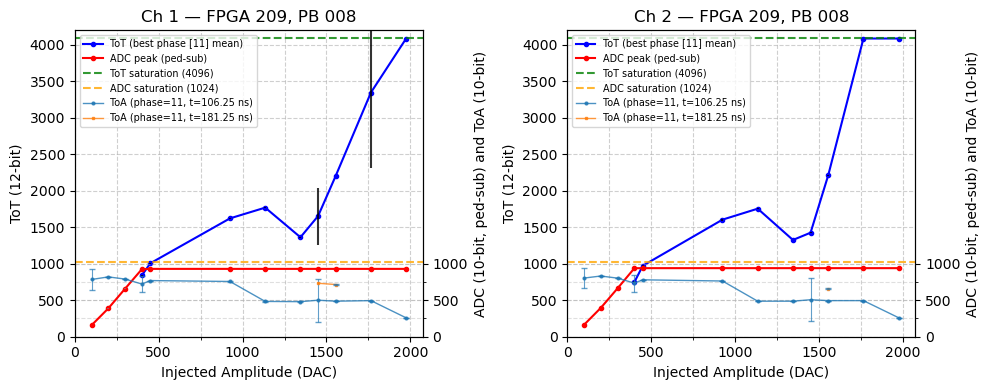


=== 📘 Page 2: Channels [77, 78] ===
Combined ToT+ADC for PB 008 (ADC FPGA 209, ToT FPGA 209)
Plotting channels [77, 78] for FPGA 209, PB 008
Computing best phase for FPGA 209, PB 8 (pair_id = 1)
The best phase across all channels and amplitudes is: Phase 11 with score 3747.40
The second best phase is: Phase 12 with score 4099.91
Best phases in order of score (lower = better):
  Phase 11: 3747.40
  Phase 12: 4099.91
  Phase 8: 4161.40
  Phase 9: 4296.01
  Phase 10: 4627.88
  Phase 14: 5961.78
  Phase 15: 6129.72
  Phase 13: 6147.60
  Phase 0: 6594.96
  Phase 1: 6917.93
  Phase 3: 6961.64
  Phase 5: 7038.34
  Phase 2: 7353.64
Best phase (ToT) used: 11
Loaded 144 pedestal values for FPGA 209, PB 8
Saved combined grid plot to:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_209_pb008/Combined_ToT_ADC_chs_77_78_fpga209_pb008.png


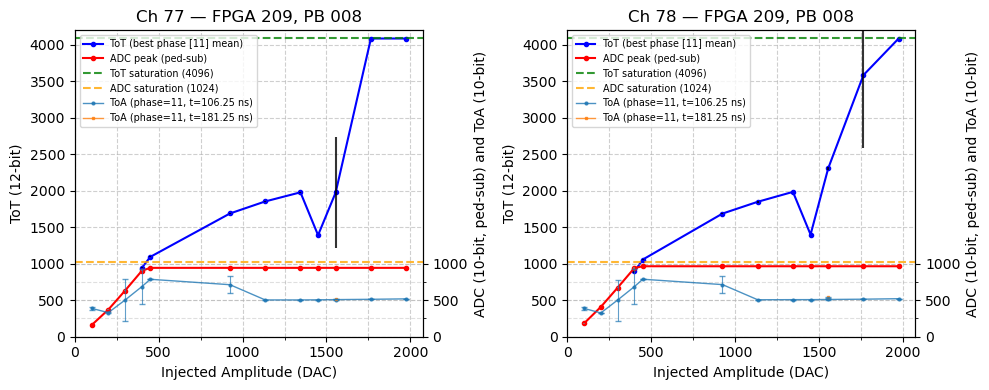


✨ All pages saved successfully!


In [ ]:
# plot_tot_adc_for_channels([6], pair_id=0)

## Plot for all valid channels

all_valid_channels = [
    # ch for ch in range(num_groups * files_per_group)
    # if ch not in dead_channels
    # and ch not in calibration_channels
    # and ch not in notConnected_channels
    1, 2, 77, 78
]

# For interactive exploration (one big figure, no saving)
# plot_tot_adc_for_channels(all_valid_channels, pair_id=0 or 1, save_fig=False)

# If we want to save it
save_tot_adc_toa_for_channels_paged(all_valid_channels, pair_id=pair_id_tot_mean, channels_per_fig=2, toa_phase=11)


## First Appearing ToA

In [314]:
def summarize_toa_vs_amp_for_channel(
    all_dirs_pair,
    channel,
    exclude_phases=(4, 6, 7),
    toa_col="ToA",
):
    """
    For one channel, build a summary of ToA vs DAC Amplitude, using a
    separate reference time t_ref(amplitude) for each amplitude:

      For each amplitude:
        1) Loop over runs, filter Channel == channel and exclude_phases.
        2) Collect all rows where ToA != 0.
        3) Find t_ref_amp = earliest Time with non-zero ToA for this amplitude.
        4) For each run, at Time ≈ t_ref_amp, take non-zero ToA values,
           average within the run, then compute mean/std across runs.

    Returns
    -------
    df_toa : DataFrame with columns:
        ["Amplitude", "Time_ref", "ToA_mean", "ToA_std"]

    If for a given amplitude no non-zero ToA is found, that amplitude is skipped.
    If nothing is found at all, returns an empty DataFrame.
    """

    def load_channel_filtered_df(file_path):
        """Read file, keep only this channel and exclude_phases."""
        if not os.path.exists(file_path):
            return None

        df = pd.read_csv(file_path)
        df.columns = df.columns.str.strip()

        required_cols = {"Channel", "Phase", "Time", toa_col}
        if not required_cols.issubset(df.columns):
            return None

        mask = (df["Channel"] == channel)
        if exclude_phases is not None:
            mask &= ~df["Phase"].isin(exclude_phases)

        ch_data = df.loc[mask].copy()
        if ch_data.empty:
            return None

        return ch_data

    rows = []

    # ----- Loop over amplitudes -----
    for amplitude, runs_dict in all_dirs_pair.items():

        # 1) Collect all non-zero ToA rows across runs → to define t_ref_amp
        all_nz = []

        for run_idx, file_path in runs_dict.items():
            ch_data = load_channel_filtered_df(file_path)
            if ch_data is None or ch_data.empty:
                continue

            df_toa_nz = ch_data[ch_data[toa_col] != 0]
            if df_toa_nz.empty:
                continue

            all_nz.append(df_toa_nz[["Time", toa_col]])

        if not all_nz:
            # No non-zero ToA at all for this amplitude
            continue

        all_nz_cat = pd.concat(all_nz, ignore_index=True)

        # 2) Reference time for THIS amplitude: earliest non-zero ToA
        t_ref_amp = all_nz_cat["Time"].min()

        # 3) For each run, collect ToA at t_ref_amp
        per_run_toa = []

        for run_idx, file_path in runs_dict.items():
            ch_data = load_channel_filtered_df(file_path)
            if ch_data is None or ch_data.empty:
                continue

            # Use isclose in case of tiny float differences in Time
            mask_t = np.isclose(ch_data["Time"].values, t_ref_amp, rtol=0, atol=1e-6)
            df_at_t = ch_data.loc[mask_t]

            if df_at_t.empty:
                continue

            df_at_t = df_at_t[df_at_t[toa_col] != 0]
            if df_at_t.empty:
                continue

            toa_run = df_at_t[toa_col].mean()
            per_run_toa.append(toa_run)

        if not per_run_toa:
            # No usable ToA at t_ref_amp for this amplitude
            continue

        per_run_toa = np.array(per_run_toa, dtype=float)
        toa_mean = float(per_run_toa.mean())
        toa_std  = float(per_run_toa.std(ddof=1)) if len(per_run_toa) > 1 else 0.0

        rows.append({
            "Amplitude": amplitude,
            "Time_ref": t_ref_amp,
            "ToA_mean": toa_mean,
            "ToA_std": toa_std,
        })

    if not rows:
        return pd.DataFrame(
            columns=["Amplitude", "Time_ref", "ToA_mean", "ToA_std"]
        )

    df_toa = pd.DataFrame(rows).sort_values("Amplitude").reset_index(drop=True)
    return df_toa


In [329]:
def plot_tot_adc_toa_for_channels(
    channels,
    pair_id,
    exclude_phases=(4, 6, 7),
    tot_ylim=(0, 4200),
    adc_ylim=(0, 4200),
    save_fig=False,
):
    """
    Plot combined ToT(best-phase mean) + ADC(ped-subtracted peaks) + TOA (every timestamp where TOA appears)
    vs injected amplitude for several channels, arranged in a grid
    of 2 columns.

    Parameters
    ----------
    channels : list[int]
        List of channel numbers to plot. Can be [6], list(range(40,43)), etc.

    pair_id : int
        0 → (208,06), 1 → (209,008), 2 → (208,008) according to CONFIG / CONFIG_TOT.

    exclude_phases : iterable
        Phases to exclude (default: [4,6,7]).

    tot_ylim : tuple
        (ymin, ymax) for ToT axis.

    adc_ylim : tuple
        (ymin, ymax) for ADC axis.

    save_fig : bool
        If True, saves the figure in the images/ folder for this FPGA–PB pair.
    """

    # --- FPGA–PB info ---
    fpga_adc, pb_adc = CONFIG["fpga_pb_pairs"][pair_id]
    fpga_tot, pb_tot = CONFIG_TOT["fpga_pb_pairs"][pair_id]

    # --- Safety check: PB must match (FPGA can differ) ---
    if pb_adc != pb_tot:
        raise ValueError(
            f"[ERROR] PB mismatch for pair_id={pair_id}:\n"
            f"  ADC config → FPGA {fpga_adc}, PB {pb_adc}\n"
            f"  ToT config → FPGA {fpga_tot}, PB {pb_tot}\n"
            f"PB must be the SAME to combine ToT and ADC."
        )

    pair_key_adc = f"fpga{fpga_adc}_pb{pb_adc}"
    pair_key_tot = f"fpga{fpga_tot}_pb{pb_tot}"

    print(
        f"Combined ToT+ADC for PB {pb_adc} "
        f"(ADC FPGA {fpga_adc}, ToT FPGA {fpga_tot})"
    )

    print(f"Plotting channels {channels} for FPGA {fpga_adc}, PB {pb_adc}")

    # --- Best phase for this pair (ToT) ---
    best_phase_tot, second_best, phase_scores = get_best_phase_tot(
        pair_id=pair_id,
        make_plot=False,
        save_plot=False,
    )
    print("Best phase (ToT) used:", best_phase_tot)

    # --- ToT directories for this pair ---
    all_dirs_pair_tot = all_dirs_tot[pair_key_tot]

    # --- Pedestals for this FPGA–PB pair (ADC) ---
    fpga_int = int(fpga_adc)
    pb_int   = int(pb_adc)
    ped_sub_plot = ped_df[(ped_df["FPGA"] == fpga_int) & (ped_df["PB"] == pb_int)]
    pedestal_map_plot = ped_sub_plot.set_index("Channel")["HV"].to_dict()
    print(f"Loaded {len(pedestal_map_plot)} pedestal values for FPGA {fpga_int}, PB {pb_int}")

    # --- Build combined ADC dirs: low-DAC ADC scan + high-DAC ToT scan ---
    combined_adc_dirs = {}

    # ADC scan (CONFIG amplitudes, e.g. 100–400)
    if "all_dirs" in globals():
        adc_pair_dict = all_dirs.get(pair_key_adc, {})
        for amp, runs_dict in adc_pair_dict.items():
            combined_adc_dirs.setdefault(amp, {}).update(runs_dict)

    # ToT scan (CONFIG_TOT amplitudes, e.g. 400, 450, 925, 1450, 1975)
    for amp, runs_dict in all_dirs_pair_tot.items():
        combined_adc_dirs.setdefault(amp, {}).update(runs_dict)

    # --- ADC max per channel & run (ped-sub) for this pair ---
    df_adc_max = get_adc_max_per_channel(
        all_dirs_pair=combined_adc_dirs,
        pedestal_map=pedestal_map_plot,
        amplitudes=None,
        fallback_pedestal=fallback_pedestal,
        exclude_phases=exclude_phases,
    )

    if df_adc_max.empty:
        print("[ADC] No ADC data found for this pair. Nothing to plot.")
        return

    # --- Prepare figure with N channels, 2 columns ---
    channels = list(channels)
    n_ch = len(channels)
    if n_ch == 0:
        print("No channels provided.")
        return

    ncols = 2
    nrows = math.ceil(n_ch / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4 * nrows), sharex=False)
    axes = np.array(axes).reshape(nrows, ncols)

    # --- Loop over channels and draw each subplot ---
    for idx, ch in enumerate(channels):
        row = idx // ncols
        col = idx % ncols
        ax1 = axes[row, col]

        # Skip dead/calibration/notConnected channels (you can comment this out if you want to force-plot them)
        if (ch in dead_channels or
            ch in calibration_channels or
            ch in notConnected_channels or 
            ch in manual_discarded_channels):
            ax1.set_title(f"Channel {ch} (discarded)")
            ax1.axis("off")
            continue

        # -------- ToT: best phase mean per amplitude for this channel --------
        df_tot_runs = extract_tot_bestphase_per_run(
            all_dirs_pair_tot=all_dirs_pair_tot,
            channel=ch,
            best_phase=best_phase_tot,
            exclude_phases=exclude_phases,
        )

        if df_tot_runs.empty:
            ax1.set_title(
                f"Ch {ch} — No ToT data\nFPGA {fpga_tot}, PB {pb_tot}"
            )
            ax1.axis("off")
            continue

        tot_summary_ch = (
            df_tot_runs
            .groupby("Amplitude")["ToT_bestphase_mean"]
            .agg(["mean", "std"])
            .reset_index()
            .rename(columns={"mean": "ToT_mean", "std": "ToT_std"})
            .sort_values("Amplitude")
        )

        amps_tot = tot_summary_ch["Amplitude"].values
        vals_tot = tot_summary_ch["ToT_mean"].values
        errs_tot = tot_summary_ch["ToT_std"].values

        # -------- ADC: ped-subtracted peak per amplitude for this channel --------
        adc_ch = df_adc_max[df_adc_max["Channel"] == ch]
        if adc_ch.empty:
            ax1.set_title(
                f"Ch {ch} — No ADC data\nFPGA {fpga_tot}, PB {pb_tot}"
            )
            ax1.axis("off")
            continue

        adc_summary_ch = (
            adc_ch
            .groupby("Amplitude")["ADC_max_minus_ped"]
            .agg(["mean", "std"])
            .reset_index()
            .rename(columns={"mean": "ADC_mean", "std": "ADC_std"})
            .sort_values("Amplitude")
        )

        amps_adc = adc_summary_ch["Amplitude"].values
        vals_adc = adc_summary_ch["ADC_mean"].values
        errs_adc = adc_summary_ch["ADC_std"].values

        # --- Left axis: ToT ---
        line1 = ax1.plot(
            amps_tot,
            vals_tot,
            c="blue",
            marker=".",
            label=f"ToT (best phase [{best_phase_tot}] mean)",
        )[0]

        ax1.errorbar(
            amps_tot,
            vals_tot,
            yerr=errs_tot,
            fmt="",
            linestyle="None",
            c="black",
            alpha=0.8,
        )

        ax1.set_xlabel("Injected Amplitude (DAC)")
        ax1.set_ylabel("ToT (12-bit)")
        ax1.set_ylim(*tot_ylim)

        # X-limits based on both ToT & ADC amplitudes
        all_amps = np.concatenate([amps_tot, amps_adc])
        ax1.set_xlim(0, max(all_amps) * 1.05)

        ax1.xaxis.set_major_locator(ticker.MultipleLocator(500))
        ax1.xaxis.set_minor_locator(ticker.MultipleLocator(250))
        ax1.grid(True, which="both", axis="both", linestyle="--", alpha=0.6)

        # ToT saturation line
        hline1 = ax1.axhline(
            y=4096,
            color="green",
            linestyle="--",
            linewidth=1.5,
            alpha=0.8,
            label="ToT saturation (4096)", 
        )

        # --- Right axis: ADC ---
        ax2 = ax1.twinx()

        line2 = ax2.plot(
            amps_adc,
            vals_adc,
            c="red",
            marker=".",
            label="ADC peak (ped-sub)",
        )[0]

        ax2.errorbar(
            amps_adc,
            vals_adc,
            yerr=errs_adc,
            fmt="",
            linestyle="None",
            c="gray",
            alpha=0.8,
        )

        
        ax2.set_ylim(*adc_ylim)

        minor_ticks = list(range(0, 1024, 250))
        major_ticks = list(range(0, 1024, 500))
        ax2.set_yticks(major_ticks)
        ax2.set_yticks(minor_ticks, minor=True)
        ax2.yaxis.grid(True, which="both", linestyle="--", alpha=0.4)

        hline2 = ax2.axhline(
            y=1024,
            color="orange",
            linestyle="--",
            linewidth=1.5,
            alpha=0.8,
            label="ADC saturation (1024)",
        )
        
        # -------- ToA: first non-zero time PER amplitude --------
        toa_handles = []

        df_toa = summarize_toa_vs_amp_for_channel(
            combined_adc_dirs,
            channel=ch,
            exclude_phases=exclude_phases,
            toa_col="ToA",
        )

        if not df_toa.empty:
            df_toa = df_toa.sort_values("Amplitude")

            # Time when ToA appears first (per amplitude)
            t_min = df_toa["Time_ref"].min()
            t_max = df_toa["Time_ref"].max()

            if np.isclose(t_min, t_max):
                time_label = f"{t_min:.2f} ns"
            else:
                time_label = f"{t_min:.2f}–{t_max:.2f} ns"

            toa_plot = ax2.errorbar(
                df_toa["Amplitude"],
                df_toa["ToA_mean"],
                yerr=df_toa["ToA_std"],
                fmt="x",
                linestyle="-",
                markersize=3,
                elinewidth=0.8,
                capsize=2,
                alpha=0.8,
                label=f"ToA at first non-zero time (t_ref={time_label})",
            )
            # Extract the *line* inside the ErrorbarContainer
            toa_line = toa_plot.lines[0]
            toa_handles.append(toa_line)


        ax1.set_title(
            f"Ch {ch} — FPGA {fpga_tot}, PB {pb_tot}"
        )
        
        if not df_toa.empty:
            ax2.set_ylabel("ADC (10-bit, ped-sub) and ToA (10-bit)")
        else:
            ax2.set_ylabel("ADC (10-bit, ped-sub)")

        # Small combined legend (per subplot)
        # lines = [line1, line2, hline1, hline2] + toa_handles
        # labels = [
        #     "ToT (best phase mean)",
        #     "ADC peak (ped-sub)",
        #     "ToT saturation (4096)",
        #     "ADC saturation (1024)",
        # ]
        
        lines = [line1, line2, hline1, hline2] + toa_handles
        labels = [ln.get_label() for ln in lines]
        ax1.legend(lines, labels, fontsize="x-small", loc="upper left")


    # Turn off unused axes if channels < nrows*ncols
    for idx in range(n_ch, nrows * ncols):
        row = idx // ncols
        col = idx % ncols
        axes[row, col].axis("off")

    plt.tight_layout()

    # Save the whole grid figure if requested
    if save_fig:
        output_dir_plot = os.path.join(
            CONFIG_TOT["base_path"],
            f"images/FPGA_{fpga_tot}_pb{pb_tot}"
        )
        os.makedirs(output_dir_plot, exist_ok=True)

        n_ch = len(channels)
        # Build a SHORT tag for the filename
        if n_ch == 1:
            channels_tag = f"ch{channels[0]}"
        elif n_ch <= 10:
            # ok to list them explicitly if there are few
            channels_tag = "chs_" + "_".join(str(c) for c in channels)
        else:
            # too many channels → keep it compact
            channels_tag = f"{n_ch}channels"

        fig_path = os.path.join(
            output_dir_plot,
            f"Combined_ToT_ADC_{channels_tag}_fpga{fpga_tot}_pb{pb_tot}.png"
        )

        fig.savefig(fig_path, dpi=200)
        print(f"Saved combined grid plot to:\n  {fig_path}")

    plt.show()


In [330]:
def save_tot_adc_toa_for_channels_paged(
    channels,
    pair_id,
    channels_per_fig=6,
    exclude_phases=(4, 6, 7),
    tot_ylim=(0, 4200),
    adc_ylim=(0, 4200),
    **kwargs
):
    """
    Save combined ToT + ADC (+ ToA if enabled in plot function)
    in pages of at most `channels_per_fig` channels.

    Each page calls plot_tot_adc_for_channels(..., save_fig=True).

    Parameters
    ----------
    channels : iterable[int]
        Channels to plot.

    pair_id : int
        0 → (208,06), 1 → (209,008).

    channels_per_fig : int
        Max channels per saved figure (default 6 → 3 rows × 2 cols).

    exclude_phases : iterable
        Phases to exclude (4, 6, 7).

    tot_ylim : tuple
        Y-limits for ToT axis.

    adc_ylim : tuple
        Y-limits for ADC axis.

    **kwargs :
        Any additional arguments forwarded to plot_tot_adc_for_channels.
        Example: toa_col="ToA_ADC", toa_xlim=(...), legend_size=...
    """

    channels = list(channels)
    n_ch = len(channels)

    if n_ch == 0:
        print("⚠ No channels provided — nothing to save.")
        return

    print(f"📄 Saving {n_ch} channels in pages of {channels_per_fig} channels each...")

    page = 1
    for start in range(0, n_ch, channels_per_fig):

        batch = channels[start:start + channels_per_fig]
        print(f"\n=== 📘 Page {page}: Channels {batch} ===")

        # Call the updated plot function
        plot_tot_adc_toa_for_channels(
            batch,
            pair_id=pair_id,
            exclude_phases=exclude_phases,
            tot_ylim=tot_ylim,
            adc_ylim=adc_ylim,
            save_fig=True,
            **kwargs
        )

        page += 1

    print("\n✨ All pages saved successfully!")


📄 Saving 4 channels in pages of 2 channels each...

=== 📘 Page 1: Channels [1, 2] ===
Combined ToT+ADC for PB 008 (ADC FPGA 209, ToT FPGA 209)
Plotting channels [1, 2] for FPGA 209, PB 008
Computing best phase for FPGA 209, PB 8 (pair_id = 1)
The best phase across all channels and amplitudes is: Phase 11 with score 3747.40
The second best phase is: Phase 12 with score 4099.91
Best phases in order of score (lower = better):
  Phase 11: 3747.40
  Phase 12: 4099.91
  Phase 8: 4161.40
  Phase 9: 4296.01
  Phase 10: 4627.88
  Phase 14: 5961.78
  Phase 15: 6129.72
  Phase 13: 6147.60
  Phase 0: 6594.96
  Phase 1: 6917.93
  Phase 3: 6961.64
  Phase 5: 7038.34
  Phase 2: 7353.64
Best phase (ToT) used: 11
Loaded 144 pedestal values for FPGA 209, PB 8


/tmp/ipykernel_4866/67188700.py:319: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x72f5ebc4a210> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lines, labels, fontsize="x-small", loc="upper left")
/tmp/ipykernel_4866/67188700.py:319: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x72f5ebc28d40> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lines, labels, fontsize="x-small", loc="upper left")


Saved combined grid plot to:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_209_pb008/Combined_ToT_ADC_chs_1_2_fpga209_pb008.png


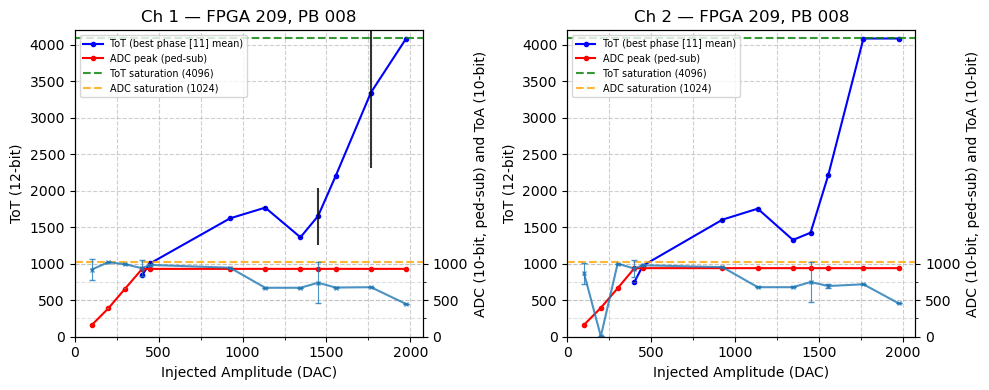


=== 📘 Page 2: Channels [77, 78] ===
Combined ToT+ADC for PB 008 (ADC FPGA 209, ToT FPGA 209)
Plotting channels [77, 78] for FPGA 209, PB 008
Computing best phase for FPGA 209, PB 8 (pair_id = 1)
The best phase across all channels and amplitudes is: Phase 11 with score 3747.40
The second best phase is: Phase 12 with score 4099.91
Best phases in order of score (lower = better):
  Phase 11: 3747.40
  Phase 12: 4099.91
  Phase 8: 4161.40
  Phase 9: 4296.01
  Phase 10: 4627.88
  Phase 14: 5961.78
  Phase 15: 6129.72
  Phase 13: 6147.60
  Phase 0: 6594.96
  Phase 1: 6917.93
  Phase 3: 6961.64
  Phase 5: 7038.34
  Phase 2: 7353.64
Best phase (ToT) used: 11
Loaded 144 pedestal values for FPGA 209, PB 8


/tmp/ipykernel_4866/67188700.py:319: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x72f5f44d1910> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lines, labels, fontsize="x-small", loc="upper left")
/tmp/ipykernel_4866/67188700.py:319: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x72f5f447e420> starts with '_'. It is thus excluded from the legend.
  ax1.legend(lines, labels, fontsize="x-small", loc="upper left")


Saved combined grid plot to:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_209_pb008/Combined_ToT_ADC_chs_77_78_fpga209_pb008.png


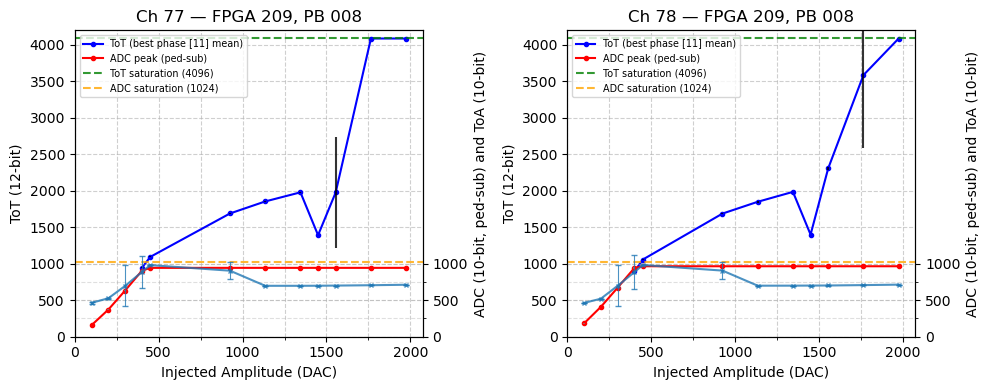


✨ All pages saved successfully!


In [ ]:
# plot_tot_adc_for_channels([6], pair_id=0)

## Plot for all valid channels

all_valid_channels = [
    # ch for ch in range(num_groups * files_per_group)
    # if ch not in dead_channels
    # and ch not in calibration_channels
    # and ch not in notConnected_channels
    1, 2, 77, 78
]

# For interactive exploration (one big figure, no saving)
# plot_tot_adc_for_channels(all_valid_channels, pair_id=0 or 1, save_fig=False)

# If we want to save it
save_tot_adc_toa_for_channels_paged(all_valid_channels, pair_id=pair_id_tot_mean, channels_per_fig=2)


# Inspect ADC of one channel

In [ ]:
##################################
## Setitng the channel to study ##
##################################

# ===== Choose the channel you want to inspect =====
channel_of_interest = 50   # <-- change this number as you like


Manual discarded channels for this pair: {34, 103, 40, 41, 39}


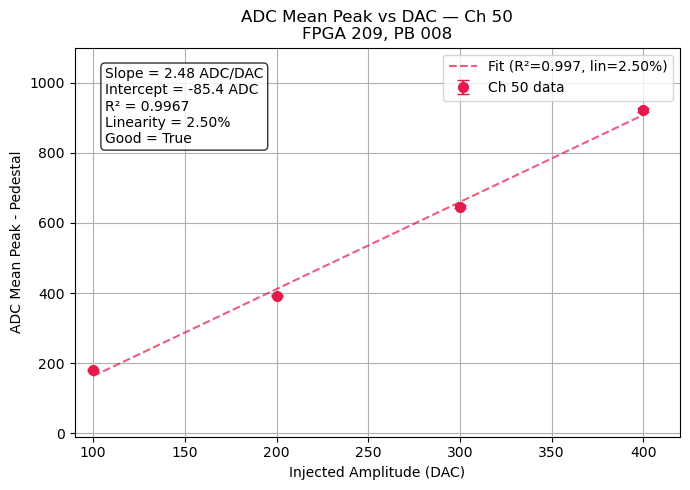

Figure saved to:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_209_pb008/linearity_channel50_fpga209-pb008_amp100_allruns.png


In [80]:
# Get manual discarded channels for this FPGA–PB pair
manual_discarded_channels = manual_discarded_by_pair.get(
    (fpga_adc_mean, pb_adc_mean),
    set()
)
print("Manual discarded channels for this pair:", manual_discarded_channels)

# ===== Check if this channel is allowed =====
if (channel_of_interest in dead_channels or
    channel_of_interest in calibration_channels or
    channel_of_interest in notConnected_channels or
    channel_of_interest in manual_discarded_channels):
    print(f"Channel {channel_of_interest} is in a discarded list (dead/calibration/notConnected/manual).")
else:
    # Select this channel's summary (mean & std over runs)
    df_ch = peaks_summary[peaks_summary["Channel"] == channel_of_interest]

    if df_ch.empty:
        print(f"No data found in peaks_summary for channel {channel_of_interest}.")
    else:
        # Sort by amplitude
        df_ch = df_ch.sort_values("Amplitude")
        amps  = df_ch["Amplitude"].values
        means = df_ch["mean"].values
        stds  = df_ch["std"].values

        if len(amps) < 2:
            print(f"Not enough amplitude points to fit a line for channel {channel_of_interest}.")
        else:
            # Pick a color + marker (just the first ones)
            color  = color_list[0]
            marker = markers[0]

            # ----- Linear regression -----
            slope, intercept, r_value, p_value, std_err = linregress(amps, means)
            r2 = r_value ** 2

            # Deviation-based linearity (%)
            fit_vals = slope * amps + intercept
            deviations = means - fit_vals
            max_deviation = np.max(np.abs(deviations))
            full_scale = np.max(means) - np.min(means)

            if full_scale > 0:
                linearity_percentage = max_deviation / full_scale * 100
            else:
                linearity_percentage = 0.0

            # Classification (optional, just to know)
            is_good = r2 >= acceptance_value

            # ----- Plot -----
            fig, ax = plt.subplots(figsize=(7, 5))

            # Error bars (mean ± std)
            ax.errorbar(
                amps, means,
                yerr=stds,
                fmt=marker,
                markersize=7,
                capsize=4,
                color=color,
                ecolor=color,
                linestyle="none",
                label=f"Ch {channel_of_interest} data",
            )

            # Regression line
            x_line = np.linspace(amps.min(), amps.max(), 200)
            y_line = slope * x_line + intercept

            ax.plot(
                x_line, y_line,
                linestyle="--",
                linewidth=1.5,
                alpha=0.7,
                color=color,
                label=f"Fit (R²={r2:.3f}, lin={linearity_percentage:.2f}%)"
            )

            # Labels, title, etc.
            ax.set_title(
                f"ADC Mean Peak vs DAC — Ch {channel_of_interest}\n"
                f"FPGA {fpga_adc_mean}, PB {pb_adc_mean}"
            )
            ax.set_xlabel("Injected Amplitude (DAC)")
            ax.set_ylabel("ADC Mean Peak - Pedestal")
            ax.set_xlim(min(CONFIG["amplitudes"]) - 10,
                        max(CONFIG["amplitudes"]) + 20)
            ax.set_ylim(-10, 1100)
            ax.grid(True)
            ax.legend(loc="best")

            # Optional: small text box with info
            txt = (
                f"Slope = {slope:.2f} ADC/DAC\n"
                f"Intercept = {intercept:.1f} ADC\n"
                f"R² = {r2:.4f}\n"
                f"Linearity = {linearity_percentage:.2f}%\n"
                f"Good = {is_good}"
            )
            ax.text(
                0.05, 0.95, txt,
                transform=ax.transAxes,
                va="top", ha="left",
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
            )

            plt.tight_layout()
            plt.show()

# ========= Save figure =========
output_dir = f'/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_{fpga_adc}_pb{pb_adc}'
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(
    output_dir,
    f'linearity_channel{channel_of_interest}_fpga{fpga_adc}-pb{pb_adc}_amp{injected_amplitude}_allruns.png'
)

fig.savefig(output_path, dpi=200)
print(f"Figure saved to:\n  {output_path}")


### Waweforms of Only One Channel

Channel of interest: 50
Manual discarded channels for this pair: {34, 103, 40, 41, 39}
Using pedestal = 77.0 ADC for channel 50


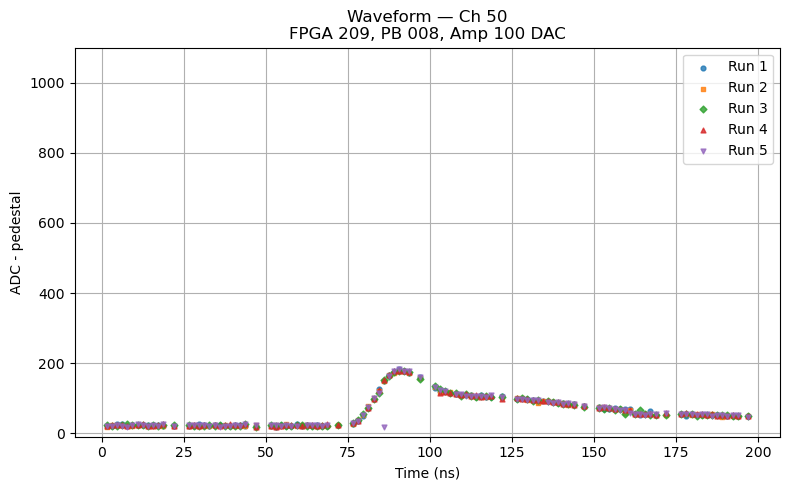

Figure saved to:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_209_pb008/phases_channel50_fpga209-pb008_amp100_allruns.png


In [81]:
# ===== Waveform of ONE channel over ALL runs =====

print(f"Channel of interest: {channel_of_interest}")

# Check if the channel is allowed
manual_discarded_channels = manual_discarded_by_pair.get(
    (fpga_adc_mean, pb_adc_mean),
    set()
)
print("Manual discarded channels for this pair:", manual_discarded_channels)

if (channel_of_interest in dead_channels or
    channel_of_interest in calibration_channels or
    channel_of_interest in notConnected_channels or
    channel_of_interest in manual_discarded_channels):
    print(f"⚠️ Channel {channel_of_interest} is in a discarded list (dead/calibration/notConnected/manual).")
else:
    # Get all run files for this amplitude and pair
    try:
        run_files = all_dirs[pair_key_mean][injected_amplitude_mean]   # dict: run_idx -> file_path
    except KeyError:
        print(f"No files found for pair {pair_key_mean} and amplitude {injected_amplitude_mean}")
        run_files = {}

    if not run_files:
        print("No run files available for this configuration.")
    else:
        fig, ax = plt.subplots(figsize=(8, 5))

        ped_i = pedestal_map_mean.get(channel_of_interest, fallback_pedestal)
        print(f"Using pedestal = {ped_i:.1f} ADC for channel {channel_of_interest}")

        any_data = False

        for run_idx, file_path in run_files.items():
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                continue

            df = pd.read_csv(file_path)
            df.columns = df.columns.str.strip()

            # Filter this channel, optionally remove weird phases
            ch_data = df[
                (df["Channel"] == channel_of_interest) &
                (~df["Phase"].isin([4, 6, 7]))
            ]

            if ch_data.empty:
                print(f"No data for channel {channel_of_interest} in run {run_idx+1}")
                continue

            any_data = True

            # Subtract pedestal
            adc_corr = ch_data["ADC"] - ped_i

            # Pick a marker per run
            marker = markers[run_idx % len(markers)]

            ax.scatter(
                ch_data["Time"],
                adc_corr,
                s=12,
                marker=marker,
                label=f"Run {run_idx+1}",
                alpha=0.8,
            )

        if not any_data:
            print(f"No valid data found for channel {channel_of_interest} in any run.")
        else:
            ax.set_title(
                f"Waveform — Ch {channel_of_interest}\n"
                f"FPGA {fpga_adc_mean}, PB {pb_adc_mean}, Amp {injected_amplitude_mean} DAC"
            )
            ax.set_xlabel("Time (ns)")
            ax.set_ylabel("ADC - pedestal")
            ax.set_ylim(-10, 1100)
            ax.grid(True)
            ax.legend()
            plt.tight_layout()
            plt.show()

# ========= Save figure =========
output_dir = f'/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_{fpga_adc}_pb{pb_adc}'
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(
    output_dir,
    f'phases_channel{channel_of_interest}_fpga{fpga_adc_mean}-pb{pb_adc_mean}_amp{injected_amplitude_mean}_allruns.png'
)

fig.savefig(output_path, dpi=200)
print(f"Figure saved to:\n  {output_path}")


Channel of interest: 50
Run selection: all
Manual discarded channels for this pair: {34, 103, 40, 41, 39}
Using pedestal = 77.0 ADC for channel 50


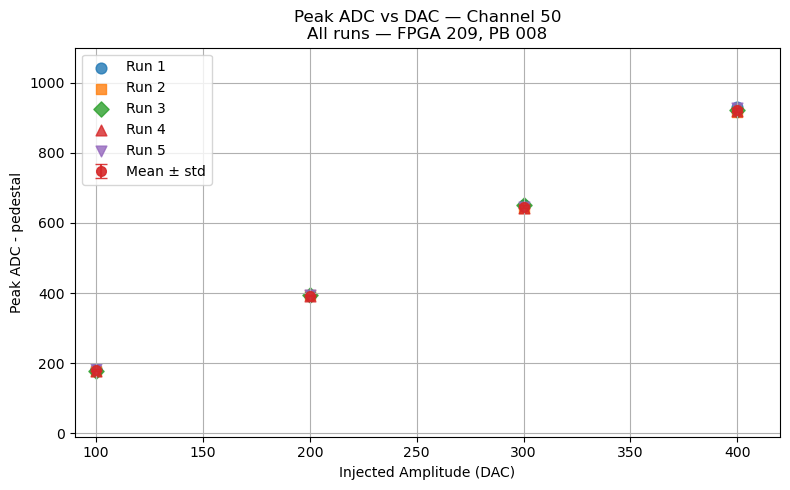


Statistics (mean/std per amplitude):


,Amplitude,mean,std
0,100,179.8,2.489980
1,200,392.8,1.303840
2,300,646.6,3.646917
3,400,923.2,5.890671


In [82]:
# ===== Choices =====
# "all" → show all runs, with different markers for each run
#   1–5 → show only that run
run_selection = "all"

print(f"Channel of interest: {channel_of_interest}")
print(f"Run selection: {run_selection}")

# Manual discarded list for this pair
manual_discarded_channels = manual_discarded_by_pair.get(
    (fpga_adc_mean, pb_adc_mean),
    set()
)
print("Manual discarded channels for this pair:", manual_discarded_channels)

# Check if channel is allowed
if (channel_of_interest in dead_channels or
    channel_of_interest in calibration_channels or
    channel_of_interest in notConnected_channels or
    channel_of_interest in manual_discarded_channels):
    print(f"⚠️ Channel {channel_of_interest} is discarded (dead/cal/notConnected/manual).")
else:

    # Fetch directory tree for this FPGA–PB pair
    try:
        all_dirs_pair = all_dirs[pair_key_mean]
    except KeyError:
        print(f"No all_dirs entry for pair {pair_key_mean}")
        all_dirs_pair = {}

    if not all_dirs_pair:
        print("No files available for this pair.")
    else:

        ped_i = pedestal_map_mean.get(channel_of_interest, fallback_pedestal)
        print(f"Using pedestal = {ped_i:.1f} ADC for channel {channel_of_interest}")

        # Markers for each run
        run_markers = ["o", "s", "D", "^", "v"]  # Run0, Run1, Run2, Run3, Run4

        # ----------------------------
        # CASE 1 ---------------------
        # Show ALL runs, separated
        # ----------------------------
        if run_selection == "all":

            fig, ax = plt.subplots(figsize=(8, 5))

            df_all = []   # to compute mean & std

            for run_idx in range(CONFIG["runs"]):  # 0..4
                run_marker = run_markers[run_idx]

                amps_this_run = []
                peaks_this_run = []

                # Loop over amplitudes
                for amplitude, runs_dict in all_dirs_pair.items():

                    if run_idx not in runs_dict:
                        continue
                    
                    run_file = runs_dict[run_idx]
                    if not os.path.exists(run_file):
                        continue

                    df = pd.read_csv(run_file)
                    df.columns = df.columns.str.strip()

                    # Filter one channel
                    channel_data = df[
                        (df["Channel"] == channel_of_interest) &
                        (~df["Phase"].isin([4, 6, 7]))
                    ]

                    if channel_data.empty:
                        continue

                    peak_val = channel_data["ADC"].max() - ped_i

                    amps_this_run.append(amplitude)
                    peaks_this_run.append(peak_val)

                    df_all.append([amplitude, peak_val])

                # ---- Plot this run ----
                if amps_this_run:
                    ax.scatter(
                        amps_this_run,
                        peaks_this_run,
                        label=f"Run {run_idx+1}",
                        marker=run_marker,
                        s=60,
                        alpha=0.8
                    )

            # Convert all data to df for computing mean & std
            df_all = pd.DataFrame(df_all, columns=["Amplitude", "PeakADC"])
            df_all = df_all.sort_values("Amplitude")

            stats = (
                df_all.groupby("Amplitude")["PeakADC"]
                .agg(["mean", "std"])
                .reset_index()
            )

            # Mean ± std
            ax.errorbar(
                stats["Amplitude"],
                stats["mean"],
                yerr=stats["std"],
                fmt="o",
                markersize=7,
                capsize=4,
                color="tab:red",
                ecolor="tab:red",
                label="Mean ± std",
                alpha=0.9
            )

            # Labels
            ax.set_title(
                f"Peak ADC vs DAC — Channel {channel_of_interest}\n"
                f"All runs — FPGA {fpga_adc_mean}, PB {pb_adc_mean}"
            )
            ax.set_xlabel("Injected Amplitude (DAC)")
            ax.set_ylabel("Peak ADC - pedestal")
            ax.set_xlim(min(CONFIG["amplitudes"]) - 10,
                        max(CONFIG["amplitudes"]) + 20)
            ax.set_ylim(-10, 1100)
            ax.grid(True)
            ax.legend()
            plt.tight_layout()
            plt.show()

            print("\nStatistics (mean/std per amplitude):")
            display(stats)

        # ----------------------------
        # CASE 2 ---------------------
        # Only one run selected
        # ----------------------------
        else:
            if not isinstance(run_selection, int) or not (1 <= run_selection <= CONFIG["runs"]):
                print(f"❌ Invalid run_selection={run_selection}. Must be 'all' or 1..{CONFIG['runs']}.")
            else:
                run_idx = run_selection - 1
                marker = run_markers[run_idx]

                amps = []
                peaks = []

                for amplitude, runs_dict in all_dirs_pair.items():
                    if run_idx not in runs_dict:
                        continue

                    run_file = runs_dict[run_idx]
                    if not os.path.exists(run_file):
                        continue

                    df = pd.read_csv(run_file)
                    df.columns = df.columns.str.strip()

                    channel_data = df[
                        (df["Channel"] == channel_of_interest) &
                        (~df["Phase"].isin([4, 6, 7]))
                    ]

                    if channel_data.empty:
                        continue

                    peak_val = channel_data["ADC"].max() - ped_i
                    amps.append(amplitude)
                    peaks.append(peak_val)

                # Plot for the single run
                fig, ax = plt.subplots(figsize=(8, 5))
                ax.scatter(
                    amps, peaks,
                    marker=marker,
                    s=80,
                    alpha=0.9,
                    label=f"Run {run_selection}"
                )
                ax.set_title(
                    f"Peak ADC vs DAC — Channel {channel_of_interest}\n"
                    f"Run {run_selection} — FPGA {fpga_adc_mean}, PB {pb_adc_mean}"
                )
                ax.set_xlabel("Injected Amplitude (DAC)")
                ax.set_ylabel("Peak ADC - pedestal")
                ax.set_xlim(min(CONFIG["amplitudes"]) - 10,
                            max(CONFIG["amplitudes"]) + 20)
                ax.set_ylim(-10, 1100)
                ax.grid(True)
                ax.legend()
                plt.tight_layout()
                plt.show()


## ToT linearity One Channel

Manual discarded channels for this pair (ToT): {34, 103, 40, 41, 39}


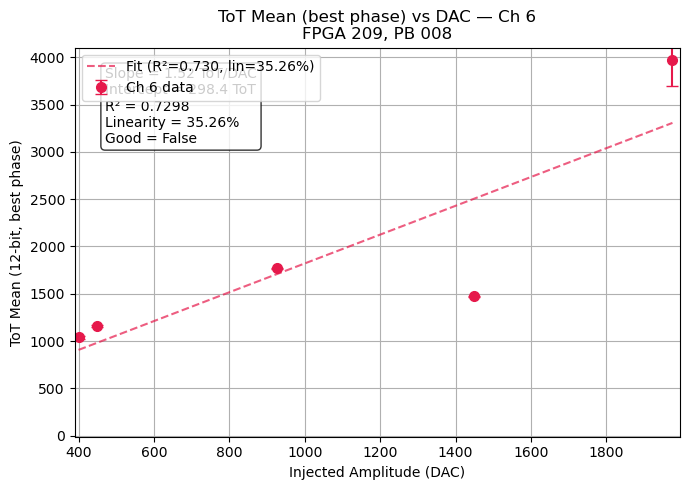

ToT linearity figure saved to:
  /home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_209_pb008/linearity_ToT_channel6_fpga209-pb008_bestPhase.png


In [83]:
# ========= User choice: channel =========
channel_of_interest_tot = 6  # change as needed

# ========= Manual discarded channels for THIS FPGA–PB pair (ToT) =========
manual_discarded_channels_tot = manual_discarded_by_pair.get(
    (fpga_tot_mean, pb_tot_mean),
    set()
)
print("Manual discarded channels for this pair (ToT):", manual_discarded_channels_tot)

# ========= Check if this channel is allowed =========
if (channel_of_interest_tot in dead_channels or
    channel_of_interest_tot in calibration_channels or
    channel_of_interest_tot in notConnected_channels or
    channel_of_interest_tot in manual_discarded_channels_tot):
    print(f"Channel {channel_of_interest_tot} is in a discarded list "
          f"(dead/calibration/notConnected/manual).")
    fig_tot = None  # to avoid save errors later

else:
    # Select this channel's ToT summary (mean & std over amplitudes)
    df_ch_tot = tot_summary[tot_summary["Channel"] == channel_of_interest_tot]

    if df_ch_tot.empty:
        print(f"No data found in tot_summary for channel {channel_of_interest_tot}.")
        fig_tot = None

    else:
        # Sort by amplitude
        df_ch_tot = df_ch_tot.sort_values("Amplitude")
        amps  = df_ch_tot["Amplitude"].values
        means = df_ch_tot["mean"].values
        stds  = df_ch_tot["std"].values

        if len(amps) < 2:
            print(f"Not enough amplitude points to fit a line for channel {channel_of_interest_tot}.")
            fig_tot = None
        else:
            # Pick a color + marker
            color  = color_list[0]
            marker = markers[0]

            # ----- Linear regression (ToT vs DAC) -----
            slope, intercept, r_value, p_value, std_err = linregress(amps, means)
            r2 = r_value ** 2

            # Deviation-based linearity (%)
            fit_vals = slope * amps + intercept
            deviations = means - fit_vals
            max_deviation = np.max(np.abs(deviations))
            full_scale = np.max(means) - np.min(means)

            if full_scale > 0:
                linearity_percentage = max_deviation / full_scale * 100
            else:
                linearity_percentage = 0.0

            # Classification (same acceptance_value as ADC)
            is_good = r2 >= acceptance_value

            # ----- Plot -----
            fig_tot, ax_tot = plt.subplots(figsize=(7, 5))

            # Error bars (mean ± std)
            ax_tot.errorbar(
                amps, means,
                yerr=stds,
                fmt=marker,
                markersize=7,
                capsize=4,
                color=color,
                ecolor=color,
                linestyle="none",
                label=f"Ch {channel_of_interest_tot} data",
            )

            # Regression line
            x_line = np.linspace(amps.min(), amps.max(), 200)
            y_line = slope * x_line + intercept

            ax_tot.plot(
                x_line, y_line,
                linestyle="--",
                linewidth=1.5,
                alpha=0.7,
                color=color,
                label=f"Fit (R²={r2:.3f}, lin={linearity_percentage:.2f}%)"
            )

            # Labels, title, etc.
            ax_tot.set_title(
                f"ToT Mean (best phase) vs DAC — Ch {channel_of_interest_tot}\n"
                f"FPGA {fpga_tot_mean}, PB {pb_tot_mean}"
            )
            ax_tot.set_xlabel("Injected Amplitude (DAC)")
            ax_tot.set_ylabel("ToT Mean (12-bit, best phase)")
            ax_tot.set_xlim(min(CONFIG_TOT["amplitudes"]) - 10,
                            max(CONFIG_TOT["amplitudes"]) + 20)
            ax_tot.set_ylim(-10, 4100)
            ax_tot.grid(True)
            ax_tot.legend(loc="best")

            # Optional: info box
            txt = (
                f"Slope = {slope:.2f} ToT/DAC\n"
                f"Intercept = {intercept:.1f} ToT\n"
                f"R² = {r2:.4f}\n"
                f"Linearity = {linearity_percentage:.2f}%\n"
                f"Good = {is_good}"
            )
            ax_tot.text(
                0.05, 0.95, txt,
                transform=ax_tot.transAxes,
                va="top", ha="left",
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
            )

            plt.tight_layout()
            plt.show()

# ========= Save figure (only if it was created) =========
if 'fig_tot' in globals() and fig_tot is not None:
    output_dir_tot_single = os.path.join(
        CONFIG_TOT["base_path"],
        f"images/FPGA_{fpga_tot_mean}_pb{pb_tot_mean}"
    )
    os.makedirs(output_dir_tot_single, exist_ok=True)

    output_path_tot_single = os.path.join(
        output_dir_tot_single,
        f"linearity_ToT_channel{channel_of_interest_tot}_"
        f"fpga{fpga_tot_mean}-pb{pb_tot_mean}_bestPhase.png"
    )

    fig_tot.savefig(output_path_tot_single, dpi=200)
    print(f"ToT linearity figure saved to:\n  {output_path_tot_single}")
else:
    print("No ToT figure to save for this channel.")


# ToT to ADC

In [84]:
# # ========= User choices =========
# pair_id = 0                # 0 → (208,06), 1 → (209,008)
# dac_values = [300, 400, 450]  # amplitudes to include in the ADC vs TOT12 plot

# # ========= Get FPGA–PB pair from CONFIG =========
# fpga_adc, pb_adc = CONFIG["fpga_pb_pairs"][pair_id]   # e.g. ("208", "06")
# pair_key = f"fpga{fpga_adc}_pb{pb_adc}"

# # ========= Load pedestal CSV and build channel → pedestal map =========
# ped_df = pd.read_csv(PEDESTAL_CSV)

# fpga_int = int(fpga_adc)
# pb_int   = int(pb_adc)   # "06" → 6, "008" → 8

# ped_sub = ped_df[(ped_df["FPGA"] == fpga_int) & (ped_df["PB"] == pb_int)]
# pedestal_map = ped_sub.set_index("Channel")["HV"].to_dict()

# print(f"Loaded {len(pedestal_map)} pedestal values for FPGA {fpga_int}, PB {pb_int}")

# # ========= Grouping settings =========
# num_groups = 8
# files_per_group = 19

# # ========= Figure =========
# fig, axs = plt.subplots(4, 2, figsize=(16, 20))
# axs = axs.flatten()

# # ========= Loop over channel groups =========
# for group_id in range(num_groups):
#     ax = axs[group_id]
#     first_channel = group_id * files_per_group
#     last_channel = first_channel + files_per_group
#     marker_index = 0

#     for channel in range(first_channel, last_channel):
#         # Skip unwanted channels
#         if (channel in dead_channels or
#             channel in calibration_channels or
#             channel in notConnected_channels):
#             continue

#         ped_i = pedestal_map.get(channel, fallback_pedestal)

#         # Here we will collect per-run maxima for all DACs
#         per_run_records = []

#         # Loop over DAC values (amplitudes)
#         for injected_amplitude in dac_values:
#             # Get run_files for this amplitude
#             try:
#                 run_files = all_dirs_tot[pair_key][injected_amplitude]   # dict: run_idx -> file_path
#             except KeyError:
#                 # No files for this amplitude/pair
#                 continue

#             for run_idx, file_path in run_files.items():
#                 if not os.path.exists(file_path):
#                     print(f"File not found: {file_path}")
#                     continue

#                 df = pd.read_csv(file_path)
#                 df.columns = df.columns.str.strip()

#                 # Filter by channel and remove unwanted phases
#                 channel_data = df[
#                     (df['Channel'] == channel) &
#                     (~df['Phase'].isin([4, 6, 7]))
#                 ]

#                 if channel_data.empty:
#                     continue

#                 channel_data = channel_data.copy()
#                 # Subtract pedestal
#                 channel_data['ADC_corr'] = channel_data['ADC'] - ped_i

#                 adc_max_run = channel_data['ADC_corr'].max()
#                 tot_max_run = channel_data['TOT_12bit'].max()

#                 per_run_records.append({
#                     "DAC": injected_amplitude,
#                     "Run": run_idx,
#                     "ADC_max": adc_max_run,
#                     "TOT12_max": tot_max_run
#                 })

#         # If we have no data for this channel at any DAC, skip
#         if not per_run_records:
#             continue

#         # Convert to DataFrame
#         ch_df = pd.DataFrame(per_run_records)

#         # Remove cases where TOT is zero everywhere (no ToT info)
#         if (ch_df["TOT12_max"] <= 0).all():
#             continue

#         # Compute mean and std per DAC
#         stats = (
#             ch_df
#             .groupby("DAC")
#             .agg(
#                 mean_ADC=("ADC_max", "mean"),
#                 std_ADC=("ADC_max", "std"),
#                 mean_TOT=("TOT12_max", "mean"),
#                 std_TOT=("TOT12_max", "std"),
#             )
#             .reset_index()
#         )

#         # Filter out DAC points with TOT = 0 (if any)
#         stats = stats[stats["mean_TOT"] > 0]
#         if stats.empty:
#             continue

#         # Plot mean ADC vs mean TOT with error bars
#         ax.errorbar(
#             stats["mean_TOT"],
#             stats["mean_ADC"],
#             xerr=stats["std_TOT"],
#             yerr=stats["std_ADC"],
#             fmt=markers[marker_index % len(markers)],
#             markersize=4,
#             capsize=3,
#             elinewidth=0.8,
#             label=f'Ch {channel}',
#             alpha=0.8,
#         )
#         marker_index += 1

#     ax.set_title(
#         f'FPGA {fpga_adc}, PB {pb_adc} — ADC vs TOT12 '
#         f'(channels {first_channel}–{last_channel - 1})'
#     )
#     ax.set_xlabel('Mean TOT_12bit')
#     ax.set_ylabel('Mean max ADC - pedestal')
#     ax.grid(True)
#     ax.legend(fontsize='x-small', markerscale=0.9)

# plt.tight_layout()
# plt.show()

# # Optional save:
# output_dir = f'/home/lorena/Documents/PhD/EEEMCal_Analysis/Linearity_Studies_Nov2025/images/FPGA_{fpga_adc}_pb{pb_adc}'
# os.makedirs(output_dir, exist_ok=True)
# # fig.savefig(os.path.join(output_dir, f'ADC_vs_TOT12_AllChannels_fpga{fpga_adc}-pb{pb_adc}.png'))
